In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import random
from sklearn.model_selection import PredefinedSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


seed_value = 1
random.seed(seed_value)
np.random.seed(seed_value)

# Load the dataset and specify the correct delimiter (semicolon)
data = pd.read_csv('radiomics_lgg.csv', delimiter=';')

# Drop non-numeric columns (e.g., 'patientID')
X = data.drop(columns=['patientID', 'Mutacion'])  # Features
y = data['Mutacion']  # Target variable (classification)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

num_rows, num_columns = X_scaled.shape

# Print the number of columns
print(f"The number of columns in X_scaled is: {num_columns}")




The number of columns in X_scaled is: 640


ANOVA:

In [ ]:
# Select top features using ANOVA
anova_selector = SelectKBest(f_classif, k=10)  # Select top 10 features
X_anova = anova_selector.fit_transform(X_scaled, y)

# Get selected feature names
anova_features = X.columns[anova_selector.get_support()]
print("Selected features using ANOVA:")
print(anova_features)


Selected features using ANOVA:
Index(['original_firstorder_Median', 'original_firstorder_Skewness',
       'original_glcm_ClusterShade', 'original_glcm_JointEnergy',
       'original_glcm_MaximumProbability', 'original_gldm_DependenceVariance',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'wavelet-HLL_firstorder_Skewness',
       'wavelet-HLL_glcm_MaximumProbability',
       'wavelet-LHL_glcm_MaximumProbability'],
      dtype='object')


mutual information:

In [ ]:
# Select top features using Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=10)  # Select top 10 features
X_mi = mi_selector.fit_transform(X_scaled, y)

# Get selected feature names
mi_features = X.columns[mi_selector.get_support()]
print("Selected features using Mutual Information:")
print(mi_features)


Selected features using Mutual Information:
Index(['original_firstorder_Skewness', 'original_glcm_ClusterShade',
       'original_glcm_JointEnergy', 'original_gldm_DependenceEntropy',
       'wavelet-HLL_firstorder_TotalEnergy', 'wavelet-HLL_glcm_JointEnergy',
       'wavelet-HLL_glcm_MaximumProbability',
       'wavelet-LHL_glcm_MaximumProbability', 'wavelet-LLH_firstorder_Energy',
       'wavelet-LLH_firstorder_TotalEnergy'],
      dtype='object')


Removing Correlated Features:

In [ ]:
# Calculate correlation matrix
corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr().abs()

# Upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find and remove highly correlated features (threshold of 0.9)
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
X_uncorrelated = X.drop(columns=to_drop)

print("Removed correlated features:")
print(to_drop)
print("Remaining features after removing correlated ones:")
print(X_uncorrelated.columns)


Removed correlated features:
['original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Maximum', 'original_firstorder_Mean', 'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Median', 'original_firstorder_Range', 'original_firstorder_RobustMeanAbsoluteDeviation', 'original_firstorder_RootMeanSquared', 'original_firstorder_TotalEnergy', 'original_firstorder_Uniformity', 'original_firstorder_Variance', 'original_glcm_Autocorrelation', 'original_glcm_ClusterProminence', 'original_glcm_ClusterShade', 'original_glcm_ClusterTendency', 'original_glcm_Contrast', 'original_glcm_DifferenceAverage', 'original_glcm_DifferenceEntropy', 'original_glcm_DifferenceVariance', 'original_glcm_Id', 'original_glcm_Idm', 'original_glcm_Idn', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glcm_JointAverage', 'original_glcm_JointEnergy', 'original_glcm_JointEntropy', 'original_glcm_MaximumProbability', 'original_glcm_SumEntropy', 'orig

Recursive Feature Elimination (RFE):

In [ ]:
rf_model = RandomForestClassifier(random_state=seed_value)
rfe_selector = RFE(rf_model, n_features_to_select=10)  # Select top 10 features
X_rfe = rfe_selector.fit_transform(X_scaled, y)

# Get selected feature names
rfe_features = X.columns[rfe_selector.get_support()]
print("Selected features using RFE:")
print(rfe_features)


Selected features using RFE:
Index(['original_firstorder_Median', 'original_firstorder_Skewness',
       'original_glcm_ClusterShade',
       'original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'original_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet-HLH_glszm_SizeZoneNonUniformityNormalized',
       'wavelet-HLL_firstorder_Skewness', 'wavelet-HLL_glcm_ClusterShade',
       'wavelet-HLL_glcm_MaximumProbability', 'wavelet-LHH_glcm_Imc1'],
      dtype='object')


lasso regression:

In [ ]:
# LassoCV to select important features
lasso = LassoCV(cv=5)
lasso.fit(X_scaled, y)

# Select features with non-zero coefficients
lasso_features = X.columns[(lasso.coef_ != 0)]
print("Selected features using Lasso:")
print(lasso_features)
X_lasso = X_scaled[:, (lasso.coef_ != 0)]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e-03, tolerance: 1.981e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.729e-03, tolerance: 1.981e-03
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.434e-03, tolerance: 1.981e

Selected features using Lasso:
Index(['original_firstorder_Skewness', 'original_glcm_ClusterShade',
       'original_glcm_JointAverage', 'original_glcm_MaximumProbability',
       'wavelet-HHH_firstorder_Median', 'wavelet-HHH_glcm_JointAverage',
       'wavelet-HHL_firstorder_Mean', 'wavelet-HHL_firstorder_Median',
       'wavelet-HLH_firstorder_RootMeanSquared',
       'wavelet-HLH_glszm_LargeAreaHighGrayLevelEmphasis',
       'wavelet-HLL_firstorder_Median', 'wavelet-HLL_firstorder_Skewness',
       'wavelet-HLL_firstorder_TotalEnergy', 'wavelet-HLL_glcm_ClusterShade',
       'wavelet-HLL_gldm_LargeDependenceLowGrayLevelEmphasis',
       'wavelet-HLL_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet-LHH_firstorder_Median', 'wavelet-LHH_glcm_Imc1',
       'wavelet-LHH_glcm_Imc2', 'wavelet-LHL_glcm_MaximumProbability',
       'wavelet-LLH_firstorder_Kurtosis'],
      dtype='object')


Using features obtained with RFE/lasso and applying different classifiers:

Classification Report for K-Nearest Neighbours:



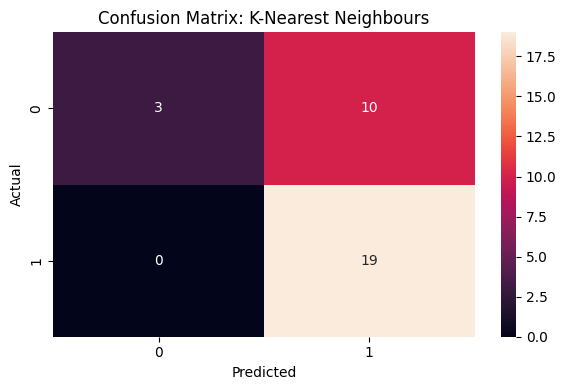

Accuracy: 0.6875

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.23      0.38        13
           1       0.66      1.00      0.79        19

    accuracy                           0.69        32
   macro avg       0.83      0.62      0.58        32
weighted avg       0.80      0.69      0.62        32

---------------------------------------------------------

Classification Report for SVM:



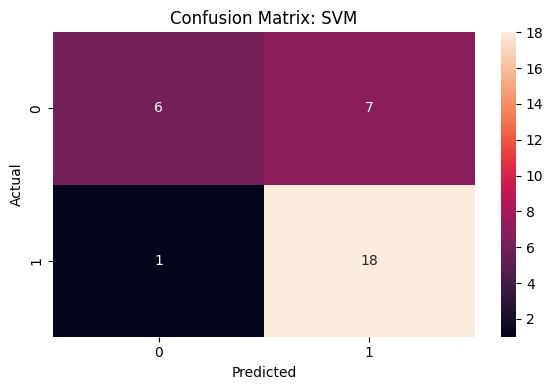

Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.46      0.60        13
           1       0.72      0.95      0.82        19

    accuracy                           0.75        32
   macro avg       0.79      0.70      0.71        32
weighted avg       0.78      0.75      0.73        32

---------------------------------------------------------

Classification Report for Random Forests:



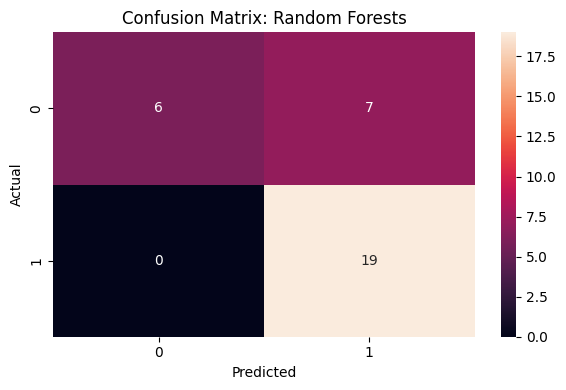

Accuracy: 0.78125

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.46      0.63        13
           1       0.73      1.00      0.84        19

    accuracy                           0.78        32
   macro avg       0.87      0.73      0.74        32
weighted avg       0.84      0.78      0.76        32

---------------------------------------------------------

Classification Report for Gradient Boosting:



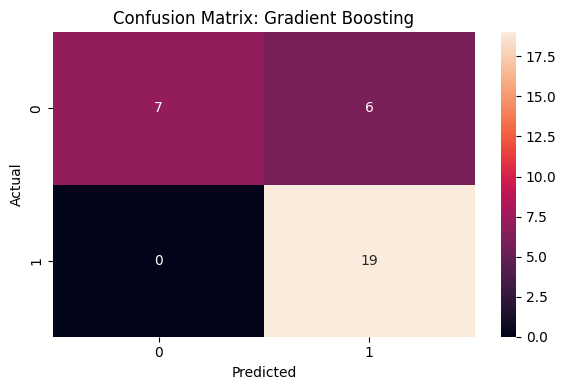

Accuracy: 0.8125

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.54      0.70        13
           1       0.76      1.00      0.86        19

    accuracy                           0.81        32
   macro avg       0.88      0.77      0.78        32
weighted avg       0.86      0.81      0.80        32

---------------------------------------------------------

Classification Report for Logistic Regression:



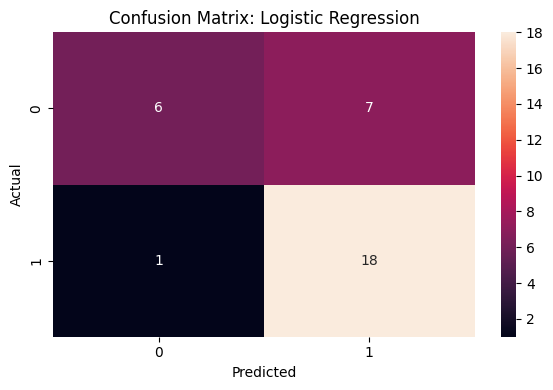

Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.46      0.60        13
           1       0.72      0.95      0.82        19

    accuracy                           0.75        32
   macro avg       0.79      0.70      0.71        32
weighted avg       0.78      0.75      0.73        32

---------------------------------------------------------

Classification Report for Naive Bayes:



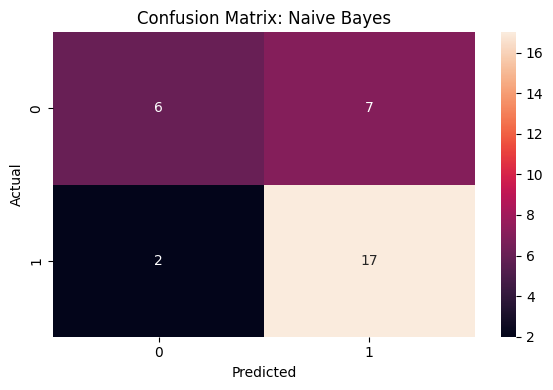

Accuracy: 0.71875

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.46      0.57        13
           1       0.71      0.89      0.79        19

    accuracy                           0.72        32
   macro avg       0.73      0.68      0.68        32
weighted avg       0.73      0.72      0.70        32

---------------------------------------------------------

Classification Report for Multilayer Perceptron (MLP):



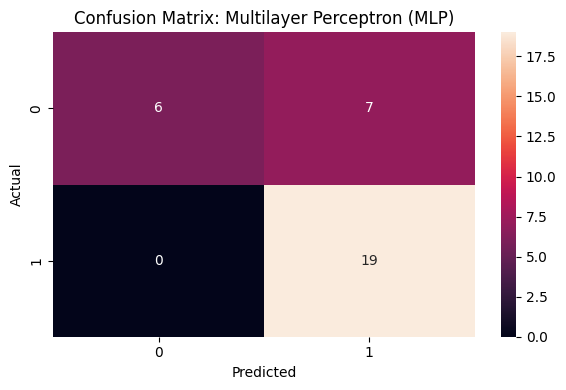

Accuracy: 0.78125

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.46      0.63        13
           1       0.73      1.00      0.84        19

    accuracy                           0.78        32
   macro avg       0.87      0.73      0.74        32
weighted avg       0.84      0.78      0.76        32

---------------------------------------------------------

Classification Report for XGBoost:



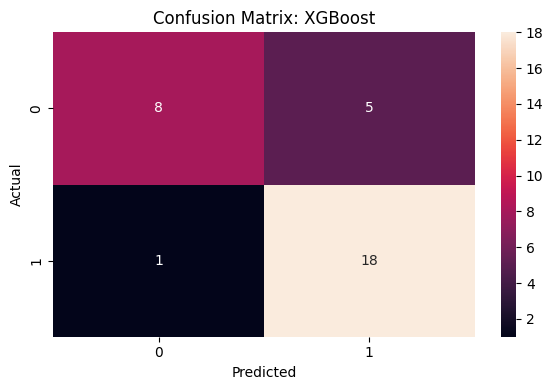

Accuracy: 0.8125

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.78      0.95      0.86        19

    accuracy                           0.81        32
   macro avg       0.84      0.78      0.79        32
weighted avg       0.83      0.81      0.80        32

---------------------------------------------------------

Classification Report for Bagging Tree:



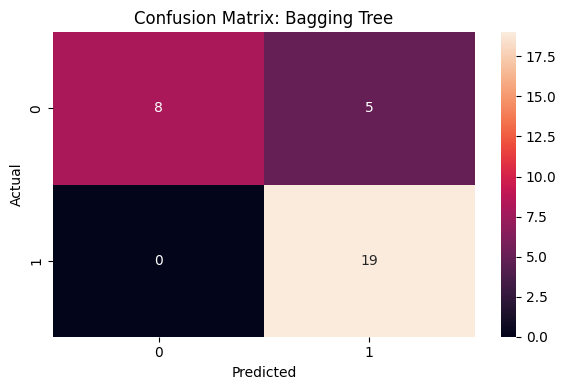

Accuracy: 0.84375

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.62      0.76        13
           1       0.79      1.00      0.88        19

    accuracy                           0.84        32
   macro avg       0.90      0.81      0.82        32
weighted avg       0.88      0.84      0.83        32

---------------------------------------------------------



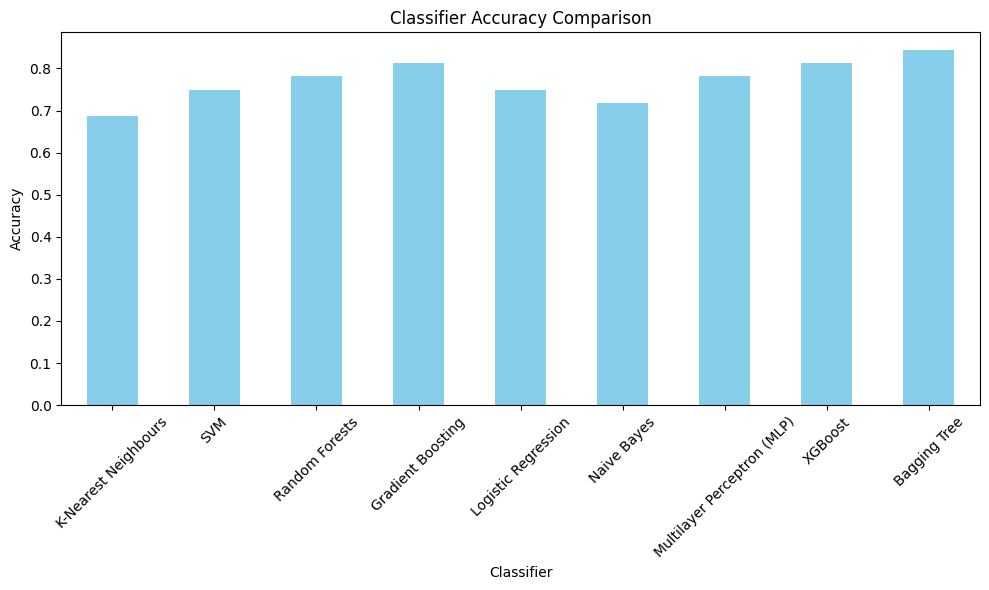

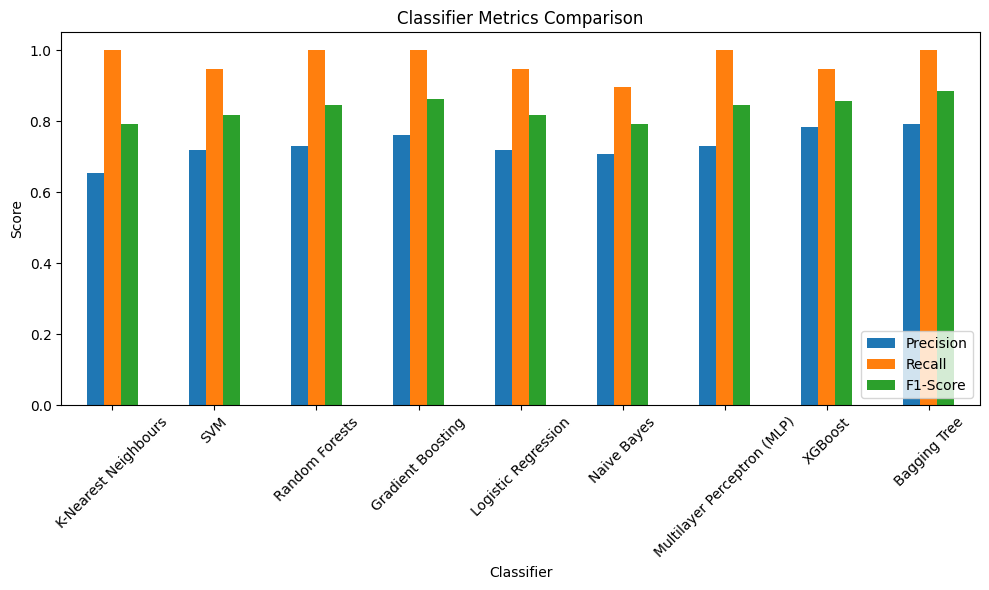

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.3, random_state=seed_value)

# List of classifiers
# List of classifiers with random_state set where applicable
classifiers = {
    'K-Nearest Neighbours': KNeighborsClassifier(3),
    'SVM': SVC(kernel="linear"),
    'Random Forests': RandomForestClassifier(random_state=seed_value),
    'Gradient Boosting': GradientBoostingClassifier(random_state=seed_value),
    'Logistic Regression': LogisticRegression(max_iter=10000, random_state=seed_value),
    'Naive Bayes': GaussianNB(),
    'Multilayer Perceptron (MLP)': MLPClassifier(max_iter=1000, random_state=seed_value),
    'XGBoost': XGBClassifier(random_state=seed_value),
    'Bagging Tree': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=seed_value)
}


# Initialize lists to store the results
classifier_names = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Function to train and evaluate classifiers
def evaluate_classifier(classifier, classifier_name, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)  # Train the model
    y_pred = classifier.predict(X_test)  # Predict on the test set

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {classifier_name}')
    plt.tight_layout()
    plt.show()

    # Close the figure to prevent it from displaying multiple times
    plt.close()

    # Calculate accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    precision = class_report['1']['precision']  # Precision for class 1
    recall = class_report['1']['recall']  # Recall for class 1
    f1_score = class_report['1']['f1-score']  # F1-score for class 1

    # Print accuracy and classification report
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Append the results to the lists
    classifier_names.append(classifier_name)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

    return accuracy, class_report

# Apply classifiers and evaluate their performance
for classifier_name, classifier in classifiers.items():
    print(f"Classification Report for {classifier_name}:\n")

    # Evaluate the classifier and collect metrics
    evaluate_classifier(classifier, classifier_name, X_train, y_train, X_test, y_test)

    print("---------------------------------------------------------\n")

# Create a DataFrame from the results
results_df = pd.DataFrame({
    'Classifier': classifier_names,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

# Highlight the best result in each metric
def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the highlighting to the DataFrame
styled_results = results_df.style.apply(highlight_best, subset=['Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Display the results table
display(styled_results)

# Create combined bar plots for the metrics
metrics_df = results_df.set_index('Classifier')

# Plot combined accuracy
plt.figure(figsize=(10, 6))
metrics_df['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Classifier Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Close the figure
plt.close()

# Plot combined precision, recall, and F1-Score
metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', figsize=(10, 6))
plt.title('Classifier Metrics Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Close the figure
plt.close()


SVM, random forests and MLP show best performance. Now they are evaluated using grid search for trying different hyperparameters to find the best model/configuration.

grid search neue version , test train split


Tuning K-Nearest Neighbours hyperparameters...
Fitting 1 folds for each of 4 candidates, totalling 4 fits

Best Parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best Cross-Validation Accuracy: 0.8571

Tuning Logistic Regression hyperparameters...
Fitting 1 folds for each of 4 candidates, totalling 4 fits

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 1.0000

Using default Naive Bayes model...

Tuning Bagging Classifier hyperparameters...
Fitting 1 folds for each of 3 candidates, totalling 3 fits

Best Parameters for BaggingClassifier: {'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9524

Tuning SVM hyperparameters...
Fitting 1 folds for each of 90 candidates, totalling 90 fits

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 1.0000

Tuning Random Forest hyperparameters...
Fitting 1 folds for each of 144 candidates, totalling 144 fits

Best Parameters for RandomForest

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_meth


Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Accuracy: 1.0000

Tuning SGD hyperparameters...
Fitting 1 folds for each of 3 candidates, totalling 3 fits

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.01, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 1.0000

Tuning LDA hyperparameters...
Fitting 1 folds for each of 6 candidates, totalling 6 fits

Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': None, 'solver': 'svd'}
Best Cross-Validation Accuracy: 1.0000

Evaluating the best K-Nearest Neighbours model on the test set...


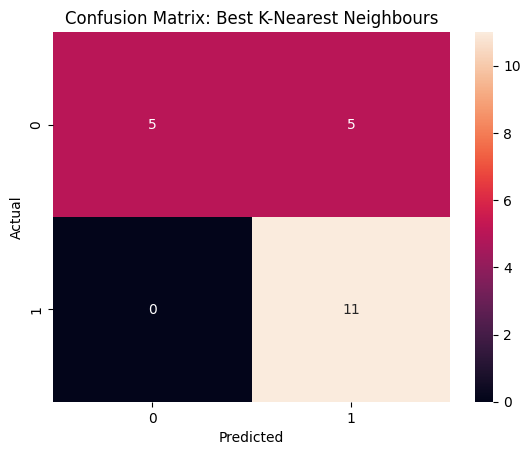

Accuracy for Best K-Nearest Neighbours: 0.7619047619047619

Classification Report for Best K-Nearest Neighbours:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.69      1.00      0.81        11

    accuracy                           0.76        21
   macro avg       0.84      0.75      0.74        21
weighted avg       0.84      0.76      0.74        21


Evaluating the best Logistic Regression model on the test set...


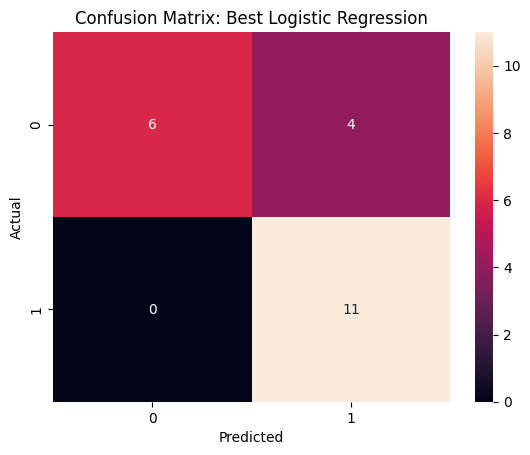

Accuracy for Best Logistic Regression: 0.8095238095238095

Classification Report for Best Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.73      1.00      0.85        11

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21


Evaluating the best Naive Bayes model on the test set...


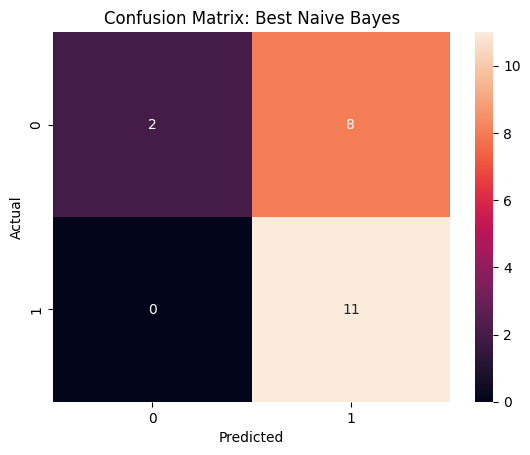

Accuracy for Best Naive Bayes: 0.6190476190476191

Classification Report for Best Naive Bayes:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33        10
           1       0.58      1.00      0.73        11

    accuracy                           0.62        21
   macro avg       0.79      0.60      0.53        21
weighted avg       0.78      0.62      0.54        21


Evaluating the best Bagging Classifier model on the test set...


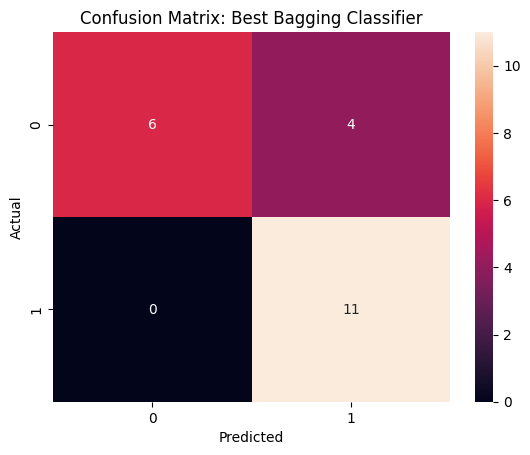

Accuracy for Best Bagging Classifier: 0.8095238095238095

Classification Report for Best Bagging Classifier:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.73      1.00      0.85        11

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21


Evaluating the best SVM model on the test set...


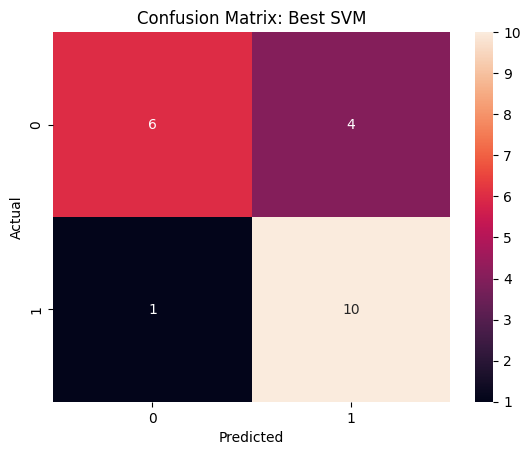

Accuracy for Best SVM: 0.7619047619047619

Classification Report for Best SVM:
               precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.71      0.91      0.80        11

    accuracy                           0.76        21
   macro avg       0.79      0.75      0.75        21
weighted avg       0.78      0.76      0.76        21


Evaluating the best Random Forest model on the test set...


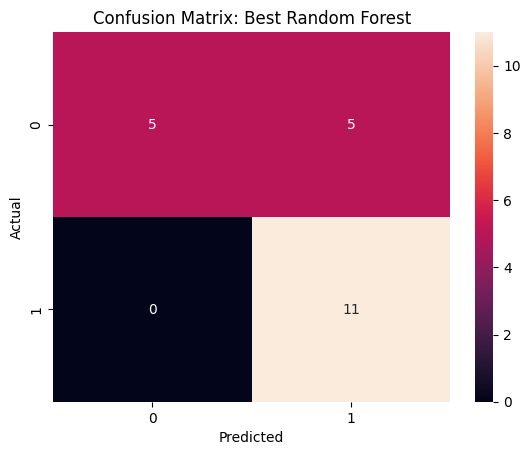

Accuracy for Best Random Forest: 0.7619047619047619

Classification Report for Best Random Forest:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.69      1.00      0.81        11

    accuracy                           0.76        21
   macro avg       0.84      0.75      0.74        21
weighted avg       0.84      0.76      0.74        21


Evaluating the best MLP model on the test set...


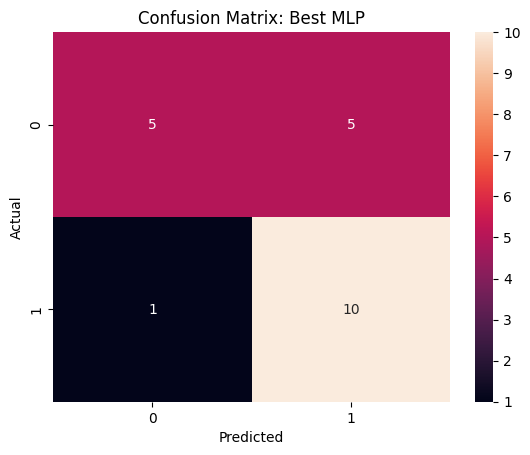

Accuracy for Best MLP: 0.7142857142857143

Classification Report for Best MLP:
               precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.67      0.91      0.77        11

    accuracy                           0.71        21
   macro avg       0.75      0.70      0.70        21
weighted avg       0.75      0.71      0.70        21


Evaluating the best XGBoost model on the test set...


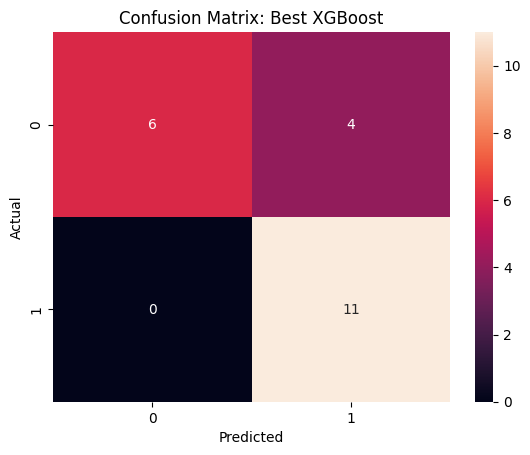

Accuracy for Best XGBoost: 0.8095238095238095

Classification Report for Best XGBoost:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.73      1.00      0.85        11

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21


Evaluating the best SGD model on the test set...


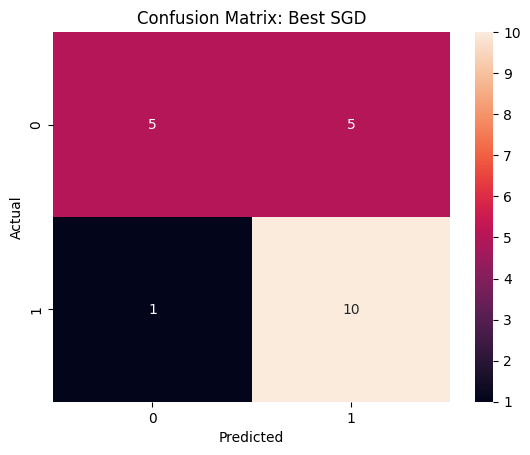

Accuracy for Best SGD: 0.7142857142857143

Classification Report for Best SGD:
               precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.67      0.91      0.77        11

    accuracy                           0.71        21
   macro avg       0.75      0.70      0.70        21
weighted avg       0.75      0.71      0.70        21


Evaluating the best LDA model on the test set...


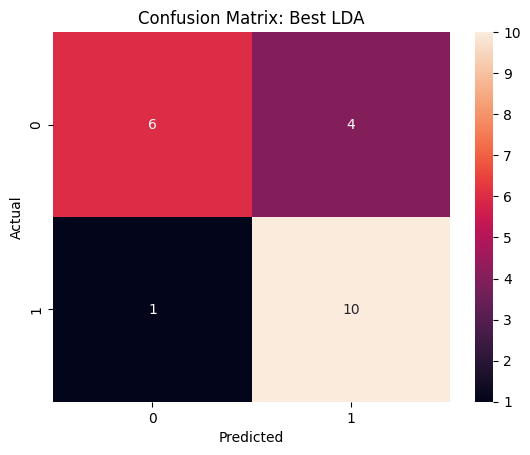

Accuracy for Best LDA: 0.7619047619047619

Classification Report for Best LDA:
               precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.71      0.91      0.80        11

    accuracy                           0.76        21
   macro avg       0.79      0.75      0.75        21
weighted avg       0.78      0.76      0.76        21



Classifier  Accuracy  Precision    Recall  F1-Score  \
0  K-Nearest Neighbours  0.761905   0.687500  1.000000  0.814815   
1   Logistic Regression  0.809524   0.733333  1.000000  0.846154   
2           Naive Bayes  0.619048   0.578947  1.000000  0.733333   
3    Bagging Classifier  0.809524   0.733333  1.000000  0.846154   
4                   SVM  0.761905   0.714286  0.909091  0.800000   
5         Random Forest  0.761905   0.687500  1.000000  0.814815   
6                   MLP  0.714286   0.666667  0.909091  0.769231   
7               XGBoost  0.809524   0.733333  1.000000  0.846154   
8                   SGD  0.714286   0.666667  0.909091  0.769231   
9                   LDA  0.761905   0.714286  0.909091  0.800000   

                                         Best Params  
0  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
1  {'C': 0.1, 'class_weight': None, 'dual': False...  
2                                            Default  
3  {'bootstrap': True, 'bootstrap_features': Fals...  
4  {'C': 1, 'break_ties': False, 'cache_size': 20...  
5  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
6  {'activation': 'tanh', 'alpha': 0.0001, 'batch...  
7  {'objective': 'binary:logistic', 'base_score':...  
8  {'cv': None, 'ensemble': True, 'estimator__alp...  
9  {'covariance_estimator': None, 'n_components':...

In [ ]:
from sklearn.model_selection import PredefinedSplit

# Split data into temp (80%) and test sets (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=seed_value)

# Split temp into train (60%) and validation sets (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=seed_value)

scaler = StandardScaler()

# Function to evaluate and plot confusion matrix
def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

    # Print accuracy and classification report
    print(f"Accuracy for {title}:", accuracy_score(y_test, y_pred))
    print(f"\nClassification Report for {title}:\n", classification_report(y_test, y_pred))

    # Return accuracy, precision, recall, and F1 score for class 1
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    precision = class_report['1']['precision']  # Precision for class 1
    recall = class_report['1']['recall']  # Recall for class 1
    f1 = class_report['1']['f1-score']  # F1-score for class 1

    return accuracy, precision, recall, f1

# Create an array where -1 indicates all samples are part of the "training" fold
#train_test_fold = np.full(X_train.shape[0], -1)  # All training data as one "fold"
train_test_fold = np.concatenate([np.full(X_train.shape[0], -1), np.zeros(X_val.shape[0])])

X_train_val = np.concatenate((X_train, X_val), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)

# Create a PredefinedSplit using the train_test_fold
ps = PredefinedSplit(train_test_fold)

# Function to perform grid search with cross-validation
def perform_grid_search(model, param_grid, X, y, scaler=None):
    if scaler:  # Apply scaling if needed
          X = scaler.fit_transform(X)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        cv=ps,
        verbose=1
    )
    grid_search.fit(X, y)
    print(f"\nBest Parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_

'''
# Function to perform grid search with cross-validation
def perform_grid_search(model, param_grid, X, y, X_val, y_val, scaling_required=False):
    best_score = 0
    best_params = None
    for params in ParameterGrid(param_grid):
      #model = MLPClassifier(**params, random_state=42)
      model.fit(X, y)
      y_pred = model.predict(X_val)
      score = accuracy_score(y_val, y_pred)
      if score > best_score:
          best_score = score
          best_params = params
    best_model = model(**best_params)
    X_train_val = np.concatenate((X, X_val), axis=0)
    y_train_val = np.concatenate((y, y_val), axis=0)
    best_model.fit(X_train_val, y_train_val)

    print(f"\nBest Parameters for {model.__class__.__name__}: {best_params}")
    print(f"Best Cross-Validation Accuracy: {best_score:.4f}")
    return best_model
'''


# Initialize lists to store the best hyperparameters, scores, and metrics
best_configs = []

# Hyperparameter grids
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
param_grid_lr = {'C': [0.1, 1, 10, 100]}
param_grid_bagging = {'n_estimators': [50, 100, 200]}
param_grid_rf = {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 5, 10]}
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto'],'degree': [3, 4, 5]}
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['tanh', 'relu'], 'solver': ['adam', 'sgd'], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate': ['constant', 'adaptive'], 'max_iter': [1000]}
param_grid_xgb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1]}
#param_grid_sgd = {'base_estimator__eta0': [0.01, 0.1, 1.0],'base_estimator__alpha': [0.001, 0.01, 0.1]}
param_grid_lda = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': [None, 'auto']}  # Only applicable for 'lsqr' and 'eigen' solvers
param_grid_sgd = {
    'estimator__penalty': ['elasticnet'],
    'estimator__loss': ['log_loss'],
    'estimator__learning_rate': ['optimal'],
    'estimator__eta0': [1],
    'estimator__alpha': [0.1, 0.01, 0.001]  # example with more values
}

# Perform grid search for K-Nearest Neighbours
print("Tuning K-Nearest Neighbours hyperparameters...")
best_model_knn = perform_grid_search(KNeighborsClassifier(), param_grid_knn, X_train_val, y_train_val)

# Perform grid search for Logistic Regression
print("\nTuning Logistic Regression hyperparameters...")
best_model_lr = perform_grid_search(LogisticRegression(max_iter=10000, random_state=seed_value),param_grid_lr, X_train_val, y_train_val)

# Perform grid search for Naive Bayes (no hyperparameter tuning for GaussianNB)
print("\nUsing default Naive Bayes model...")
best_model_nb = GaussianNB().fit(X_train, y_train)

# Perform grid search for Bagging Classifier
print("\nTuning Bagging Classifier hyperparameters...")
best_model_bagging = perform_grid_search(BaggingClassifier(estimator=DecisionTreeClassifier(random_state=seed_value), random_state=seed_value),param_grid_bagging,X_train_val, y_train_val)

# Perform grid search for SVM
print("\nTuning SVM hyperparameters...")
best_model_svm = perform_grid_search(SVC(), param_grid_svm, X_train_val, y_train_val, scaler)

# Perform grid search for Random Forest
print("\nTuning Random Forest hyperparameters...")
best_model_rf = perform_grid_search(RandomForestClassifier(random_state=seed_value), param_grid_rf, X_train_val, y_train_val)

# Perform grid search for MLP
print("\nTuning MLP hyperparameters...")
best_model_mlp = perform_grid_search(MLPClassifier(random_state=seed_value), param_grid_mlp, X_train_val, y_train_val, scaler)

# Perform grid search for XGBoost
print("\nTuning XGBoost hyperparameters...")
best_model_xgb = perform_grid_search(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_value), param_grid_xgb, X_train_val, y_train_val)

# Perform grid search for SGD
print("\nTuning SGD hyperparameters...")
#best_model_sgd = perform_grid_search(CalibratedClassifierCV(SGDClassifier(penalty='elasticnet', loss='log', learning_rate='optimal', random_state=seed_value)),param_grid_sgd, X_train_val, y_train_val, scaler)
best_model_sgd = perform_grid_search(
    CalibratedClassifierCV(SGDClassifier(random_state=seed_value)),
    param_grid_sgd,
    X_train_val,
    y_train_val,
    scaler
)

# Perform grid search for LDA
print("\nTuning LDA hyperparameters...")
best_model_lda = perform_grid_search(LinearDiscriminantAnalysis(), param_grid_lda, X_train_val, y_train_val)

# Evaluate best models on test set
print("\nEvaluating the best K-Nearest Neighbours model on the test set...")
accuracy_knn, precision_knn, recall_knn, f1_knn = evaluate_model(best_model_knn, X_test, y_test, "Best K-Nearest Neighbours")
best_configs.append({
    'Classifier': 'K-Nearest Neighbours',
    'Accuracy': accuracy_knn,
    'Precision': precision_knn,
    'Recall': recall_knn,
    'F1-Score': f1_knn,
    'Best Params': best_model_knn.get_params()
})

print("\nEvaluating the best Logistic Regression model on the test set...")
accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(best_model_lr, X_test, y_test, "Best Logistic Regression")
best_configs.append({
    'Classifier': 'Logistic Regression',
    'Accuracy': accuracy_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1-Score': f1_lr,
    'Best Params': best_model_lr.get_params()
})

print("\nEvaluating the best Naive Bayes model on the test set...")
accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_model(best_model_nb, X_test, y_test, "Best Naive Bayes")
best_configs.append({
    'Classifier': 'Naive Bayes',
    'Accuracy': accuracy_nb,
    'Precision': precision_nb,
    'Recall': recall_nb,
    'F1-Score': f1_nb,
    'Best Params': 'Default'
})

print("\nEvaluating the best Bagging Classifier model on the test set...")
accuracy_bagging, precision_bagging, recall_bagging, f1_bagging = evaluate_model(best_model_bagging, X_test, y_test, "Best Bagging Classifier")
best_configs.append({
    'Classifier': 'Bagging Classifier',
    'Accuracy': accuracy_bagging,
    'Precision': precision_bagging,
    'Recall': recall_bagging,
    'F1-Score': f1_bagging,
    'Best Params': best_model_bagging.get_params()
})

print("\nEvaluating the best SVM model on the test set...")
accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(best_model_svm, X_test, y_test, "Best SVM")
best_configs.append({
    'Classifier': 'SVM',
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-Score': f1_svm,
    'Best Params': best_model_svm.get_params()
})

print("\nEvaluating the best Random Forest model on the test set...")
accuracy_rf, precision_rf, recall_rf, f1_rf = evaluate_model(best_model_rf, X_test, y_test, "Best Random Forest")
best_configs.append({
    'Classifier': 'Random Forest',
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf,
    'Best Params': best_model_rf.get_params()
})

print("\nEvaluating the best MLP model on the test set...")
accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(best_model_mlp, X_test, y_test, "Best MLP")
best_configs.append({
    'Classifier': 'MLP',
    'Accuracy': accuracy_mlp,
    'Precision': precision_mlp,
    'Recall': recall_mlp,
    'F1-Score': f1_mlp,
    'Best Params': best_model_mlp.get_params()
})

print("\nEvaluating the best XGBoost model on the test set...")
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = evaluate_model(best_model_xgb, X_test, y_test, "Best XGBoost")
best_configs.append({
    'Classifier': 'XGBoost',
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1-Score': f1_xgb,
    'Best Params': best_model_xgb.get_params()
})

print("\nEvaluating the best SGD model on the test set...")
accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = evaluate_model(best_model_sgd, X_test, y_test, "Best SGD")
best_configs.append({
    'Classifier': 'SGD',
    'Accuracy': accuracy_sgd,
    'Precision': precision_sgd,
    'Recall': recall_sgd,
    'F1-Score': f1_sgd,
    'Best Params': best_model_sgd.get_params()
})

print("\nEvaluating the best LDA model on the test set...")
accuracy_lda, precision_lda, recall_lda, f1_lda = evaluate_model(best_model_lda, X_test, y_test, "Best LDA")
best_configs.append({
    'Classifier': 'LDA',
    'Accuracy': accuracy_lda,
    'Precision': precision_lda,
    'Recall': recall_lda,
    'F1-Score': f1_lda,
    'Best Params': best_model_lda.get_params()
})

# Create a DataFrame of the best configurations
best_configs_df = pd.DataFrame(best_configs)

# Display the best configuration table
display(best_configs_df)


Test train, multiple iteration, with best hyperparameters from before.

To do: validation set entfernen

To do: gleichen code nach cross validation


Iteration 1/10


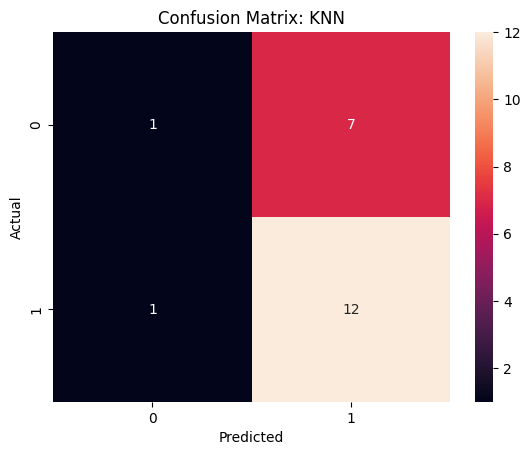

Accuracy for KNN: 0.6190476190476191

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.50      0.12      0.20         8
           1       0.63      0.92      0.75        13

    accuracy                           0.62        21
   macro avg       0.57      0.52      0.47        21
weighted avg       0.58      0.62      0.54        21



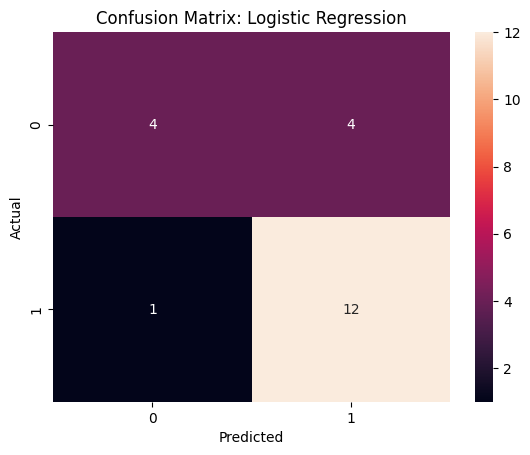

Accuracy for Logistic Regression: 0.7619047619047619

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.75      0.92      0.83        13

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weighted avg       0.77      0.76      0.75        21



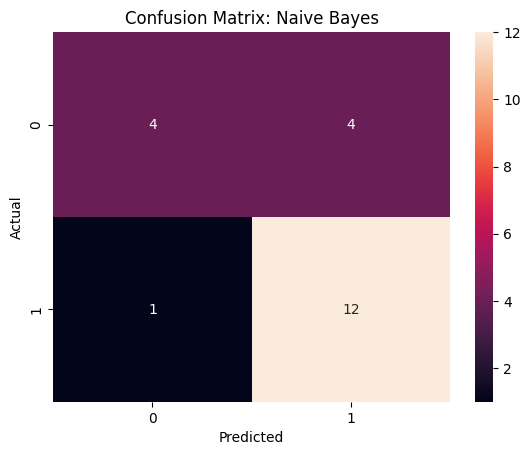

Accuracy for Naive Bayes: 0.7619047619047619

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.75      0.92      0.83        13

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weighted avg       0.77      0.76      0.75        21



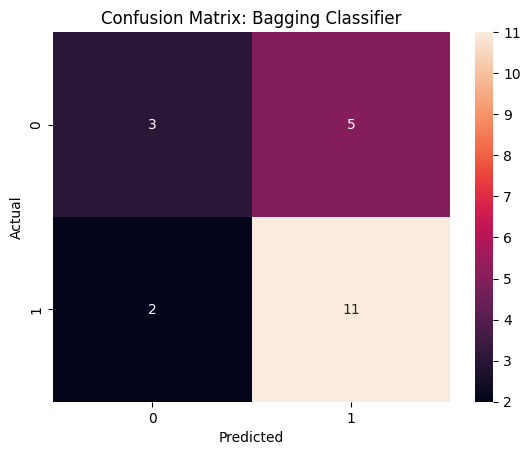

Accuracy for Bagging Classifier: 0.6666666666666666

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.69      0.85      0.76        13

    accuracy                           0.67        21
   macro avg       0.64      0.61      0.61        21
weighted avg       0.65      0.67      0.65        21



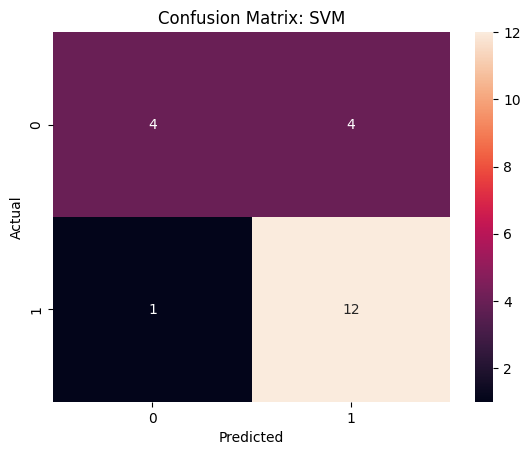

Accuracy for SVM: 0.7619047619047619

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.75      0.92      0.83        13

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weighted avg       0.77      0.76      0.75        21



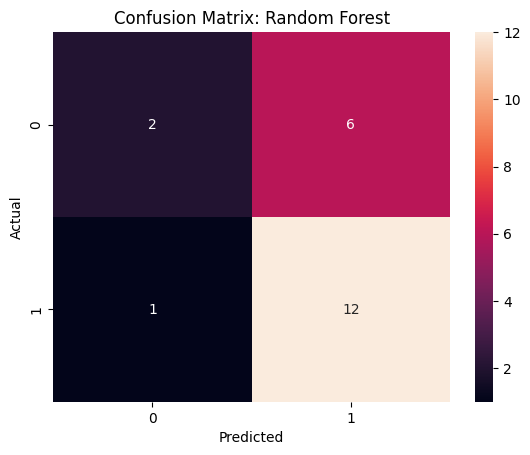

Accuracy for Random Forest: 0.6666666666666666

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.67      0.92      0.77        13

    accuracy                           0.67        21
   macro avg       0.67      0.59      0.57        21
weighted avg       0.67      0.67      0.62        21



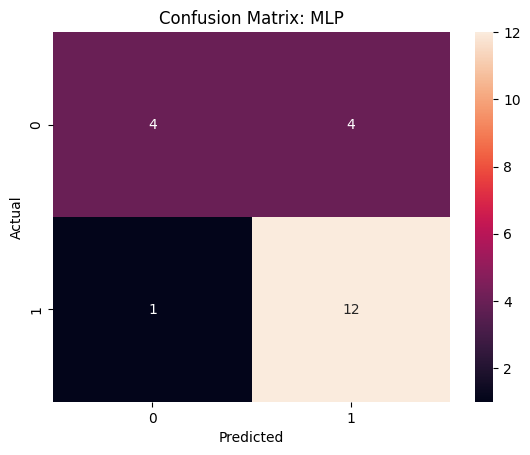

Accuracy for MLP: 0.7619047619047619

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.75      0.92      0.83        13

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weighted avg       0.77      0.76      0.75        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


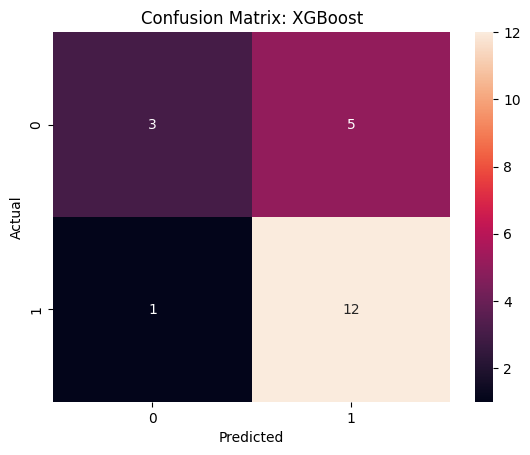

Accuracy for XGBoost: 0.7142857142857143

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.71      0.92      0.80        13

    accuracy                           0.71        21
   macro avg       0.73      0.65      0.65        21
weighted avg       0.72      0.71      0.69        21



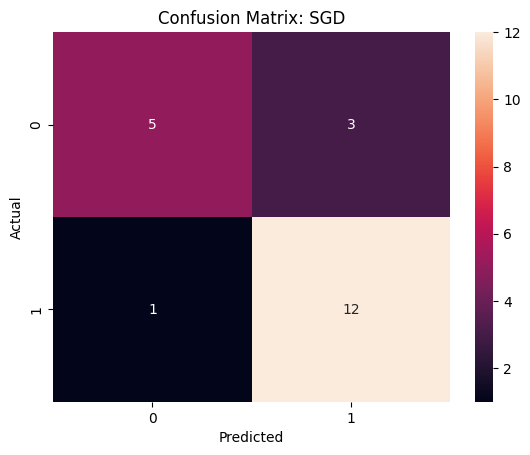

Accuracy for SGD: 0.8095238095238095

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.80      0.92      0.86        13

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21



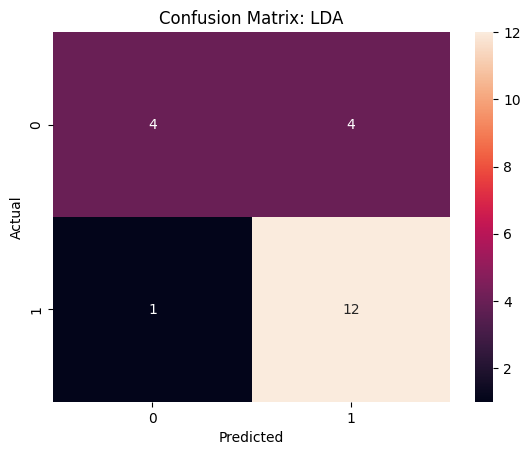

Accuracy for LDA: 0.7619047619047619

Classification Report for LDA:
               precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.75      0.92      0.83        13

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weighted avg       0.77      0.76      0.75        21

Iteration 2/10


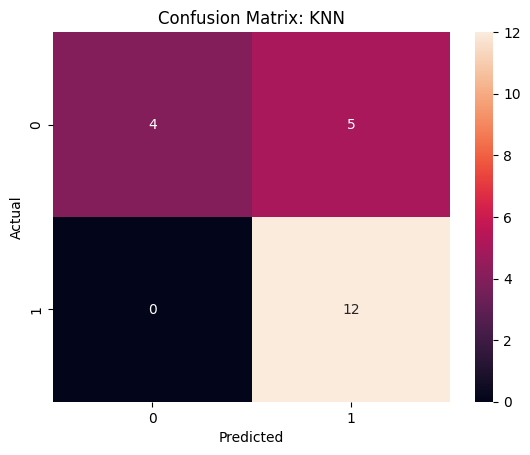

Accuracy for KNN: 0.7619047619047619

Classification Report for KNN:
               precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.71      1.00      0.83        12

    accuracy                           0.76        21
   macro avg       0.85      0.72      0.72        21
weighted avg       0.83      0.76      0.74        21



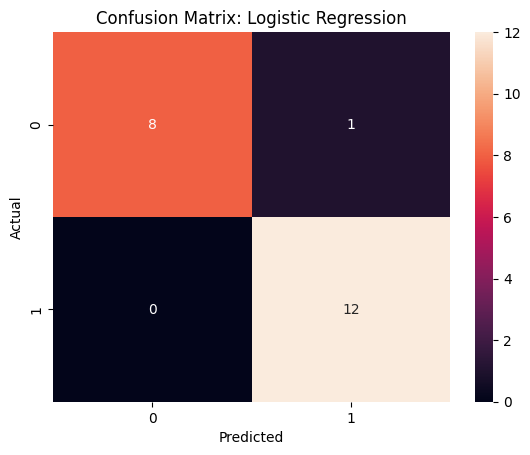

Accuracy for Logistic Regression: 0.9523809523809523

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.92      1.00      0.96        12

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21



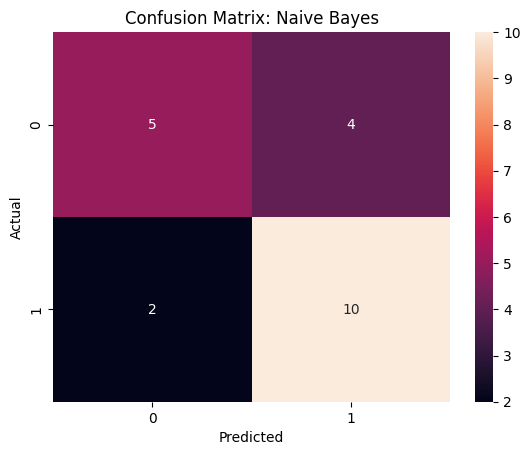

Accuracy for Naive Bayes: 0.7142857142857143

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.71      0.56      0.62         9
           1       0.71      0.83      0.77        12

    accuracy                           0.71        21
   macro avg       0.71      0.69      0.70        21
weighted avg       0.71      0.71      0.71        21



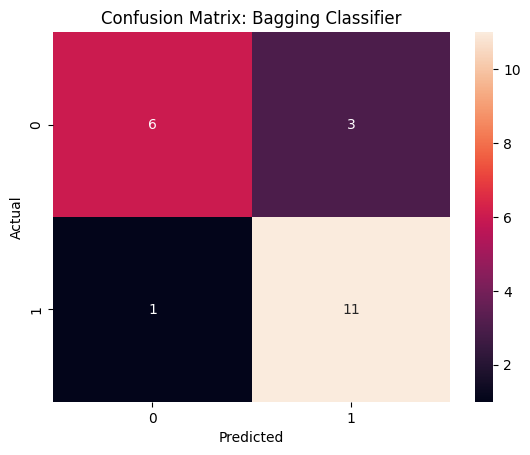

Accuracy for Bagging Classifier: 0.8095238095238095

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.79      0.92      0.85        12

    accuracy                           0.81        21
   macro avg       0.82      0.79      0.80        21
weighted avg       0.82      0.81      0.80        21



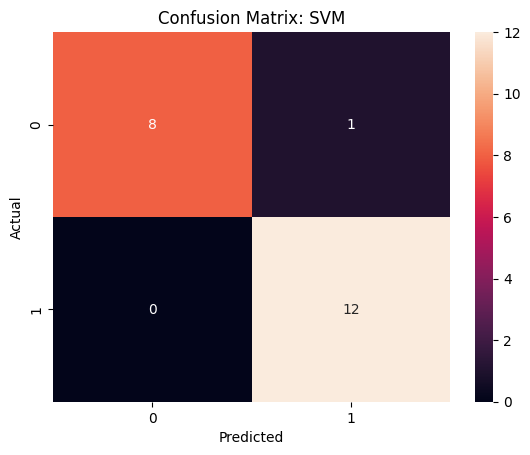

Accuracy for SVM: 0.9523809523809523

Classification Report for SVM:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.92      1.00      0.96        12

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21



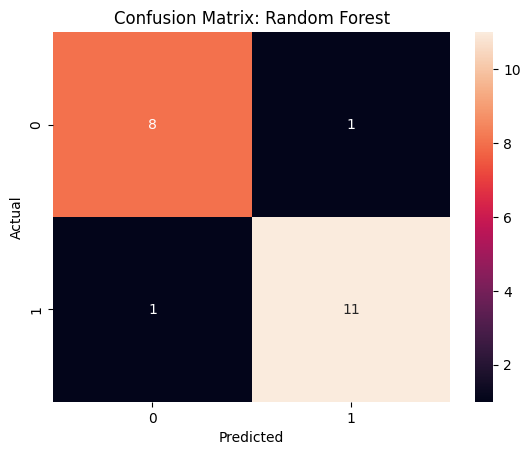

Accuracy for Random Forest: 0.9047619047619048

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.92      0.92      0.92        12

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



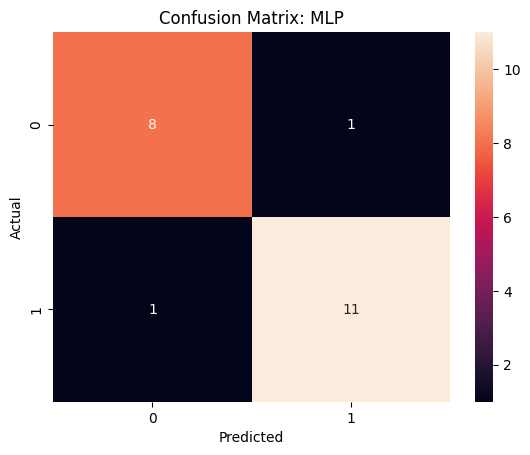

Accuracy for MLP: 0.9047619047619048

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.92      0.92      0.92        12

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


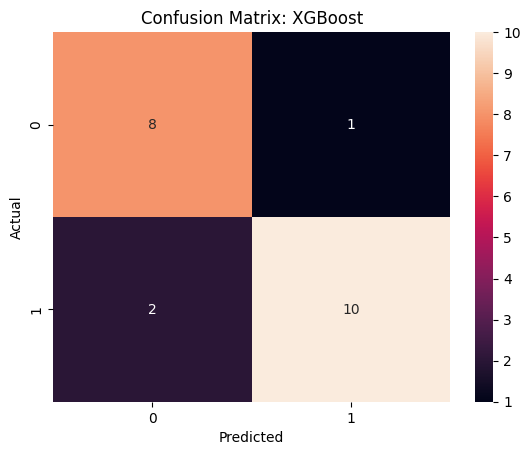

Accuracy for XGBoost: 0.8571428571428571

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.91      0.83      0.87        12

    accuracy                           0.86        21
   macro avg       0.85      0.86      0.86        21
weighted avg       0.86      0.86      0.86        21



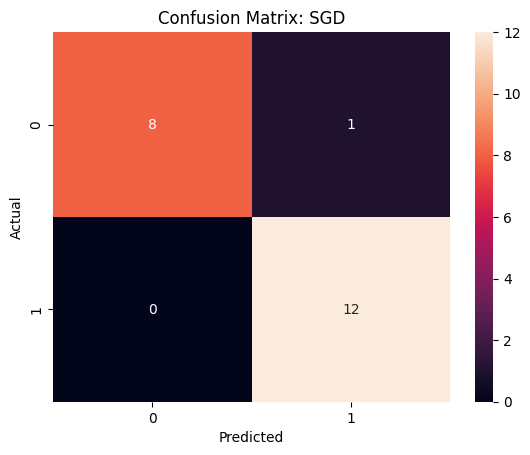

Accuracy for SGD: 0.9523809523809523

Classification Report for SGD:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.92      1.00      0.96        12

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21



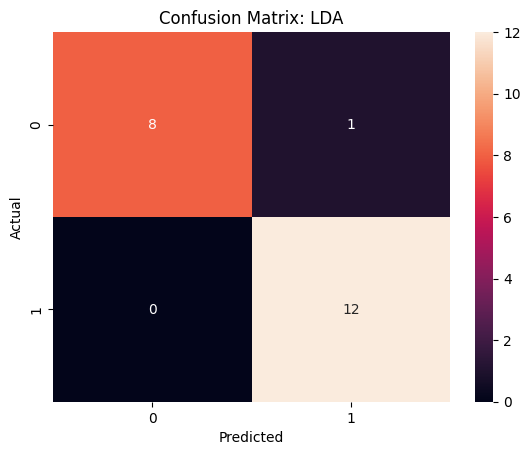

Accuracy for LDA: 0.9523809523809523

Classification Report for LDA:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.92      1.00      0.96        12

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21

Iteration 3/10


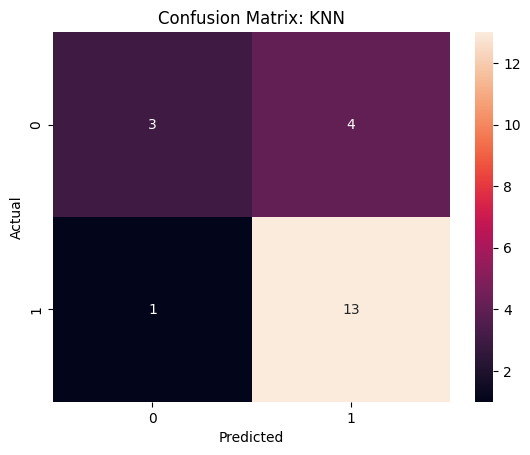

Accuracy for KNN: 0.7619047619047619

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.76      0.93      0.84        14

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21



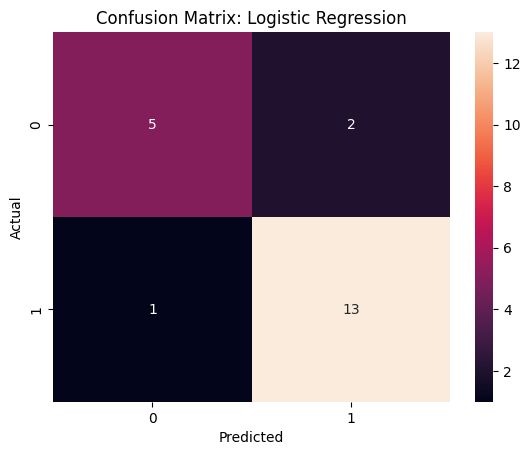

Accuracy for Logistic Regression: 0.8571428571428571

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.87      0.93      0.90        14

    accuracy                           0.86        21
   macro avg       0.85      0.82      0.83        21
weighted avg       0.86      0.86      0.85        21



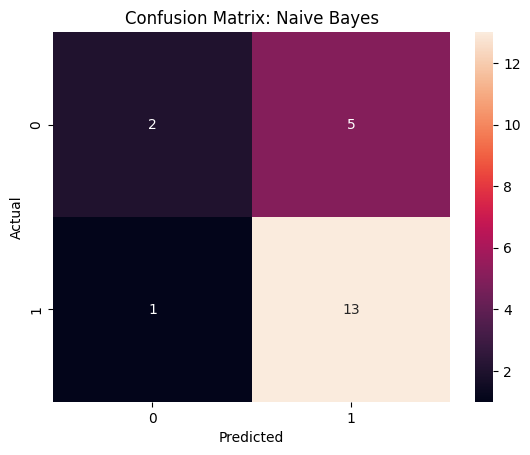

Accuracy for Naive Bayes: 0.7142857142857143

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.72      0.93      0.81        14

    accuracy                           0.71        21
   macro avg       0.69      0.61      0.61        21
weighted avg       0.70      0.71      0.68        21



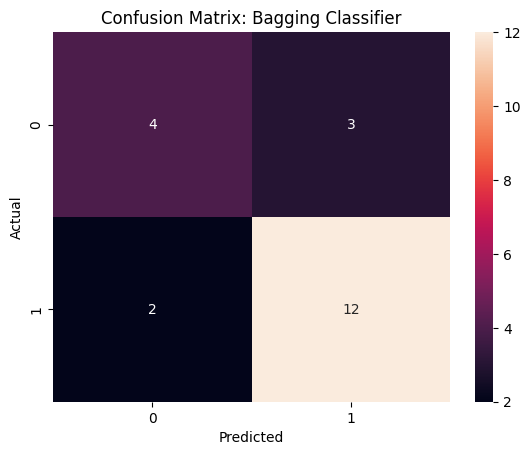

Accuracy for Bagging Classifier: 0.7619047619047619

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.80      0.86      0.83        14

    accuracy                           0.76        21
   macro avg       0.73      0.71      0.72        21
weighted avg       0.76      0.76      0.76        21



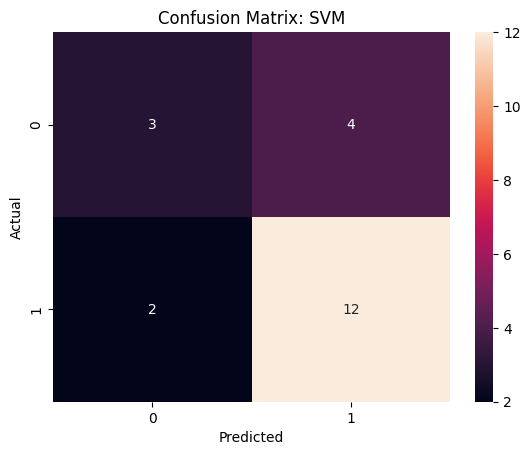

Accuracy for SVM: 0.7142857142857143

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.75      0.86      0.80        14

    accuracy                           0.71        21
   macro avg       0.68      0.64      0.65        21
weighted avg       0.70      0.71      0.70        21



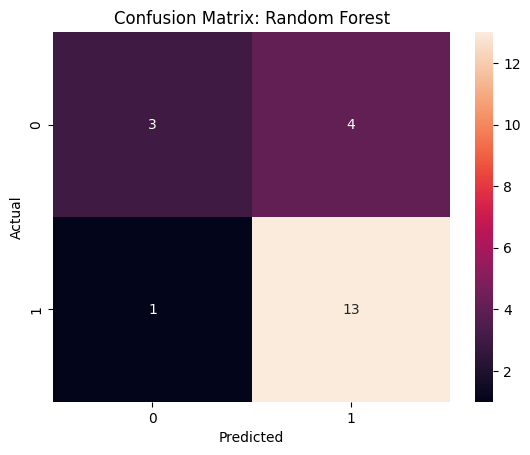

Accuracy for Random Forest: 0.7619047619047619

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.76      0.93      0.84        14

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21



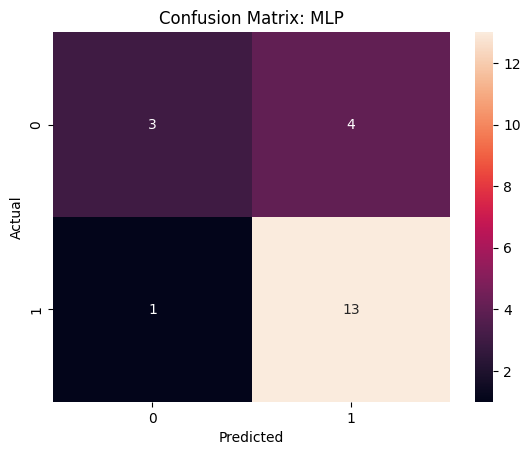

Accuracy for MLP: 0.7619047619047619

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.76      0.93      0.84        14

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


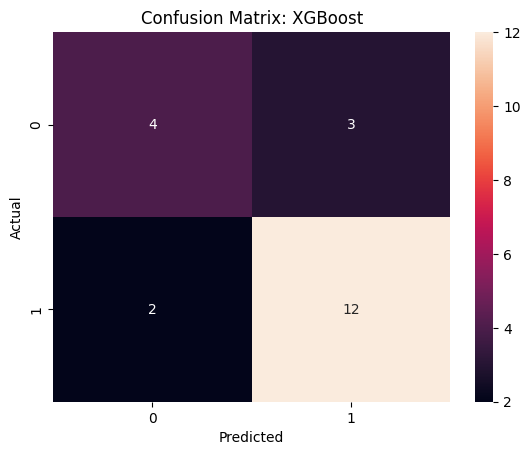

Accuracy for XGBoost: 0.7619047619047619

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.80      0.86      0.83        14

    accuracy                           0.76        21
   macro avg       0.73      0.71      0.72        21
weighted avg       0.76      0.76      0.76        21



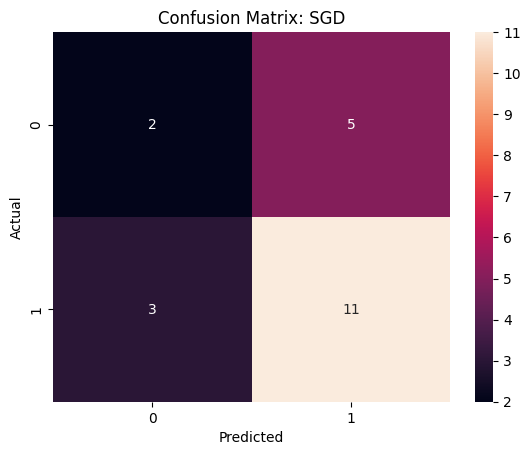

Accuracy for SGD: 0.6190476190476191

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.40      0.29      0.33         7
           1       0.69      0.79      0.73        14

    accuracy                           0.62        21
   macro avg       0.54      0.54      0.53        21
weighted avg       0.59      0.62      0.60        21



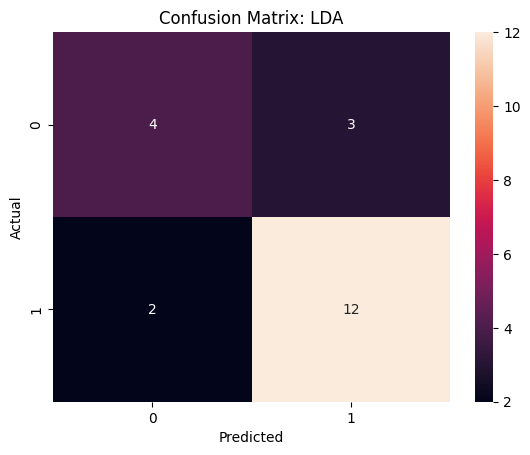

Accuracy for LDA: 0.7619047619047619

Classification Report for LDA:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.80      0.86      0.83        14

    accuracy                           0.76        21
   macro avg       0.73      0.71      0.72        21
weighted avg       0.76      0.76      0.76        21

Iteration 4/10


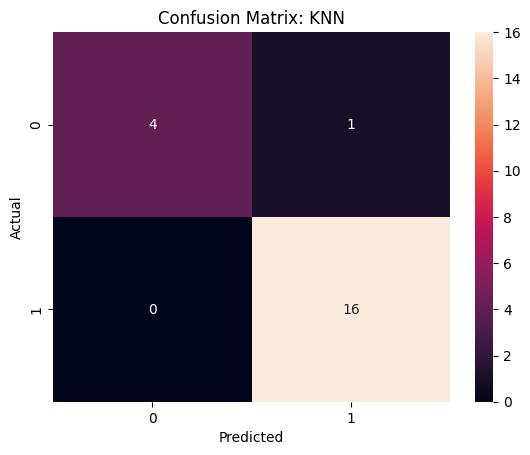

Accuracy for KNN: 0.9523809523809523

Classification Report for KNN:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.94      1.00      0.97        16

    accuracy                           0.95        21
   macro avg       0.97      0.90      0.93        21
weighted avg       0.96      0.95      0.95        21



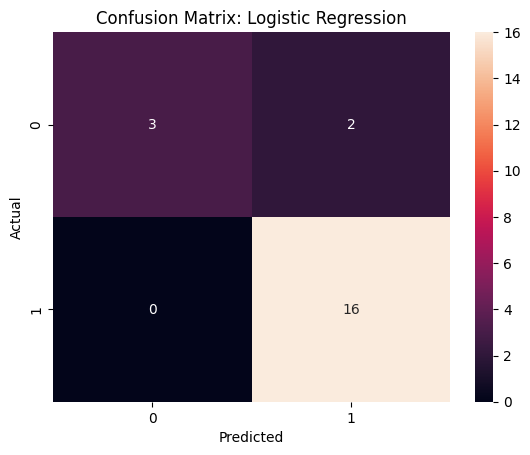

Accuracy for Logistic Regression: 0.9047619047619048

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.89      1.00      0.94        16

    accuracy                           0.90        21
   macro avg       0.94      0.80      0.85        21
weighted avg       0.92      0.90      0.90        21



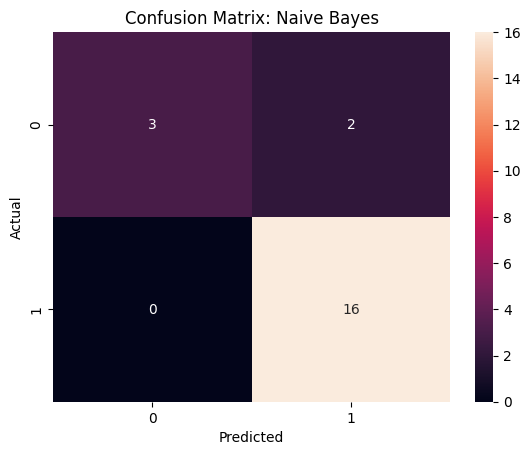

Accuracy for Naive Bayes: 0.9047619047619048

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.89      1.00      0.94        16

    accuracy                           0.90        21
   macro avg       0.94      0.80      0.85        21
weighted avg       0.92      0.90      0.90        21



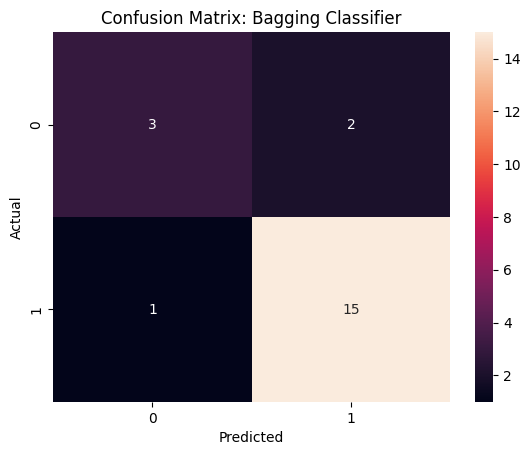

Accuracy for Bagging Classifier: 0.8571428571428571

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.94      0.91        16

    accuracy                           0.86        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.85      0.86      0.85        21



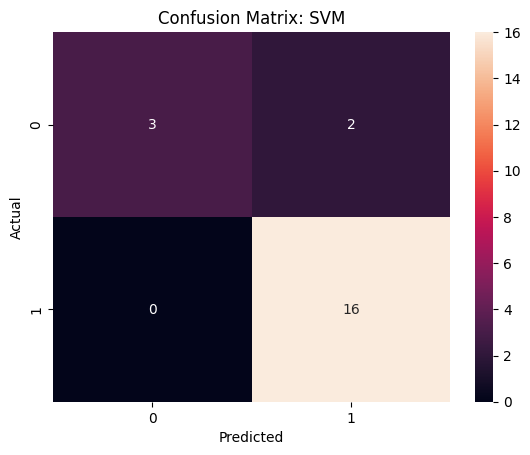

Accuracy for SVM: 0.9047619047619048

Classification Report for SVM:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.89      1.00      0.94        16

    accuracy                           0.90        21
   macro avg       0.94      0.80      0.85        21
weighted avg       0.92      0.90      0.90        21



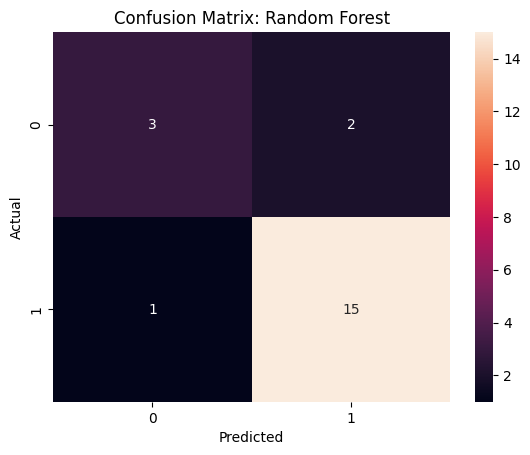

Accuracy for Random Forest: 0.8571428571428571

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.94      0.91        16

    accuracy                           0.86        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.85      0.86      0.85        21



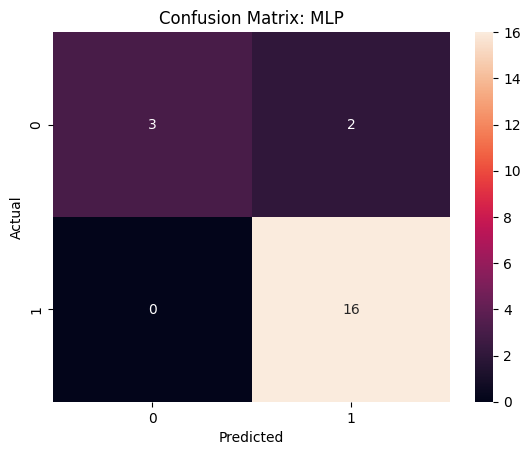

Accuracy for MLP: 0.9047619047619048

Classification Report for MLP:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.89      1.00      0.94        16

    accuracy                           0.90        21
   macro avg       0.94      0.80      0.85        21
weighted avg       0.92      0.90      0.90        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


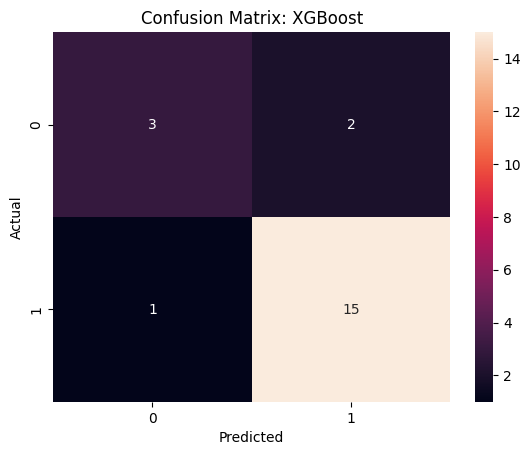

Accuracy for XGBoost: 0.8571428571428571

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.94      0.91        16

    accuracy                           0.86        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.85      0.86      0.85        21



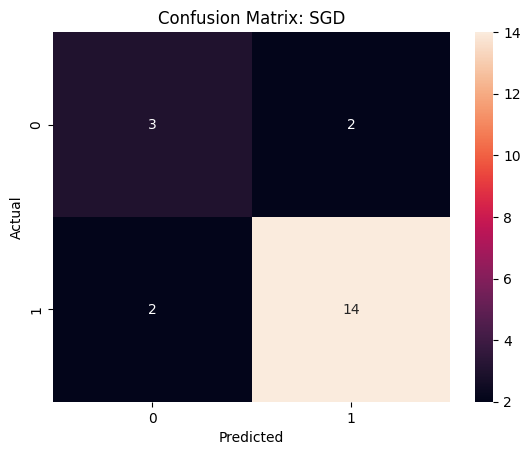

Accuracy for SGD: 0.8095238095238095

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.88      0.88      0.88        16

    accuracy                           0.81        21
   macro avg       0.74      0.74      0.74        21
weighted avg       0.81      0.81      0.81        21



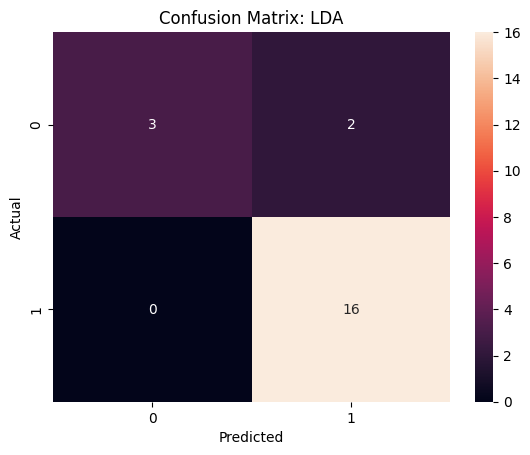

Accuracy for LDA: 0.9047619047619048

Classification Report for LDA:
               precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.89      1.00      0.94        16

    accuracy                           0.90        21
   macro avg       0.94      0.80      0.85        21
weighted avg       0.92      0.90      0.90        21

Iteration 5/10


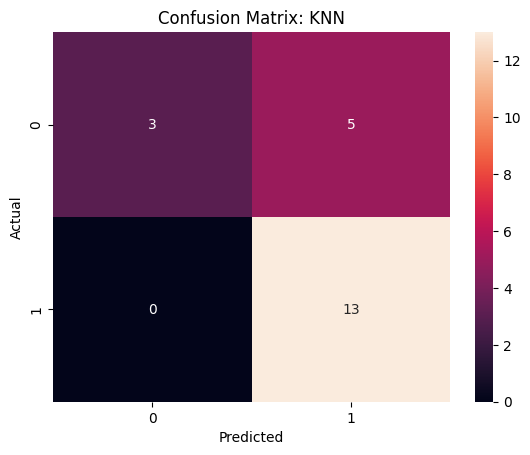

Accuracy for KNN: 0.7619047619047619

Classification Report for KNN:
               precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.72      1.00      0.84        13

    accuracy                           0.76        21
   macro avg       0.86      0.69      0.69        21
weighted avg       0.83      0.76      0.73        21



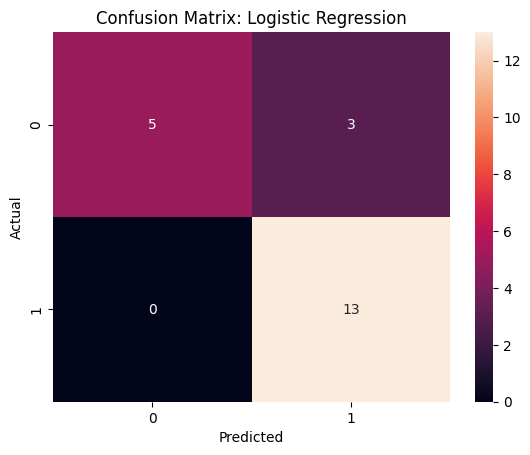

Accuracy for Logistic Regression: 0.8571428571428571

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.81      1.00      0.90        13

    accuracy                           0.86        21
   macro avg       0.91      0.81      0.83        21
weighted avg       0.88      0.86      0.85        21



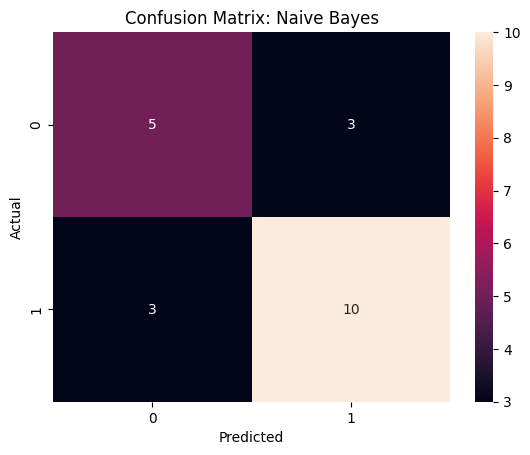

Accuracy for Naive Bayes: 0.7142857142857143

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.77      0.77      0.77        13

    accuracy                           0.71        21
   macro avg       0.70      0.70      0.70        21
weighted avg       0.71      0.71      0.71        21



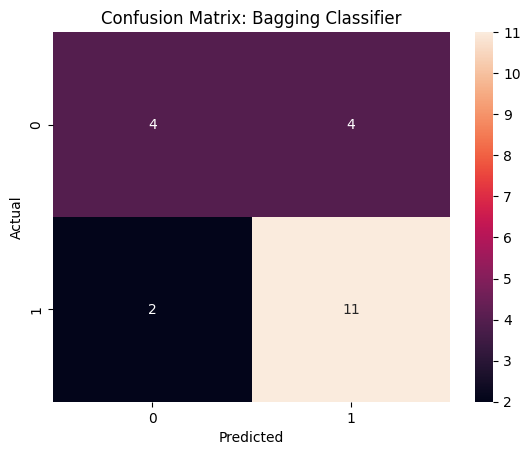

Accuracy for Bagging Classifier: 0.7142857142857143

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.73      0.85      0.79        13

    accuracy                           0.71        21
   macro avg       0.70      0.67      0.68        21
weighted avg       0.71      0.71      0.70        21



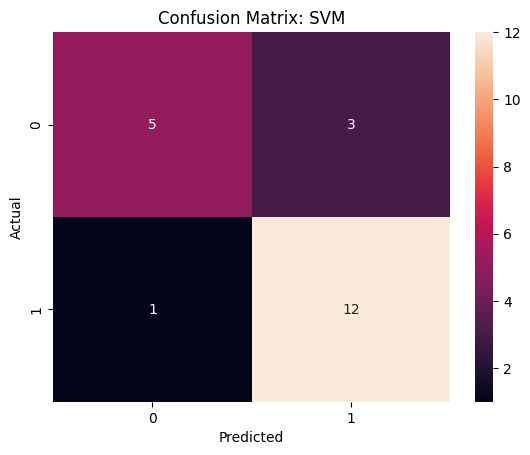

Accuracy for SVM: 0.8095238095238095

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.80      0.92      0.86        13

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21



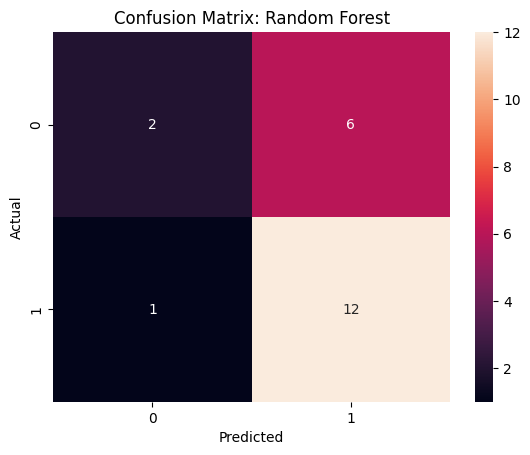

Accuracy for Random Forest: 0.6666666666666666

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.67      0.92      0.77        13

    accuracy                           0.67        21
   macro avg       0.67      0.59      0.57        21
weighted avg       0.67      0.67      0.62        21



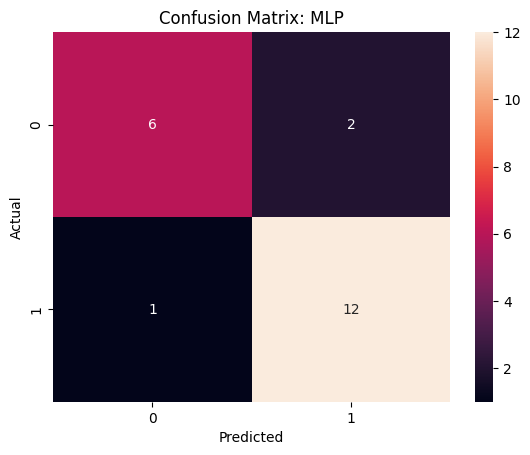

Accuracy for MLP: 0.8571428571428571

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.86      0.92      0.89        13

    accuracy                           0.86        21
   macro avg       0.86      0.84      0.84        21
weighted avg       0.86      0.86      0.86        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


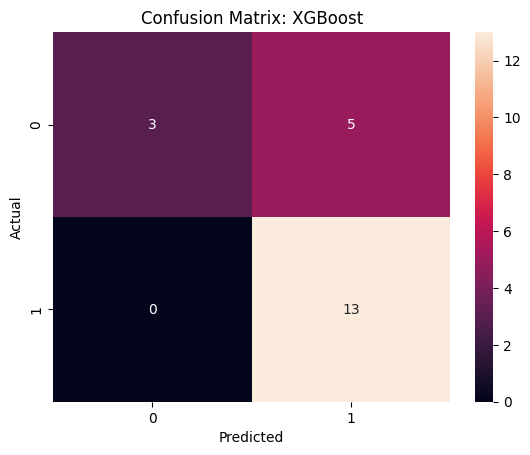

Accuracy for XGBoost: 0.7619047619047619

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.72      1.00      0.84        13

    accuracy                           0.76        21
   macro avg       0.86      0.69      0.69        21
weighted avg       0.83      0.76      0.73        21



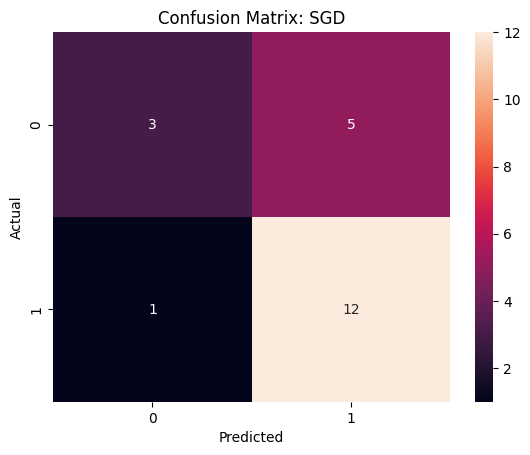

Accuracy for SGD: 0.7142857142857143

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.71      0.92      0.80        13

    accuracy                           0.71        21
   macro avg       0.73      0.65      0.65        21
weighted avg       0.72      0.71      0.69        21



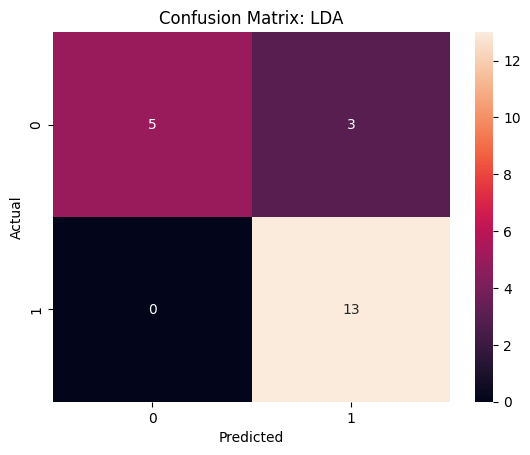

Accuracy for LDA: 0.8571428571428571

Classification Report for LDA:
               precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.81      1.00      0.90        13

    accuracy                           0.86        21
   macro avg       0.91      0.81      0.83        21
weighted avg       0.88      0.86      0.85        21

Iteration 6/10


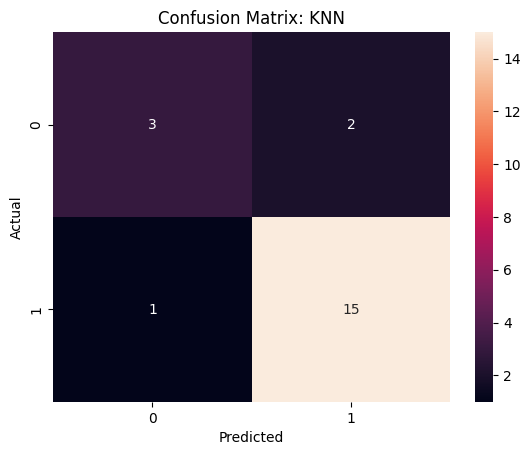

Accuracy for KNN: 0.8571428571428571

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.94      0.91        16

    accuracy                           0.86        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.85      0.86      0.85        21



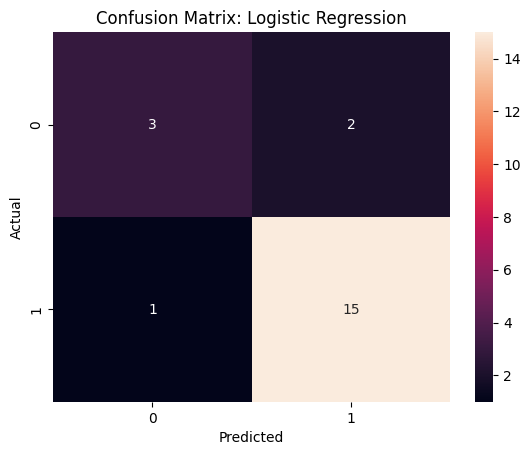

Accuracy for Logistic Regression: 0.8571428571428571

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.94      0.91        16

    accuracy                           0.86        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.85      0.86      0.85        21



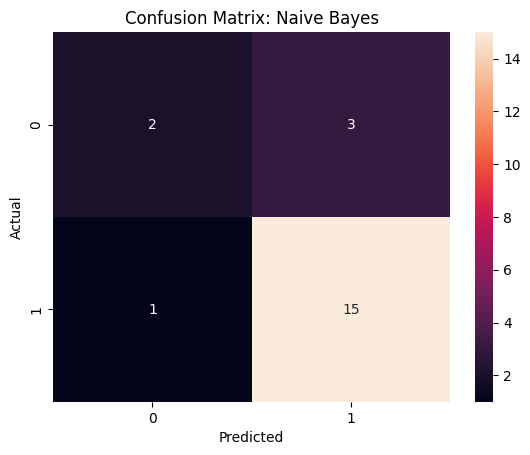

Accuracy for Naive Bayes: 0.8095238095238095

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.83      0.94      0.88        16

    accuracy                           0.81        21
   macro avg       0.75      0.67      0.69        21
weighted avg       0.79      0.81      0.79        21



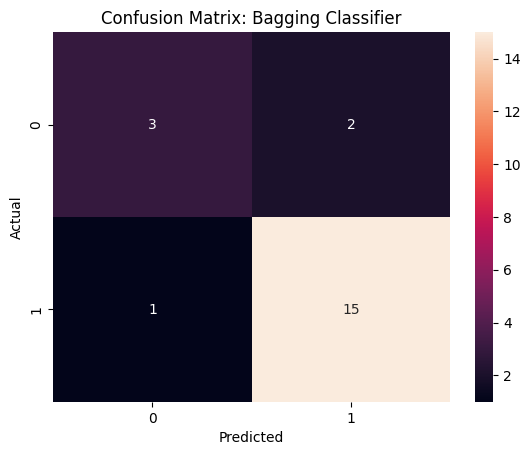

Accuracy for Bagging Classifier: 0.8571428571428571

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.94      0.91        16

    accuracy                           0.86        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.85      0.86      0.85        21



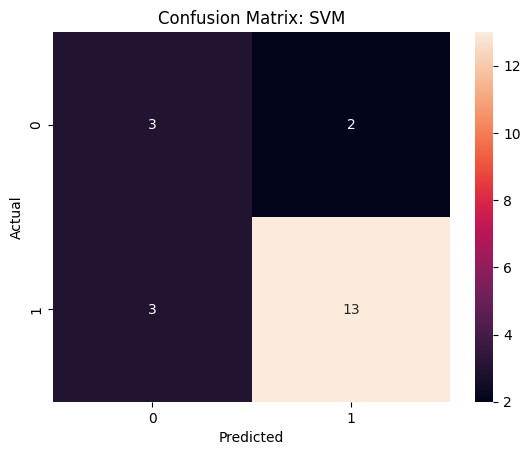

Accuracy for SVM: 0.7619047619047619

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.87      0.81      0.84        16

    accuracy                           0.76        21
   macro avg       0.68      0.71      0.69        21
weighted avg       0.78      0.76      0.77        21



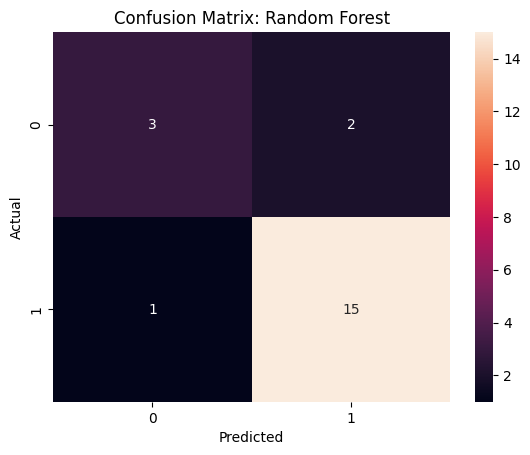

Accuracy for Random Forest: 0.8571428571428571

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.94      0.91        16

    accuracy                           0.86        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.85      0.86      0.85        21



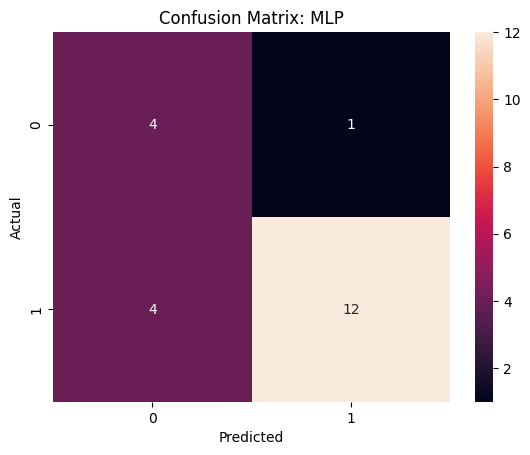

Accuracy for MLP: 0.7619047619047619

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62         5
           1       0.92      0.75      0.83        16

    accuracy                           0.76        21
   macro avg       0.71      0.78      0.72        21
weighted avg       0.82      0.76      0.78        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


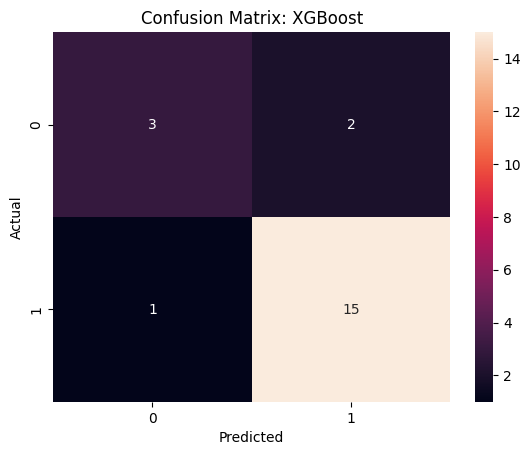

Accuracy for XGBoost: 0.8571428571428571

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.88      0.94      0.91        16

    accuracy                           0.86        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.85      0.86      0.85        21



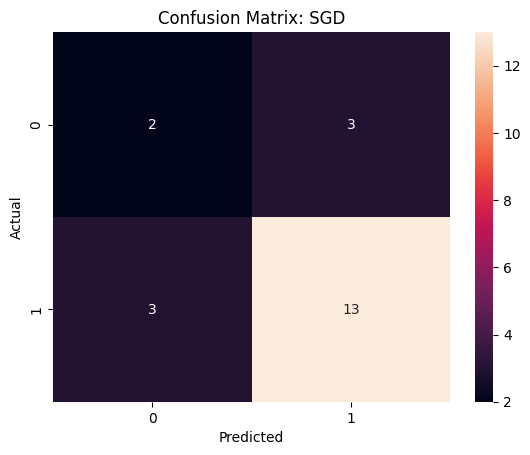

Accuracy for SGD: 0.7142857142857143

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.81      0.81      0.81        16

    accuracy                           0.71        21
   macro avg       0.61      0.61      0.61        21
weighted avg       0.71      0.71      0.71        21



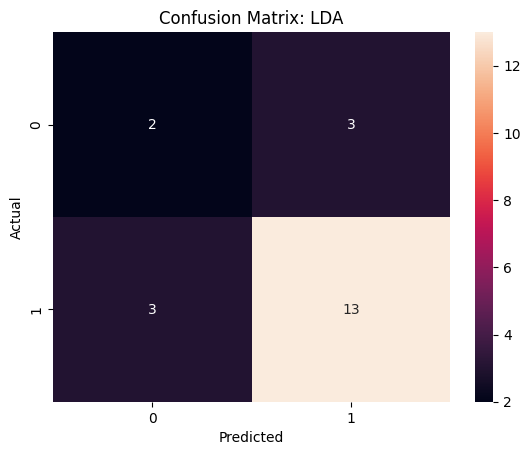

Accuracy for LDA: 0.7142857142857143

Classification Report for LDA:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.81      0.81      0.81        16

    accuracy                           0.71        21
   macro avg       0.61      0.61      0.61        21
weighted avg       0.71      0.71      0.71        21

Iteration 7/10


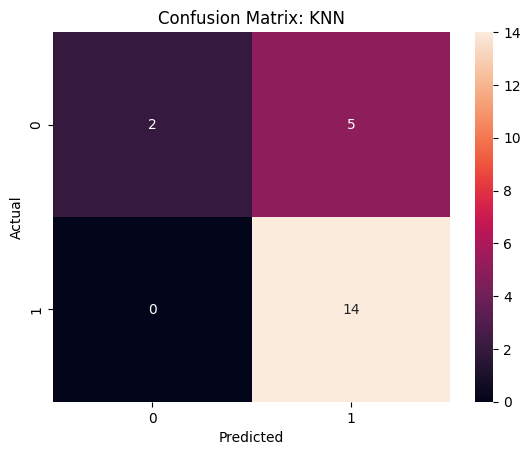

Accuracy for KNN: 0.7619047619047619

Classification Report for KNN:
               precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.74      1.00      0.85        14

    accuracy                           0.76        21
   macro avg       0.87      0.64      0.65        21
weighted avg       0.82      0.76      0.71        21



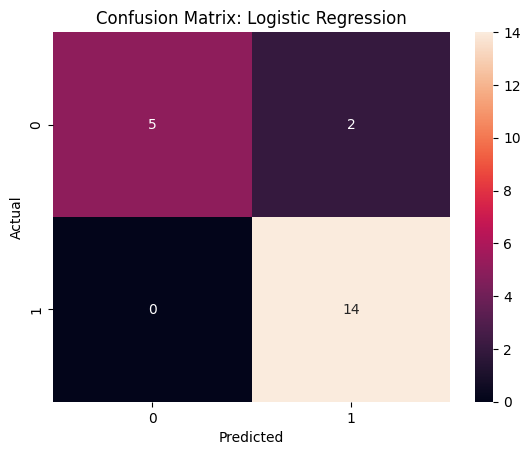

Accuracy for Logistic Regression: 0.9047619047619048

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.88      1.00      0.93        14

    accuracy                           0.90        21
   macro avg       0.94      0.86      0.88        21
weighted avg       0.92      0.90      0.90        21



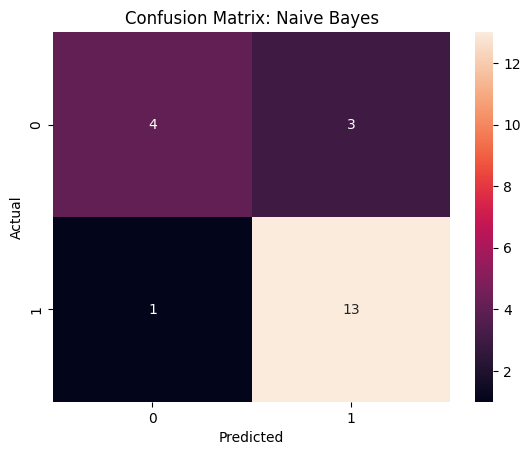

Accuracy for Naive Bayes: 0.8095238095238095

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.81      0.93      0.87        14

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21



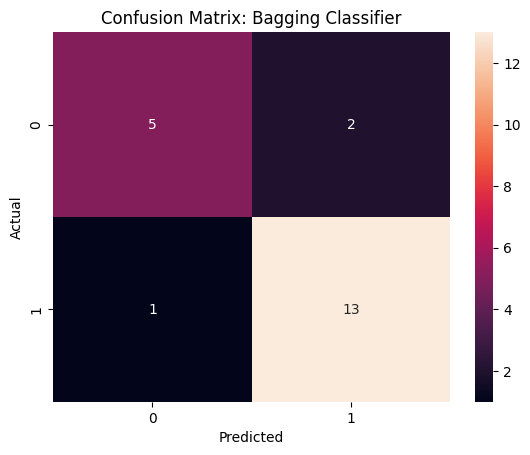

Accuracy for Bagging Classifier: 0.8571428571428571

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.87      0.93      0.90        14

    accuracy                           0.86        21
   macro avg       0.85      0.82      0.83        21
weighted avg       0.86      0.86      0.85        21



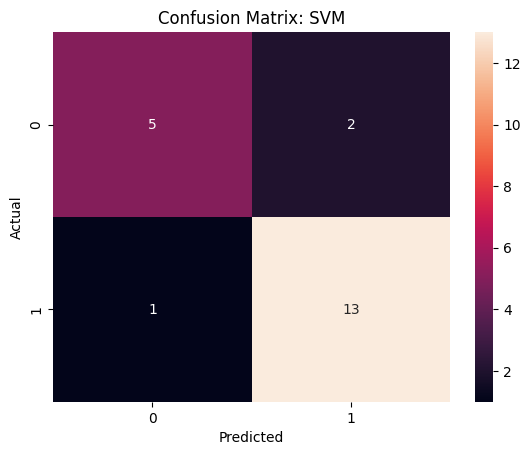

Accuracy for SVM: 0.8571428571428571

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.87      0.93      0.90        14

    accuracy                           0.86        21
   macro avg       0.85      0.82      0.83        21
weighted avg       0.86      0.86      0.85        21



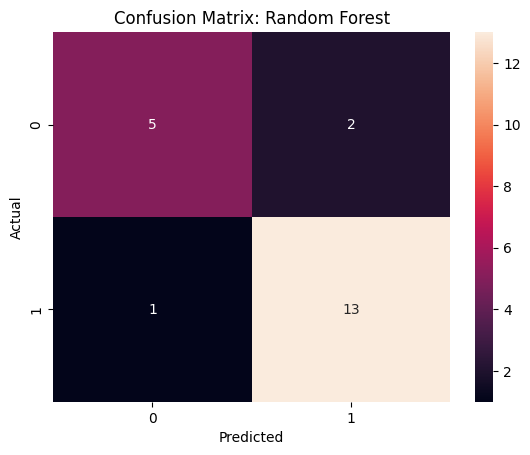

Accuracy for Random Forest: 0.8571428571428571

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.87      0.93      0.90        14

    accuracy                           0.86        21
   macro avg       0.85      0.82      0.83        21
weighted avg       0.86      0.86      0.85        21



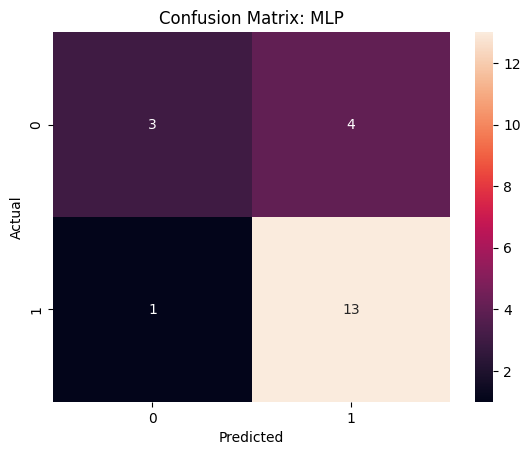

Accuracy for MLP: 0.7619047619047619

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.76      0.93      0.84        14

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:09:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


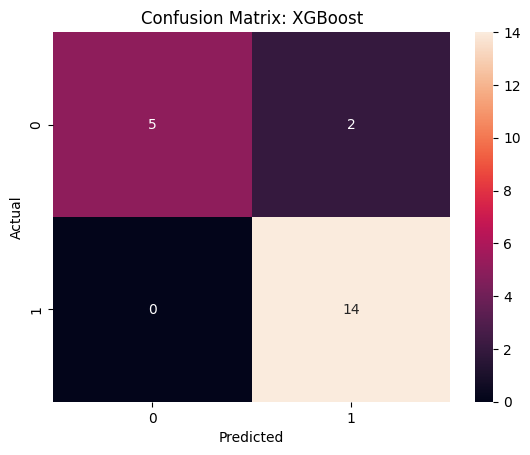

Accuracy for XGBoost: 0.9047619047619048

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.88      1.00      0.93        14

    accuracy                           0.90        21
   macro avg       0.94      0.86      0.88        21
weighted avg       0.92      0.90      0.90        21



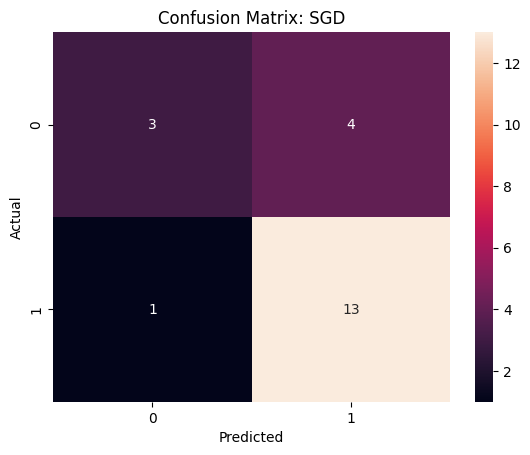

Accuracy for SGD: 0.7619047619047619

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.76      0.93      0.84        14

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21



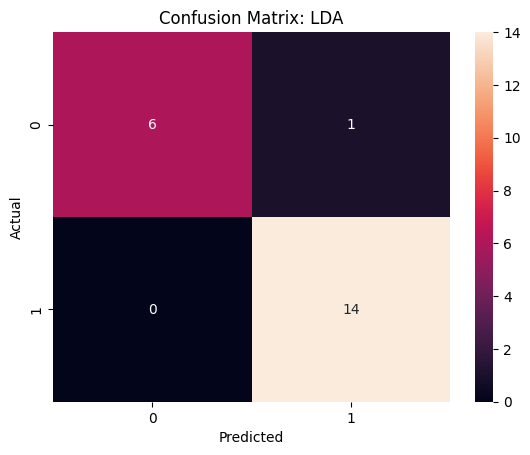

Accuracy for LDA: 0.9523809523809523

Classification Report for LDA:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.93      1.00      0.97        14

    accuracy                           0.95        21
   macro avg       0.97      0.93      0.94        21
weighted avg       0.96      0.95      0.95        21

Iteration 8/10


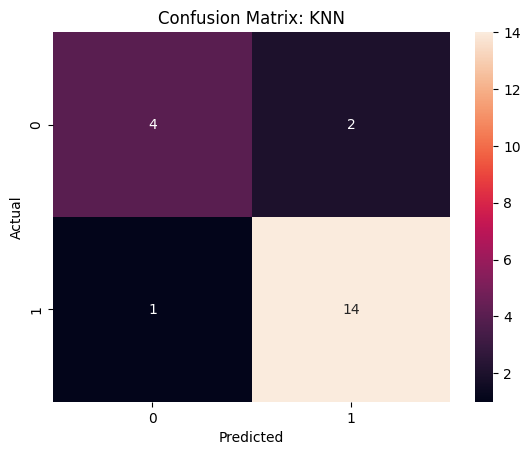

Accuracy for KNN: 0.8571428571428571

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.88      0.93      0.90        15

    accuracy                           0.86        21
   macro avg       0.84      0.80      0.82        21
weighted avg       0.85      0.86      0.85        21



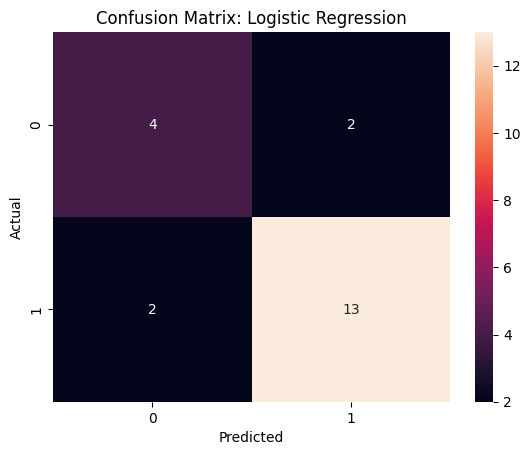

Accuracy for Logistic Regression: 0.8095238095238095

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.87      0.87      0.87        15

    accuracy                           0.81        21
   macro avg       0.77      0.77      0.77        21
weighted avg       0.81      0.81      0.81        21



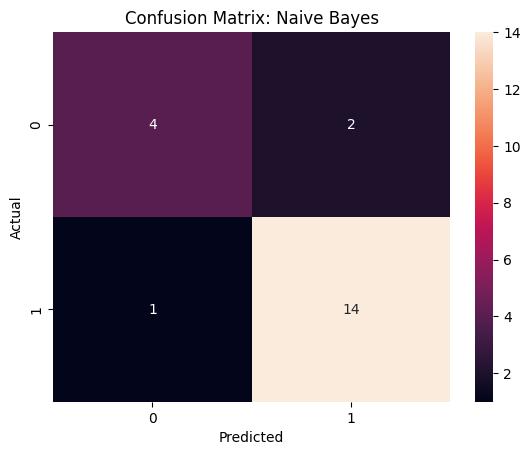

Accuracy for Naive Bayes: 0.8571428571428571

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.88      0.93      0.90        15

    accuracy                           0.86        21
   macro avg       0.84      0.80      0.82        21
weighted avg       0.85      0.86      0.85        21



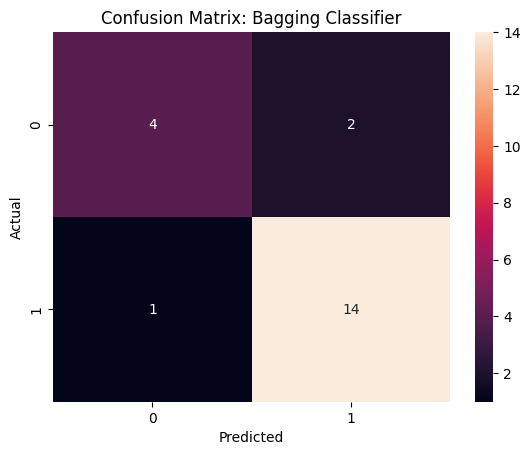

Accuracy for Bagging Classifier: 0.8571428571428571

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.88      0.93      0.90        15

    accuracy                           0.86        21
   macro avg       0.84      0.80      0.82        21
weighted avg       0.85      0.86      0.85        21



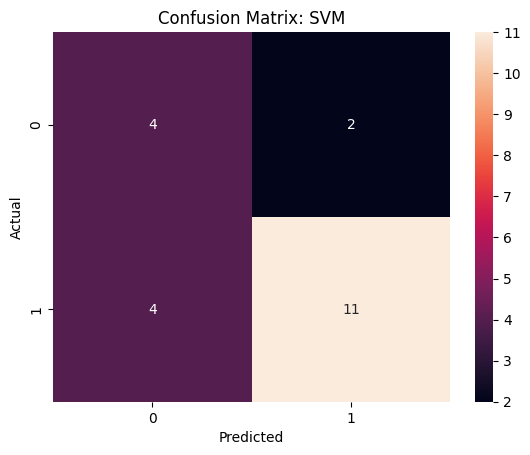

Accuracy for SVM: 0.7142857142857143

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.85      0.73      0.79        15

    accuracy                           0.71        21
   macro avg       0.67      0.70      0.68        21
weighted avg       0.75      0.71      0.72        21



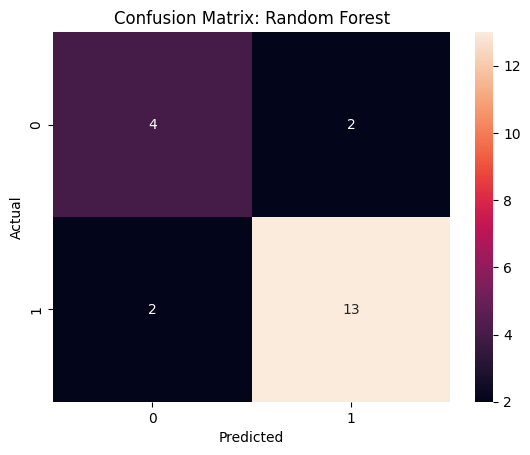

Accuracy for Random Forest: 0.8095238095238095

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.87      0.87      0.87        15

    accuracy                           0.81        21
   macro avg       0.77      0.77      0.77        21
weighted avg       0.81      0.81      0.81        21



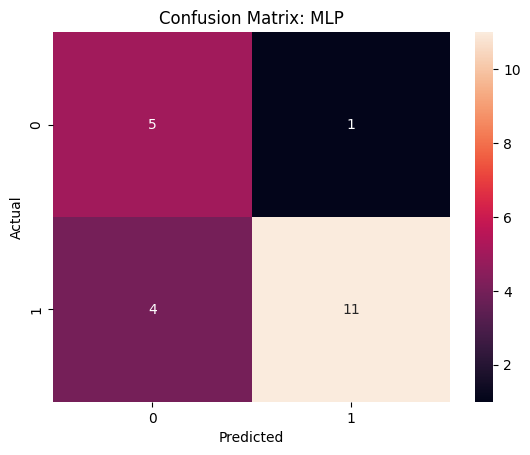

Accuracy for MLP: 0.7619047619047619

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.92      0.73      0.81        15

    accuracy                           0.76        21
   macro avg       0.74      0.78      0.74        21
weighted avg       0.81      0.76      0.77        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:10:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


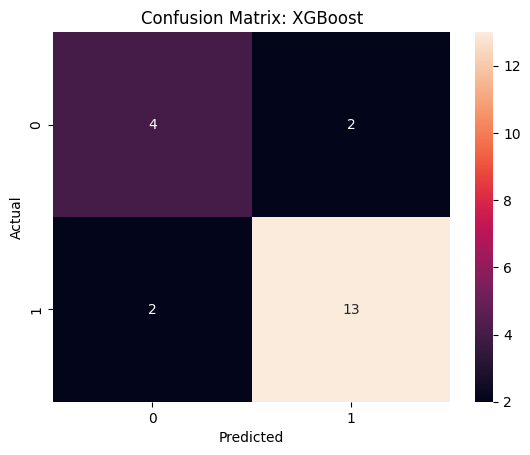

Accuracy for XGBoost: 0.8095238095238095

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.87      0.87      0.87        15

    accuracy                           0.81        21
   macro avg       0.77      0.77      0.77        21
weighted avg       0.81      0.81      0.81        21



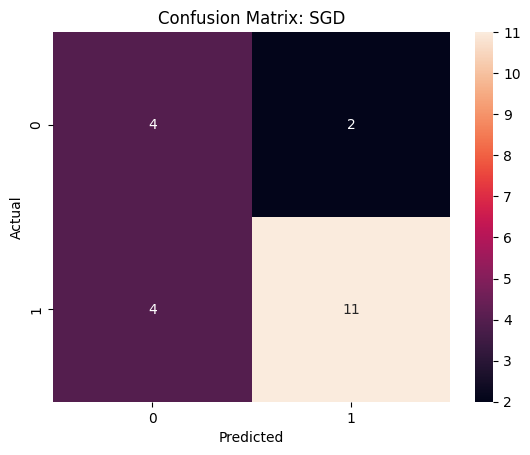

Accuracy for SGD: 0.7142857142857143

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.85      0.73      0.79        15

    accuracy                           0.71        21
   macro avg       0.67      0.70      0.68        21
weighted avg       0.75      0.71      0.72        21



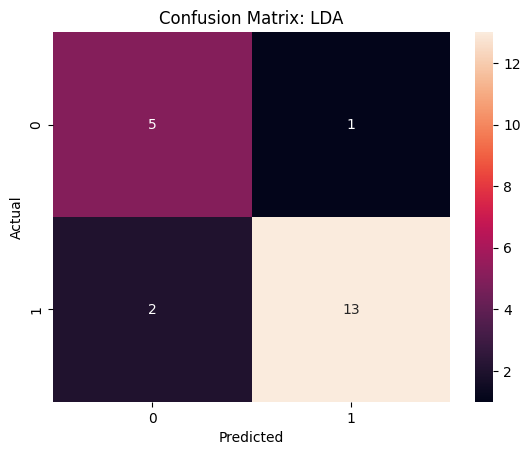

Accuracy for LDA: 0.8571428571428571

Classification Report for LDA:
               precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.93      0.87      0.90        15

    accuracy                           0.86        21
   macro avg       0.82      0.85      0.83        21
weighted avg       0.87      0.86      0.86        21

Iteration 9/10


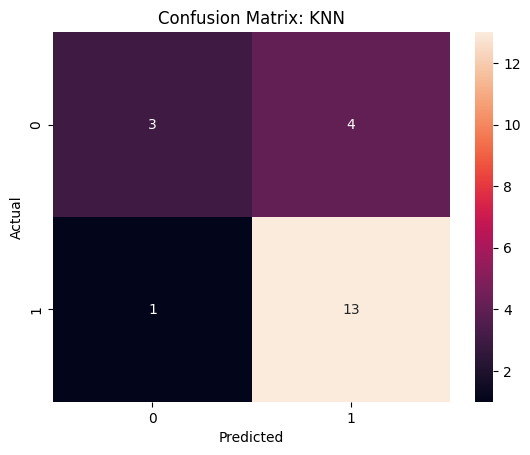

Accuracy for KNN: 0.7619047619047619

Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.76      0.93      0.84        14

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21



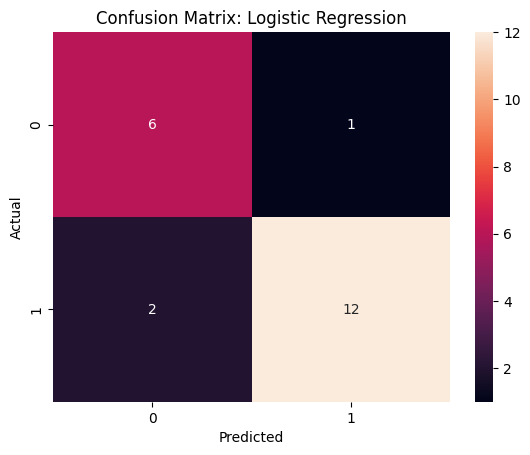

Accuracy for Logistic Regression: 0.8571428571428571

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21



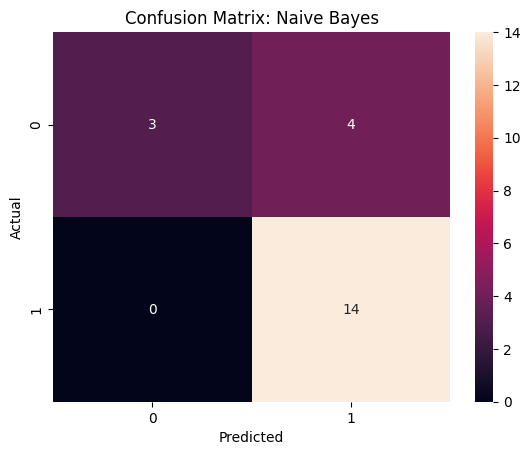

Accuracy for Naive Bayes: 0.8095238095238095

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.78      1.00      0.88        14

    accuracy                           0.81        21
   macro avg       0.89      0.71      0.74        21
weighted avg       0.85      0.81      0.78        21



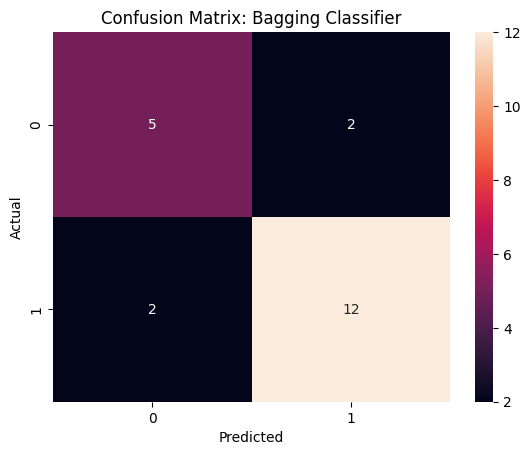

Accuracy for Bagging Classifier: 0.8095238095238095

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       0.86      0.86      0.86        14

    accuracy                           0.81        21
   macro avg       0.79      0.79      0.79        21
weighted avg       0.81      0.81      0.81        21



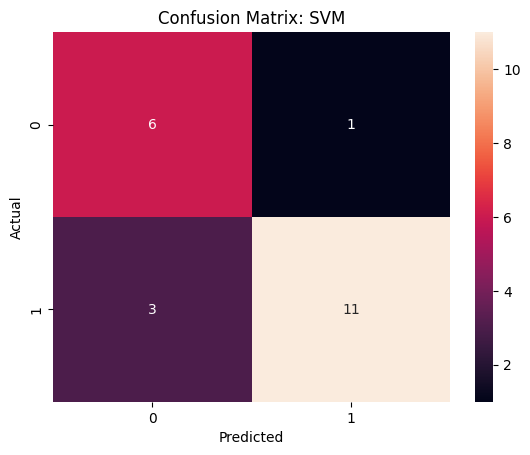

Accuracy for SVM: 0.8095238095238095

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.92      0.79      0.85        14

    accuracy                           0.81        21
   macro avg       0.79      0.82      0.80        21
weighted avg       0.83      0.81      0.81        21



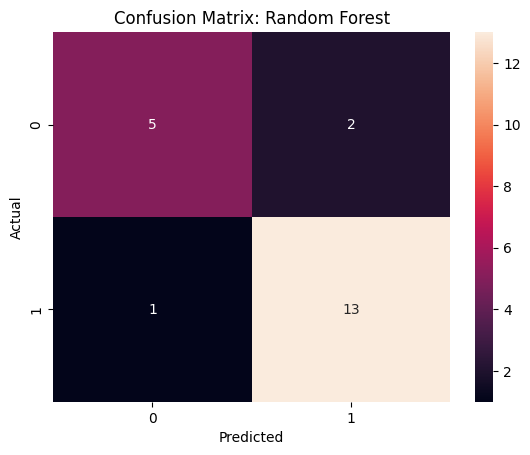

Accuracy for Random Forest: 0.8571428571428571

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.87      0.93      0.90        14

    accuracy                           0.86        21
   macro avg       0.85      0.82      0.83        21
weighted avg       0.86      0.86      0.85        21



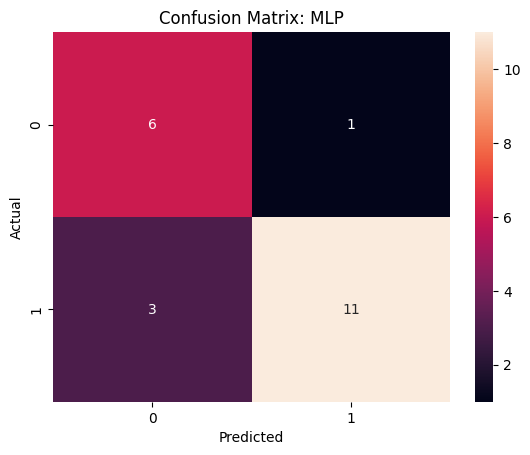

Accuracy for MLP: 0.8095238095238095

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.92      0.79      0.85        14

    accuracy                           0.81        21
   macro avg       0.79      0.82      0.80        21
weighted avg       0.83      0.81      0.81        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:10:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


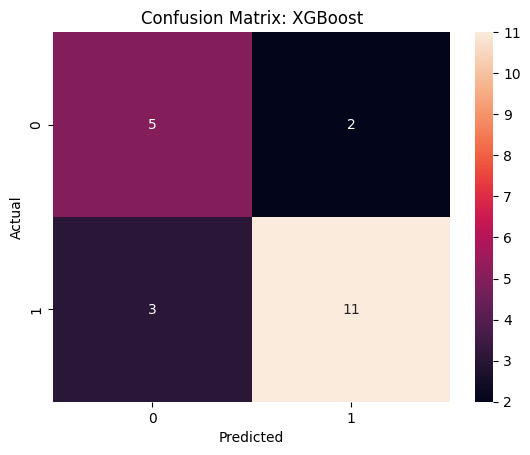

Accuracy for XGBoost: 0.7619047619047619

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.85      0.79      0.81        14

    accuracy                           0.76        21
   macro avg       0.74      0.75      0.74        21
weighted avg       0.77      0.76      0.77        21



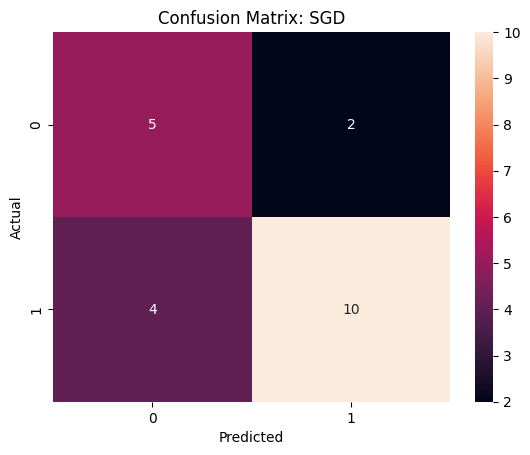

Accuracy for SGD: 0.7142857142857143

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.56      0.71      0.62         7
           1       0.83      0.71      0.77        14

    accuracy                           0.71        21
   macro avg       0.69      0.71      0.70        21
weighted avg       0.74      0.71      0.72        21



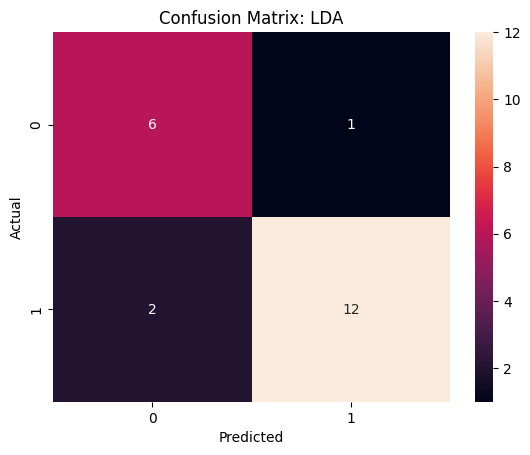

Accuracy for LDA: 0.8571428571428571

Classification Report for LDA:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21

Iteration 10/10


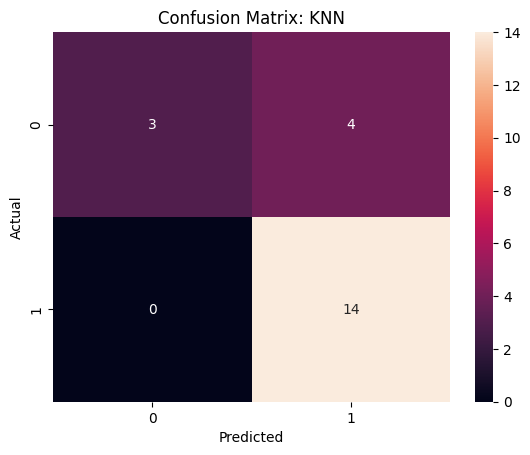

Accuracy for KNN: 0.8095238095238095

Classification Report for KNN:
               precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.78      1.00      0.88        14

    accuracy                           0.81        21
   macro avg       0.89      0.71      0.74        21
weighted avg       0.85      0.81      0.78        21



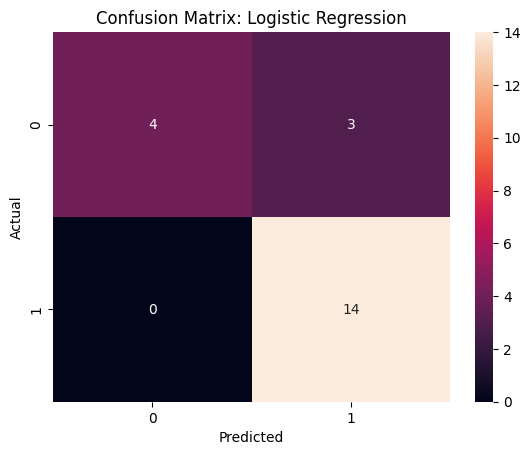

Accuracy for Logistic Regression: 0.8571428571428571

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.82      1.00      0.90        14

    accuracy                           0.86        21
   macro avg       0.91      0.79      0.82        21
weighted avg       0.88      0.86      0.84        21



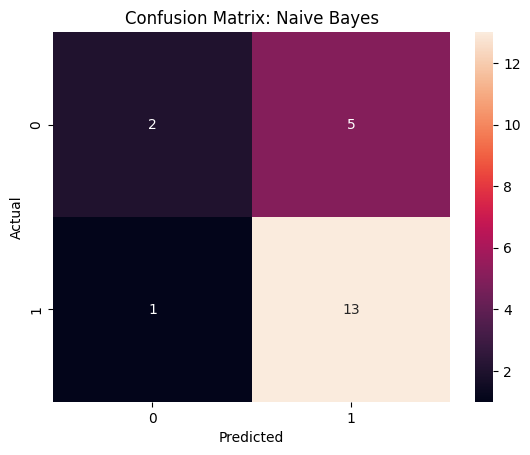

Accuracy for Naive Bayes: 0.7142857142857143

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.72      0.93      0.81        14

    accuracy                           0.71        21
   macro avg       0.69      0.61      0.61        21
weighted avg       0.70      0.71      0.68        21



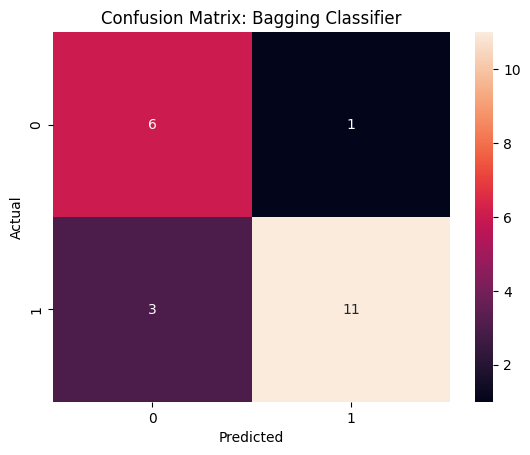

Accuracy for Bagging Classifier: 0.8095238095238095

Classification Report for Bagging Classifier:
               precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.92      0.79      0.85        14

    accuracy                           0.81        21
   macro avg       0.79      0.82      0.80        21
weighted avg       0.83      0.81      0.81        21



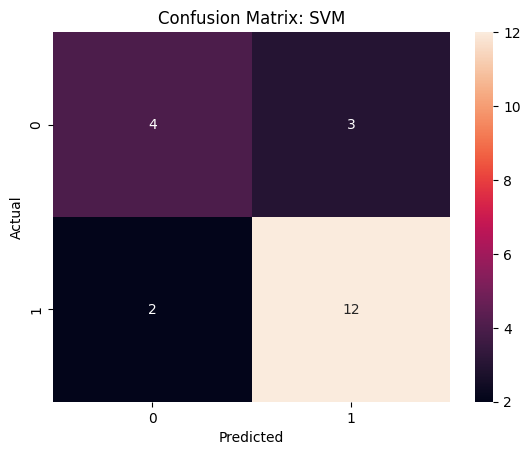

Accuracy for SVM: 0.7619047619047619

Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.80      0.86      0.83        14

    accuracy                           0.76        21
   macro avg       0.73      0.71      0.72        21
weighted avg       0.76      0.76      0.76        21



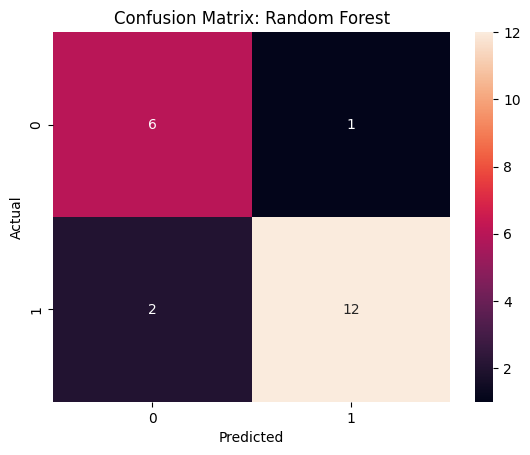

Accuracy for Random Forest: 0.8571428571428571

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21



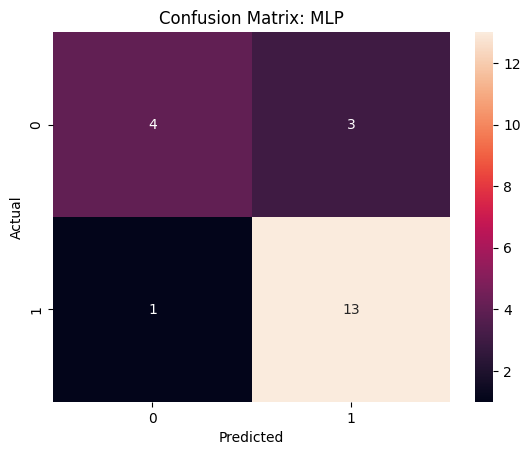

Accuracy for MLP: 0.8095238095238095

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.81      0.93      0.87        14

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:10:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


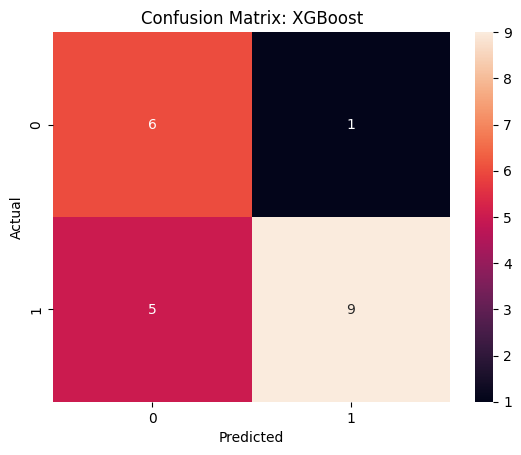

Accuracy for XGBoost: 0.7142857142857143

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.55      0.86      0.67         7
           1       0.90      0.64      0.75        14

    accuracy                           0.71        21
   macro avg       0.72      0.75      0.71        21
weighted avg       0.78      0.71      0.72        21



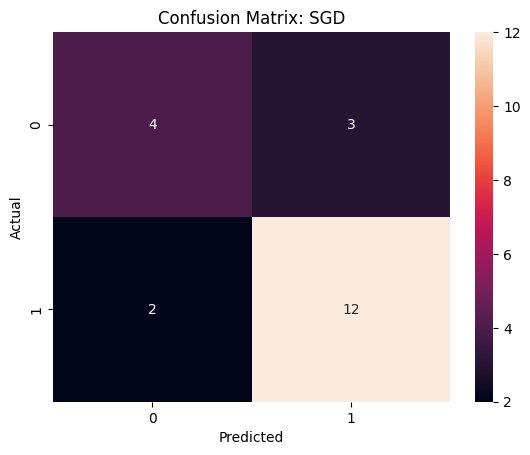

Accuracy for SGD: 0.7619047619047619

Classification Report for SGD:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.80      0.86      0.83        14

    accuracy                           0.76        21
   macro avg       0.73      0.71      0.72        21
weighted avg       0.76      0.76      0.76        21



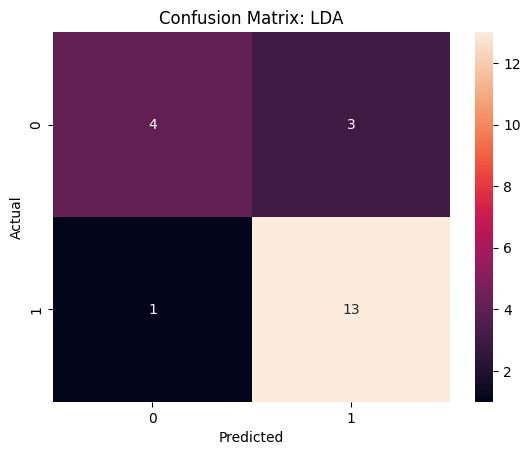

Accuracy for LDA: 0.8095238095238095

Classification Report for LDA:
               precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.81      0.93      0.87        14

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21

Accuracy results per iteration: {'KNN': [0.6190476190476191, 0.7619047619047619, 0.7619047619047619, 0.9523809523809523, 0.7619047619047619, 0.8571428571428571, 0.7619047619047619, 0.8571428571428571, 0.7619047619047619, 0.8095238095238095], 'Logistic Regression': [0.7619047619047619, 0.9523809523809523, 0.8571428571428571, 0.9047619047619048, 0.8571428571428571, 0.8571428571428571, 0.9047619047619048, 0.8095238095238095, 0.8571428571428571, 0.8571428571428571], 'Naive Bayes': [0.7619047619047619, 0.7142857142857143, 0.7142857142857143, 0.9047619047619048, 0.7142857142857143, 0.8095238095238095, 

In [ ]:
# Number of iterations
n_iterations = 10

# Initialize lists to store evaluation results for each iteration
accuracy_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                    'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
precision_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                     'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
recall_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                  'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
f1_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
              'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}

# Main loop over n iterations
for i in range(n_iterations):
    print(f"Iteration {i + 1}/{n_iterations}")
    seed_value = random.randint(0, 10000)  # Generate a new random_state for each iteration

    # Split data into temp (80%) and test sets (20%)
    X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=seed_value)


    # Initialize and evaluate each model with the best hyperparameters

    # K-Nearest Neighbors
    knn_model = KNeighborsClassifier(n_neighbors=best_model_knn.get_params()['n_neighbors'])
    knn_model.fit(X_train, y_train)
    accuracy_knn, precision_knn, recall_knn, f1_knn = evaluate_model(knn_model, X_test, y_test, "KNN")
    accuracy_results['KNN'].append(accuracy_knn)
    precision_results['KNN'].append(precision_knn)
    recall_results['KNN'].append(recall_knn)
    f1_results['KNN'].append(f1_knn)

    # Logistic Regression
    lr_model = LogisticRegression(**best_model_lr.get_params())
    lr_model.fit(X_train, y_train)
    accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
    accuracy_results['Logistic Regression'].append(accuracy_lr)
    precision_results['Logistic Regression'].append(precision_lr)
    recall_results['Logistic Regression'].append(recall_lr)
    f1_results['Logistic Regression'].append(f1_lr)

    # Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_model(nb_model, X_test, y_test, "Naive Bayes")
    accuracy_results['Naive Bayes'].append(accuracy_nb)
    precision_results['Naive Bayes'].append(precision_nb)
    recall_results['Naive Bayes'].append(recall_nb)
    f1_results['Naive Bayes'].append(f1_nb)

    # Bagging Classifier
    # Get parameters without the 'estimator__' prefix
    bagging_params = {key: value for key, value in best_model_bagging.get_params().items() if not key.startswith('estimator__')}
    bagging_model = BaggingClassifier(**bagging_params)
    bagging_model.fit(X_train, y_train)
    accuracy_bagging, precision_bagging, recall_bagging, f1_bagging = evaluate_model(bagging_model, X_test, y_test, "Bagging Classifier")
    accuracy_results['Bagging Classifier'].append(accuracy_bagging)
    precision_results['Bagging Classifier'].append(precision_bagging)
    recall_results['Bagging Classifier'].append(recall_bagging)
    f1_results['Bagging Classifier'].append(f1_bagging)

    # Support Vector Machine
    svm_model = SVC(**best_model_svm.get_params())
    svm_model.fit(X_train, y_train)
    accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(svm_model, X_test, y_test, "SVM")
    accuracy_results['SVM'].append(accuracy_svm)
    precision_results['SVM'].append(precision_svm)
    recall_results['SVM'].append(recall_svm)
    f1_results['SVM'].append(f1_svm)

    # Random Forest
    rf_model = RandomForestClassifier(**best_model_rf.get_params())
    rf_model.fit(X_train, y_train)
    accuracy_rf, precision_rf, recall_rf, f1_rf = evaluate_model(rf_model, X_test, y_test, "Random Forest")
    accuracy_results['Random Forest'].append(accuracy_rf)
    precision_results['Random Forest'].append(precision_rf)
    recall_results['Random Forest'].append(recall_rf)
    f1_results['Random Forest'].append(f1_rf)

    # MLP Classifier
    mlp_model = MLPClassifier(**best_model_mlp.get_params())
    mlp_model.fit(X_train, y_train)
    accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(mlp_model, X_test, y_test, "MLP")
    accuracy_results['MLP'].append(accuracy_mlp)
    precision_results['MLP'].append(precision_mlp)
    recall_results['MLP'].append(recall_mlp)
    f1_results['MLP'].append(f1_mlp)

    # XGBoost
    xgb_model = XGBClassifier(**best_model_xgb.get_params())
    xgb_model.fit(X_train, y_train)
    accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
    accuracy_results['XGBoost'].append(accuracy_xgb)
    precision_results['XGBoost'].append(precision_xgb)
    recall_results['XGBoost'].append(recall_xgb)
    f1_results['XGBoost'].append(f1_xgb)

    # Stochastic Gradient Descent (SGD)
    # Valid parameters for SGDClassifier
    sgd_param_keys = ['loss', 'penalty', 'alpha', 'l1_ratio', 'fit_intercept', 'max_iter',
                      'tol', 'shuffle', 'random_state', 'learning_rate', 'eta0',
                      'power_t', 'early_stopping', 'validation_fraction', 'n_iter_no_change']

    # Extract only the valid parameters
    sgd_params = {key: value for key, value in best_model_sgd.get_params().items() if key in sgd_param_keys}

    # Create and fit the model
    sgd_model = SGDClassifier(**sgd_params)
    sgd_model.fit(X_train, y_train)
    accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = evaluate_model(sgd_model, X_test, y_test, "SGD")
    accuracy_results['SGD'].append(accuracy_sgd)
    precision_results['SGD'].append(precision_sgd)
    recall_results['SGD'].append(recall_sgd)
    f1_results['SGD'].append(f1_sgd)

    # Linear Discriminant Analysis (LDA)
    lda_model = LinearDiscriminantAnalysis(**best_model_lda.get_params())
    lda_model.fit(X_train, y_train)
    accuracy_lda, precision_lda, recall_lda, f1_lda = evaluate_model(lda_model, X_test, y_test, "LDA")
    accuracy_results['LDA'].append(accuracy_lda)
    precision_results['LDA'].append(precision_lda)
    recall_results['LDA'].append(recall_lda)
    f1_results['LDA'].append(f1_lda)

# Output results
print("Accuracy results per iteration:", accuracy_results)
print("Precision results per iteration:", precision_results)
print("Recall results per iteration:", recall_results)
print("F1 results per iteration:", f1_results)

best_hyperparams = {
    'KNN': best_model_knn.get_params(),
    'Logistic Regression': best_model_lr.get_params(),
    'Naive Bayes': {},  # No specific hyperparameters used here
    'Bagging Classifier': {key: value for key, value in best_model_bagging.get_params().items() if not key.startswith('estimator__')},
    'SVM': best_model_svm.get_params(),
    'Random Forest': best_model_rf.get_params(),
    'MLP': best_model_mlp.get_params(),
    'XGBoost': best_model_xgb.get_params(),
    'SGD': {key: value for key, value in best_model_sgd.get_params().items() if key in sgd_param_keys},
    'LDA': best_model_lda.get_params()
}

# Create a summary table
summary_data = {
    'Classifier': [],
    'Mean Accuracy': [],
    'Variance Accuracy': [],
    'Mean Precision': [],
    'Variance Precision': [],
    'Mean Recall': [],
    'Variance Recall': [],
    'Mean F1 Score': [],
    'Variance F1 Score': [],
    'Best Hyperparameters': []
}

# Populate the summary table with metrics and hyperparameters
for classifier, params in best_hyperparams.items():
    summary_data['Classifier'].append(classifier)
    summary_data['Mean Accuracy'].append(np.mean(accuracy_results[classifier]))
    summary_data['Variance Accuracy'].append(np.var(accuracy_results[classifier], ddof=1))
    summary_data['Mean Precision'].append(np.mean(precision_results[classifier]))
    summary_data['Variance Precision'].append(np.var(precision_results[classifier], ddof=1))
    summary_data['Mean Recall'].append(np.mean(recall_results[classifier]))
    summary_data['Variance Recall'].append(np.var(recall_results[classifier], ddof=1))
    summary_data['Mean F1 Score'].append(np.mean(f1_results[classifier]))
    summary_data['Variance F1 Score'].append(np.var(f1_results[classifier], ddof=1))
    summary_data['Best Hyperparameters'].append(params)  # Add hyperparameters

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Function to highlight the best values
def highlight_best(s):
    is_best = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_best]

# Apply the highlighting
styled_summary_df = summary_df.style.apply(highlight_best, subset=['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score'])

# Display the styled table
styled_summary_df


Old version test train multiple iterations:

In [ ]:
# Number of iterations
n_iterations = 10

# Initialize lists to store evaluation results for each iteration
accuracy_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                    'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
precision_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                     'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
recall_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                  'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
f1_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
              'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}

# Function to evaluate and return metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    precision = class_report['1']['precision']
    recall = class_report['1']['recall']
    f1 = class_report['1']['f1-score']
    return accuracy, precision, recall, f1

# Function to perform grid search with cross-validation
def perform_grid_search(model, param_grid, X, y, ps, scaler=None):
    if scaler:  # Apply scaling if needed
          X = scaler.fit_transform(X)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        cv=ps,
        verbose=1
    )
    grid_search.fit(X, y)
    print(f"\nBest Parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_

# Main loop over n iterations
for i in range(n_iterations):
    print(f"Iteration {i + 1}/{n_iterations}")
    seed_value = random.randint(0, 10000)  # Generate a new random_state for each iteration

    # Split data into temp (80%) and test sets (20%)
    X_temp, X_test, y_temp, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=seed_value)

    # Split temp into train (60%) and validation sets (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=seed_value)

    train_test_fold = np.concatenate([np.full(X_train.shape[0], -1), np.zeros(X_val.shape[0])])

    X_train_val = np.concatenate((X_train, X_val), axis=0)
    y_train_val = np.concatenate((y_train, y_val), axis=0)

    # Create a PredefinedSplit using the train_test_fold
    ps = PredefinedSplit(train_test_fold)

    scaler = StandardScaler()

    # Hyperparameter grids
    param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
    param_grid_lr = {'C': [0.1, 1, 10, 100]}
    param_grid_bagging = {'n_estimators': [50, 100, 200]}
    param_grid_rf = {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 5, 10]}
    param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto'],'degree': [3, 4, 5]}
    param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['tanh', 'relu'], 'solver': ['adam', 'sgd'], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate': ['constant', 'adaptive'], 'max_iter': [1000]}
    param_grid_xgb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1]}
    param_grid_sgd = {'base_estimator__eta0': [0.01, 0.1, 1.0],'base_estimator__alpha': [0.001, 0.01, 0.1]}
    param_grid_lda = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': [None, 'auto']}  # Only applicable for 'lsqr' and 'eigen' solvers
    param_grid_sgd = {
      'estimator__penalty': ['elasticnet'],
      'estimator__loss': ['log_loss'],
      'estimator__learning_rate': ['optimal'],
      'estimator__eta0': [1],
      'estimator__alpha': [0.1, 0.01, 0.001]  # example with more values
      }


    # K-Nearest Neighbors
    best_model_knn = perform_grid_search(KNeighborsClassifier(), param_grid_knn, X_train_val, y_train_val, ps)
    accuracy_knn, precision_knn, recall_knn, f1_knn = evaluate_model(best_model_knn, X_test, y_test)
    accuracy_results['KNN'].append(accuracy_knn)
    precision_results['KNN'].append(precision_knn)
    recall_results['KNN'].append(recall_knn)
    f1_results['KNN'].append(f1_knn)

    # Logistic Regression
    best_model_lr = perform_grid_search(LogisticRegression(max_iter=10000, random_state=seed_value), param_grid_lr, X_train_val, y_train_val, ps)
    accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(best_model_lr, X_test, y_test)
    accuracy_results['Logistic Regression'].append(accuracy_lr)
    precision_results['Logistic Regression'].append(precision_lr)
    recall_results['Logistic Regression'].append(recall_lr)
    f1_results['Logistic Regression'].append(f1_lr)

    # Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train_val, y_train_val)
    accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_model(nb_model, X_test, y_test)
    accuracy_results['Naive Bayes'].append(accuracy_nb)
    precision_results['Naive Bayes'].append(precision_nb)
    recall_results['Naive Bayes'].append(recall_nb)
    f1_results['Naive Bayes'].append(f1_nb)

    # Bagging Classifier
    best_model_bagging = perform_grid_search(BaggingClassifier(estimator=DecisionTreeClassifier(random_state=seed_value), random_state=seed_value), param_grid_bagging, X_train_val, y_train_val, ps)
    accuracy_bagging, precision_bagging, recall_bagging, f1_bagging = evaluate_model(best_model_bagging, X_test, y_test)
    accuracy_results['Bagging Classifier'].append(accuracy_bagging)
    precision_results['Bagging Classifier'].append(precision_bagging)
    recall_results['Bagging Classifier'].append(recall_bagging)
    f1_results['Bagging Classifier'].append(f1_bagging)

    # SVM
    best_model_svm = perform_grid_search(SVC(), param_grid_svm, X_train_val, y_train_val, ps, scaler)
    accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(best_model_svm, X_test, y_test)
    accuracy_results['SVM'].append(accuracy_svm)
    precision_results['SVM'].append(precision_svm)
    recall_results['SVM'].append(recall_svm)
    f1_results['SVM'].append(f1_svm)

    # Random Forest
    best_model_rf = perform_grid_search(RandomForestClassifier(random_state=seed_value), param_grid_rf, X_train_val, y_train_val, ps)
    accuracy_rf, precision_rf, recall_rf, f1_rf = evaluate_model(best_model_rf, X_test, y_test)
    accuracy_results['Random Forest'].append(accuracy_rf)
    precision_results['Random Forest'].append(precision_rf)
    recall_results['Random Forest'].append(recall_rf)
    f1_results['Random Forest'].append(f1_rf)

    # MLP
    best_model_mlp = perform_grid_search(MLPClassifier(random_state=seed_value), param_grid_mlp, X_train_val, y_train_val, ps, scaler)
    accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(best_model_mlp, X_test, y_test)
    accuracy_results['MLP'].append(accuracy_mlp)
    precision_results['MLP'].append(precision_mlp)
    recall_results['MLP'].append(recall_mlp)
    f1_results['MLP'].append(f1_mlp)

    # XGBoost
    best_model_xgb = perform_grid_search(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_value), param_grid_xgb, X_train_val, y_train_val, ps)
    accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = evaluate_model(best_model_xgb, X_test, y_test)
    accuracy_results['XGBoost'].append(accuracy_xgb)
    precision_results['XGBoost'].append(precision_xgb)
    recall_results['XGBoost'].append(recall_xgb)
    f1_results['XGBoost'].append(f1_xgb)

    # SGD Classifier
    best_model_sgd = perform_grid_search(
        CalibratedClassifierCV(SGDClassifier(random_state=seed_value)),
        param_grid_sgd,
        X_train_val,
        y_train_val,
        ps,
        scaler
        )
    #best_model_sgd = perform_grid_search(CalibratedClassifierCV(base_estimator=SGDClassifier(penalty='elasticnet', loss='log', learning_rate='optimal', random_state=seed_value)),param_grid_sgd, X_train_val, y_train_val, scaler)
    accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = evaluate_model(best_model_sgd, X_test, y_test)
    accuracy_results['SGD'].append(accuracy_sgd)
    precision_results['SGD'].append(precision_sgd)
    recall_results['SGD'].append(recall_sgd)
    f1_results['SGD'].append(f1_sgd)

    ##################
    # LDA Classifier
    best_model_lda = perform_grid_search(LinearDiscriminantAnalysis(), param_grid_lda, X_train_val, y_train_val, ps)
    accuracy_lda, precision_lda, recall_lda, f1_lda = evaluate_model(best_model_lda, X_test, y_test)
    accuracy_results['LDA'].append(accuracy_lda)
    precision_results['LDA'].append(precision_lda)
    recall_results['LDA'].append(recall_lda)
    f1_results['LDA'].append(f1_lda)

# Function to calculate mean and variance for each classifier
def calculate_mean_variance(results):
    mean_values = {classifier: np.mean(metrics) for classifier, metrics in results.items()}
    var_values = {classifier: np.var(metrics) for classifier, metrics in results.items()}
    return mean_values, var_values

# Calculate mean and variance for accuracy, precision, recall, and F1-score
accuracy_mean, accuracy_variance = calculate_mean_variance(accuracy_results)
precision_mean, precision_variance = calculate_mean_variance(precision_results)
recall_mean, recall_variance = calculate_mean_variance(recall_results)
f1_mean, f1_variance = calculate_mean_variance(f1_results)

#############
# Create DataFrames for each metric's mean and variance
mean_df = pd.DataFrame({
    'Accuracy (Mean)': accuracy_mean,
    'Precision (Mean)': precision_mean,
    'Recall (Mean)': recall_mean,
    'F1-Score (Mean)': f1_mean
})

variance_df = pd.DataFrame({
    'Accuracy (Variance)': accuracy_variance,
    'Precision (Variance)': precision_variance,
    'Recall (Variance)': recall_variance,
    'F1-Score (Variance)': f1_variance
})

# Combine the mean and variance DataFrames for a full summary
summary_df = pd.concat([mean_df, variance_df], axis=1)

# Display the table
print("Evaluation Metrics Comparison Across Classifiers:")
display(summary_df)

# Optionally, save the results to a CSV file for future reference
#summary_df.to_csv('evaluation_metrics_comparison.csv', index=True)

# Display results
print("Mean Accuracy per Classifier:", accuracy_mean)
print("Variance in Accuracy per Classifier:", accuracy_variance)

print("Mean Precision per Classifier:", precision_mean)
print("Variance in Precision per Classifier:", precision_variance)

print("Mean Recall per Classifier:", recall_mean)
print("Variance in Recall per Classifier:", recall_variance)

print("Mean F1-Score per Classifier:", f1_mean)
print("Variance in F1-Score per Classifier:", f1_variance)

With cross validation (new version):

Tuning K-Nearest Neighbours hyperparameters...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters for KNeighborsClassifier: {'n_neighbors': 5}
Best Cross-Validation Accuracy: 0.7971

Tuning Logistic Regression hyperparameters...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8801

Using default Naive Bayes model...

Tuning Bagging Classifier hyperparameters...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Parameters for BaggingClassifier: {'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8088

Tuning SVM hyperparameters...
Fitting 5 folds for each of 90 candidates, totalling 450 fits

Best Parameters for SVC: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.8559

Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best Parameters for RandomF

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:05:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8941

Tuning SGD hyperparameters...
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8919

Tuning LDA hyperparameters...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.8926

Evaluating the best K-Nearest Neighbours model on the test set...


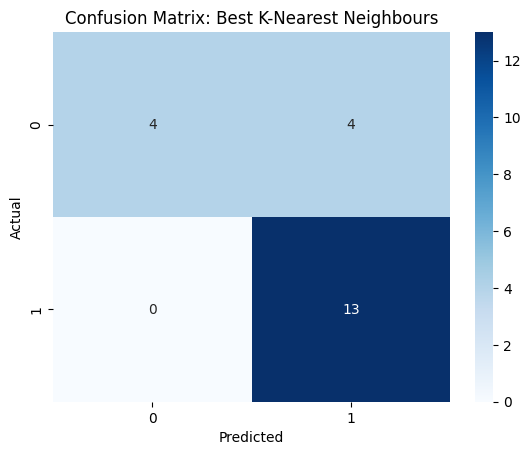

Accuracy for Best K-Nearest Neighbours: 0.8095

Classification Report for Best K-Nearest Neighbours:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.76      1.00      0.87        13

    accuracy                           0.81        21
   macro avg       0.88      0.75      0.77        21
weighted avg       0.85      0.81      0.79        21


Evaluating the best Logistic Regression model on the test set...


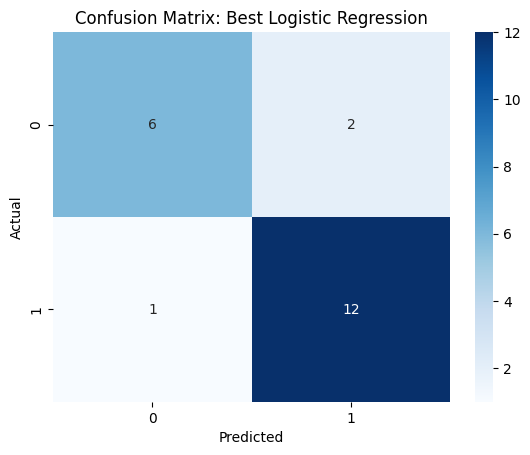

Accuracy for Best Logistic Regression: 0.8571

Classification Report for Best Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.86      0.92      0.89        13

    accuracy                           0.86        21
   macro avg       0.86      0.84      0.84        21
weighted avg       0.86      0.86      0.86        21


Evaluating the best Naive Bayes model on the test set...


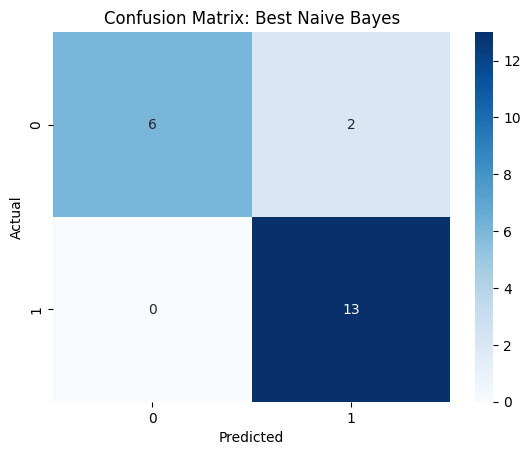

Accuracy for Best Naive Bayes: 0.9048

Classification Report for Best Naive Bayes:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.87      1.00      0.93        13

    accuracy                           0.90        21
   macro avg       0.93      0.88      0.89        21
weighted avg       0.92      0.90      0.90        21


Evaluating the best Bagging Classifier model on the test set...


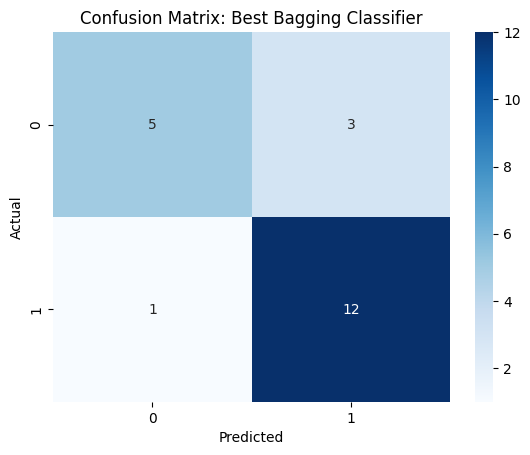

Accuracy for Best Bagging Classifier: 0.8095

Classification Report for Best Bagging Classifier:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.80      0.92      0.86        13

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21


Evaluating the best SVM model on the test set...


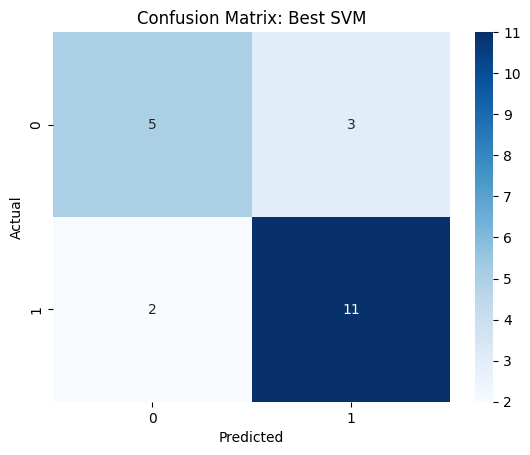

Accuracy for Best SVM: 0.7619

Classification Report for Best SVM:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.79      0.85      0.81        13

    accuracy                           0.76        21
   macro avg       0.75      0.74      0.74        21
weighted avg       0.76      0.76      0.76        21


Evaluating the best Random Forest model on the test set...


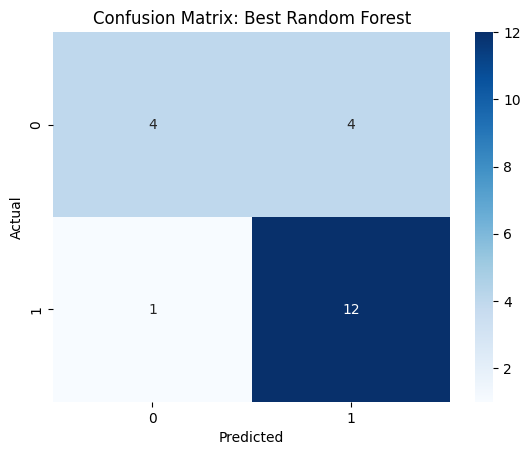

Accuracy for Best Random Forest: 0.7619

Classification Report for Best Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.75      0.92      0.83        13

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weighted avg       0.77      0.76      0.75        21


Evaluating the best MLP model on the test set...


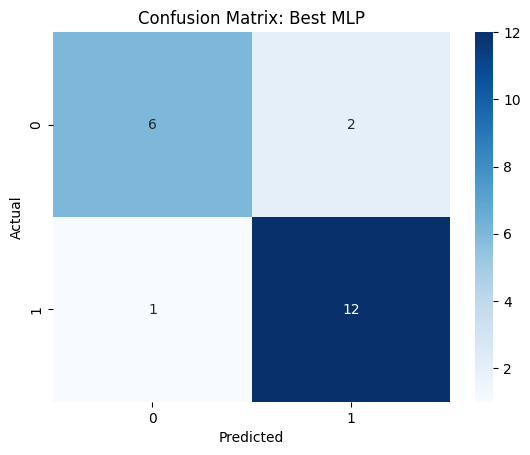

Accuracy for Best MLP: 0.8571

Classification Report for Best MLP:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.86      0.92      0.89        13

    accuracy                           0.86        21
   macro avg       0.86      0.84      0.84        21
weighted avg       0.86      0.86      0.86        21


Evaluating the best XGBoost model on the test set...


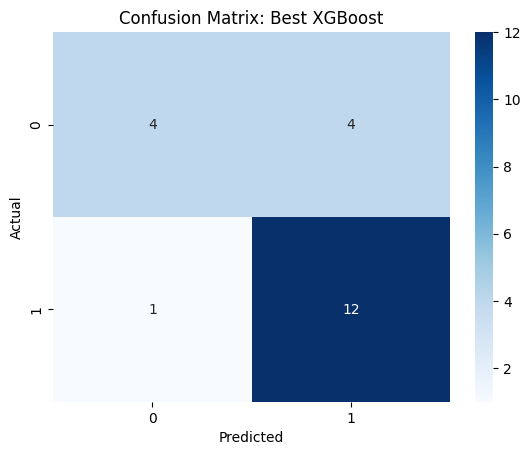

Accuracy for Best XGBoost: 0.7619

Classification Report for Best XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.75      0.92      0.83        13

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weighted avg       0.77      0.76      0.75        21


Evaluating the best SGD model on the test set...


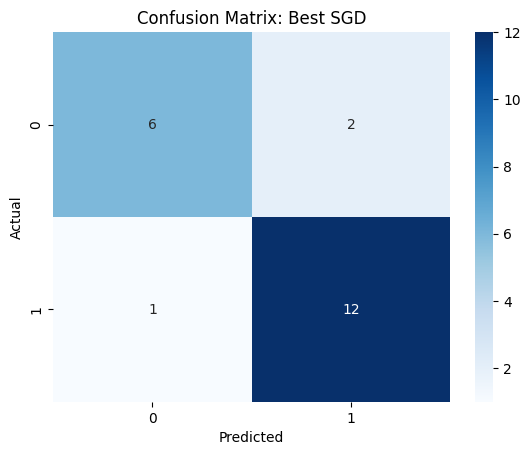

Accuracy for Best SGD: 0.8571

Classification Report for Best SGD:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.86      0.92      0.89        13

    accuracy                           0.86        21
   macro avg       0.86      0.84      0.84        21
weighted avg       0.86      0.86      0.86        21


Evaluating the best LDA model on the test set...


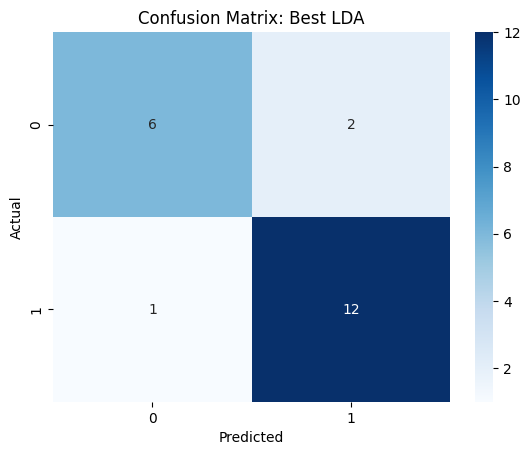

Accuracy for Best LDA: 0.8571

Classification Report for Best LDA:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.86      0.92      0.89        13

    accuracy                           0.86        21
   macro avg       0.86      0.84      0.84        21
weighted avg       0.86      0.86      0.86        21



Classifier  Accuracy  Precision    Recall  F1-Score  \
0  K-Nearest Neighbours  0.809524   0.764706  1.000000  0.866667   
1   Logistic Regression  0.857143   0.857143  0.923077  0.888889   
2           Naive Bayes  0.904762   0.866667  1.000000  0.928571   
3    Bagging Classifier  0.809524   0.800000  0.923077  0.857143   
4                   SVM  0.761905   0.785714  0.846154  0.814815   
5         Random Forest  0.761905   0.750000  0.923077  0.827586   
6                   MLP  0.857143   0.857143  0.923077  0.888889   
7               XGBoost  0.761905   0.750000  0.923077  0.827586   
8                   SGD  0.857143   0.857143  0.923077  0.888889   
9                   LDA  0.857143   0.857143  0.923077  0.888889   

                                         Best Params  
0  {'algorithm': 'auto', 'leaf_size': 30, 'metric...  
1  {'C': 0.1, 'class_weight': None, 'dual': False...  
2                                            Default  
3  {'bootstrap': True, 'bootstrap_features': Fals...  
4  {'C': 10, 'break_ties': False, 'cache_size': 2...  
5  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
6  {'activation': 'tanh', 'alpha': 0.0001, 'batch...  
7  {'objective': 'binary:logistic', 'base_score':...  
8  {'cv': None, 'ensemble': True, 'estimator__alp...  
9  {'covariance_estimator': None, 'n_components':...

In [ ]:
# Split data into training (80%) and testing sets (20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=seed_value, stratify=y)

# Feature scaling for models that require it (SVM and MLP and SGD)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter grids
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
param_grid_lr = {'C': [0.1, 1, 10, 100]}
param_grid_bagging = {'n_estimators': [50, 100, 200]}
param_grid_rf = {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 5, 10]}
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto'],'degree': [3, 4, 5]}
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['tanh', 'relu'], 'solver': ['adam', 'sgd'], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate': ['constant', 'adaptive'], 'max_iter': [1000]}
param_grid_xgb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1]}
#param_grid_sgd = {'base_estimator__eta0': [0.01, 0.1, 1.0],'base_estimator__alpha': [0.001, 0.01, 0.1]}
param_grid_lda = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': [None, 'auto']}  # Only applicable for 'lsqr' and 'eigen' solvers
param_grid_sgd = {
    'estimator__penalty': ['elasticnet'],
    'estimator__loss': ['log_loss'],
    'estimator__learning_rate': ['optimal'],
    'estimator__eta0': [1],
    'estimator__alpha': [0.1, 0.01, 0.001]  # example with more values
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

# Function to perform grid search with cross-validation
def perform_grid_search(model, param_grid, X, y, cv, scaler=None):
    if scaler:  # Apply scaling if needed
          X = scaler.fit_transform(X)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        verbose=1
    )
    grid_search.fit(X, y)
    print(f"\nBest Parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_

# Initialize list for storing best configurations
best_configs = []

# Function to evaluate models and return metrics
def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {title}')
    plt.show()

    # Return accuracy, precision, recall, and F1 score for class '1'
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    precision = class_report['1']['precision']  # Precision for class 1
    recall = class_report['1']['recall']  # Recall for class 1
    f1 = class_report['1']['f1-score']  # F1-score for class 1

    print(f"Accuracy for {title}: {accuracy:.4f}")
    print(f"\nClassification Report for {title}:\n{classification_report(y_test, y_pred)}")

    return accuracy, precision, recall, f1


# Perform grid search for K-Nearest Neighbours
print("Tuning K-Nearest Neighbours hyperparameters...")
best_model_knn = perform_grid_search(KNeighborsClassifier(), param_grid_knn, X_train, y_train, cv)

# Perform grid search for Logistic Regression
print("\nTuning Logistic Regression hyperparameters...")
best_model_lr = perform_grid_search(LogisticRegression(max_iter=10000, random_state=seed_value), param_grid_lr, X_train, y_train, cv)

# Perform grid search for Naive Bayes (no hyperparameter tuning for GaussianNB)
print("\nUsing default Naive Bayes model...")
best_model_nb = GaussianNB().fit(X_train, y_train)

# Perform grid search for Bagging Classifier
print("\nTuning Bagging Classifier hyperparameters...")
best_model_bagging = perform_grid_search(BaggingClassifier(estimator=DecisionTreeClassifier(random_state=seed_value), random_state=seed_value), param_grid_bagging, X_train, y_train, cv)

# Perform grid search for SVM
print("\nTuning SVM hyperparameters...")
best_model_svm = perform_grid_search(SVC(), param_grid_svm, X_train, y_train, cv, scaler)

# Perform grid search for Random Forest
print("\nTuning Random Forest hyperparameters...")
best_model_rf = perform_grid_search(RandomForestClassifier(random_state=seed_value), param_grid_rf, X_train, y_train, cv)

# Perform grid search for MLP
print("\nTuning MLP hyperparameters...")
best_model_mlp = perform_grid_search(MLPClassifier(random_state=seed_value), param_grid_mlp, X_train, y_train, cv, scaler)

# Perform grid search for XGBoost
print("\nTuning XGBoost hyperparameters...")
best_model_xgb = perform_grid_search(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_value), param_grid_xgb, X_train, y_train, cv)

# Perform grid search for SGD
print("\nTuning SGD hyperparameters...")
#best_model_sgd = perform_grid_search(CalibratedClassifierCV(base_estimator=SGDClassifier(penalty='elasticnet', loss='log', learning_rate='optimal', random_state=seed_value)),param_grid_sgd, X_train, y_train, scaler)
best_model_sgd = perform_grid_search(
    CalibratedClassifierCV(SGDClassifier(random_state=seed_value)),
    param_grid_sgd,
    X_train,
    y_train,
    cv,
    scaler
)

# Perform grid search for LDA
print("\nTuning LDA hyperparameters...")
best_model_lda = perform_grid_search(LinearDiscriminantAnalysis(), param_grid_lda, X_train, y_train, cv)


# Evaluate best models on test set
print("\nEvaluating the best K-Nearest Neighbours model on the test set...")
accuracy_knn, precision_knn, recall_knn, f1_knn = evaluate_model(best_model_knn, X_test, y_test, "Best K-Nearest Neighbours")
best_configs.append({
    'Classifier': 'K-Nearest Neighbours',
    'Accuracy': accuracy_knn,
    'Precision': precision_knn,
    'Recall': recall_knn,
    'F1-Score': f1_knn,
    'Best Params': best_model_knn.get_params()
})

print("\nEvaluating the best Logistic Regression model on the test set...")
accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(best_model_lr, X_test, y_test, "Best Logistic Regression")
best_configs.append({
    'Classifier': 'Logistic Regression',
    'Accuracy': accuracy_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1-Score': f1_lr,
    'Best Params': best_model_lr.get_params()
})

print("\nEvaluating the best Naive Bayes model on the test set...")
accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_model(best_model_nb, X_test, y_test, "Best Naive Bayes")
best_configs.append({
    'Classifier': 'Naive Bayes',
    'Accuracy': accuracy_nb,
    'Precision': precision_nb,
    'Recall': recall_nb,
    'F1-Score': f1_nb,
    'Best Params': 'Default'
})

print("\nEvaluating the best Bagging Classifier model on the test set...")
accuracy_bagging, precision_bagging, recall_bagging, f1_bagging = evaluate_model(best_model_bagging, X_test, y_test, "Best Bagging Classifier")
best_configs.append({
    'Classifier': 'Bagging Classifier',
    'Accuracy': accuracy_bagging,
    'Precision': precision_bagging,
    'Recall': recall_bagging,
    'F1-Score': f1_bagging,
    'Best Params': best_model_bagging.get_params()
})

print("\nEvaluating the best SVM model on the test set...")
accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(best_model_svm, X_test_scaled, y_test, "Best SVM")
best_configs.append({
    'Classifier': 'SVM',
    'Accuracy': accuracy_svm,
    'Precision': precision_svm,
    'Recall': recall_svm,
    'F1-Score': f1_svm,
    'Best Params': best_model_svm.get_params()
})

print("\nEvaluating the best Random Forest model on the test set...")
accuracy_rf, precision_rf, recall_rf, f1_rf = evaluate_model(best_model_rf, X_test, y_test, "Best Random Forest")
best_configs.append({
    'Classifier': 'Random Forest',
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf,
    'Best Params': best_model_rf.get_params()
})

print("\nEvaluating the best MLP model on the test set...")
accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(best_model_mlp, X_test_scaled, y_test, "Best MLP")
best_configs.append({
    'Classifier': 'MLP',
    'Accuracy': accuracy_mlp,
    'Precision': precision_mlp,
    'Recall': recall_mlp,
    'F1-Score': f1_mlp,
    'Best Params': best_model_mlp.get_params()
})

print("\nEvaluating the best XGBoost model on the test set...")
accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = evaluate_model(best_model_xgb, X_test, y_test, "Best XGBoost")
best_configs.append({
    'Classifier': 'XGBoost',
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1-Score': f1_xgb,
    'Best Params': best_model_xgb.get_params()
})

print("\nEvaluating the best SGD model on the test set...")
accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = evaluate_model(best_model_sgd, X_test, y_test, "Best SGD")
best_configs.append({
    'Classifier': 'SGD',
    'Accuracy': accuracy_sgd,
    'Precision': precision_sgd,
    'Recall': recall_sgd,
    'F1-Score': f1_sgd,
    'Best Params': best_model_sgd.get_params()
})

print("\nEvaluating the best LDA model on the test set...")
accuracy_lda, precision_lda, recall_lda, f1_lda = evaluate_model(best_model_lda, X_test, y_test, "Best LDA")
best_configs.append({
    'Classifier': 'LDA',
    'Accuracy': accuracy_lda,
    'Precision': precision_lda,
    'Recall': recall_lda,
    'F1-Score': f1_lda,
    'Best Params': best_model_lda.get_params()
})

# Create a DataFrame of the best configurations
best_configs_df = pd.DataFrame(best_configs)

# Display the best configuration table
display(best_configs_df)


Testing CV hyperparam. models with more Iterations (same as above)

Iteration 1/10


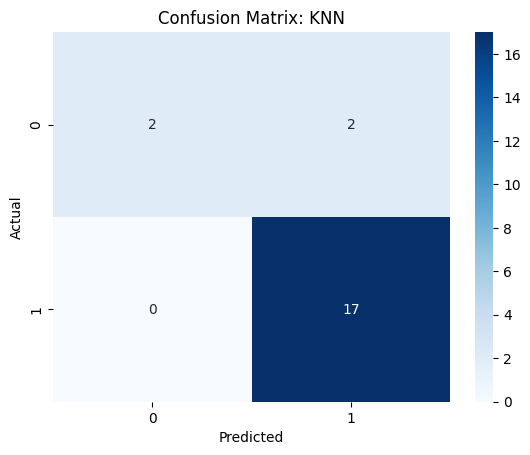

Accuracy for KNN: 0.9048

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.89      1.00      0.94        17

    accuracy                           0.90        21
   macro avg       0.95      0.75      0.81        21
weighted avg       0.91      0.90      0.89        21



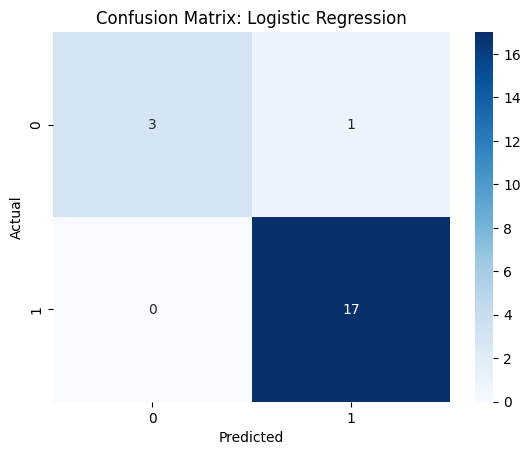

Accuracy for Logistic Regression: 0.9524

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.94      1.00      0.97        17

    accuracy                           0.95        21
   macro avg       0.97      0.88      0.91        21
weighted avg       0.96      0.95      0.95        21



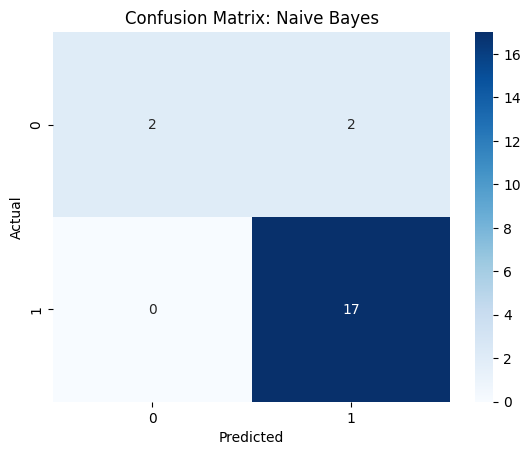

Accuracy for Naive Bayes: 0.9048

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.89      1.00      0.94        17

    accuracy                           0.90        21
   macro avg       0.95      0.75      0.81        21
weighted avg       0.91      0.90      0.89        21



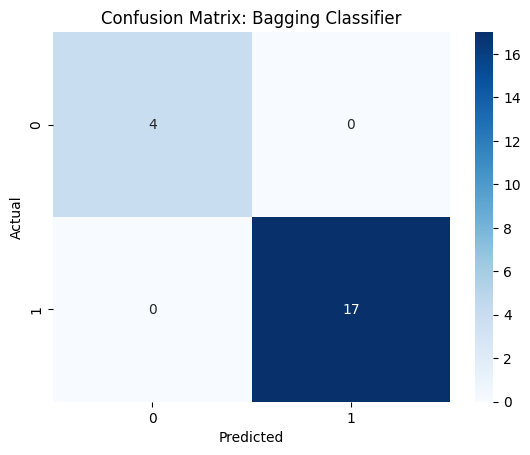

Accuracy for Bagging Classifier: 1.0000

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        17

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



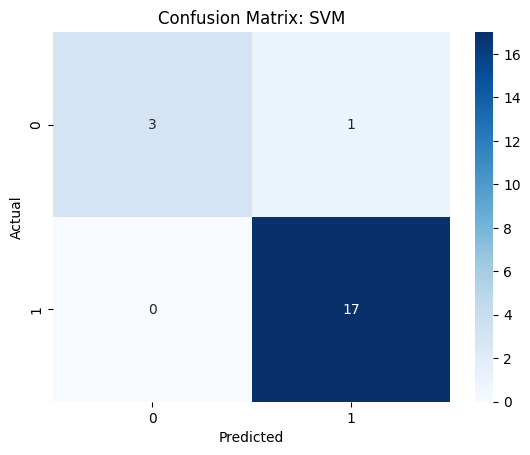

Accuracy for SVM: 0.9524

Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.94      1.00      0.97        17

    accuracy                           0.95        21
   macro avg       0.97      0.88      0.91        21
weighted avg       0.96      0.95      0.95        21



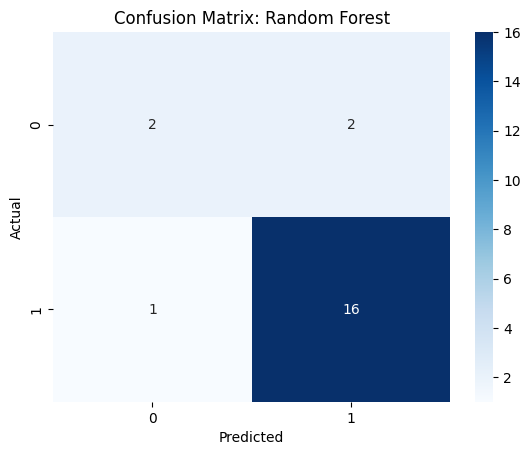

Accuracy for Random Forest: 0.8571

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.89      0.94      0.91        17

    accuracy                           0.86        21
   macro avg       0.78      0.72      0.74        21
weighted avg       0.85      0.86      0.85        21



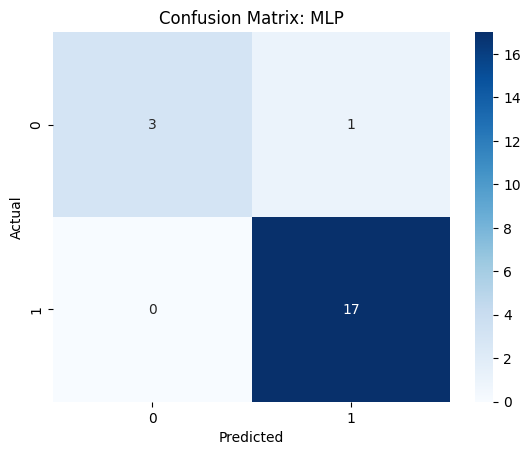

Accuracy for MLP: 0.9524

Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.94      1.00      0.97        17

    accuracy                           0.95        21
   macro avg       0.97      0.88      0.91        21
weighted avg       0.96      0.95      0.95        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:12:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


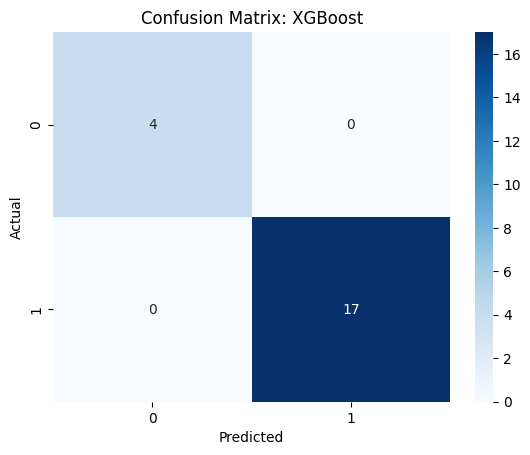

Accuracy for XGBoost: 1.0000

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        17

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



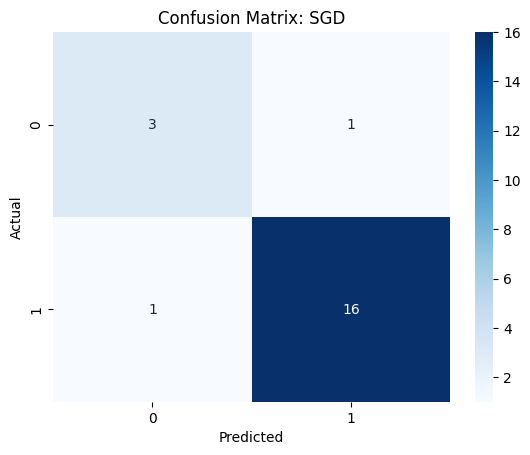

Accuracy for SGD: 0.9048

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.94      0.94      0.94        17

    accuracy                           0.90        21
   macro avg       0.85      0.85      0.85        21
weighted avg       0.90      0.90      0.90        21



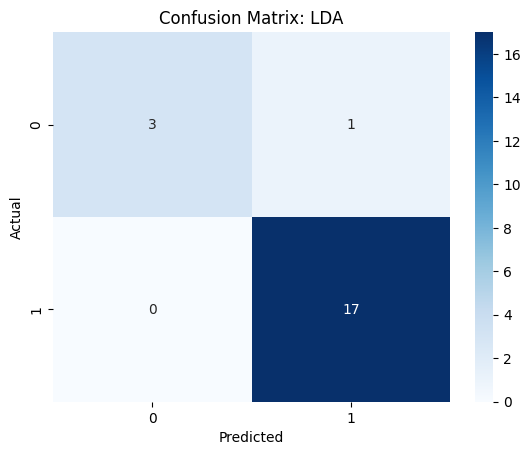

Accuracy for LDA: 0.9524

Classification Report for LDA:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.94      1.00      0.97        17

    accuracy                           0.95        21
   macro avg       0.97      0.88      0.91        21
weighted avg       0.96      0.95      0.95        21

Iteration 2/10


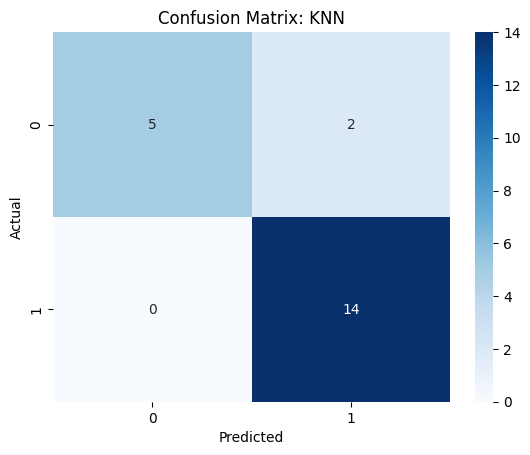

Accuracy for KNN: 0.9048

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.88      1.00      0.93        14

    accuracy                           0.90        21
   macro avg       0.94      0.86      0.88        21
weighted avg       0.92      0.90      0.90        21



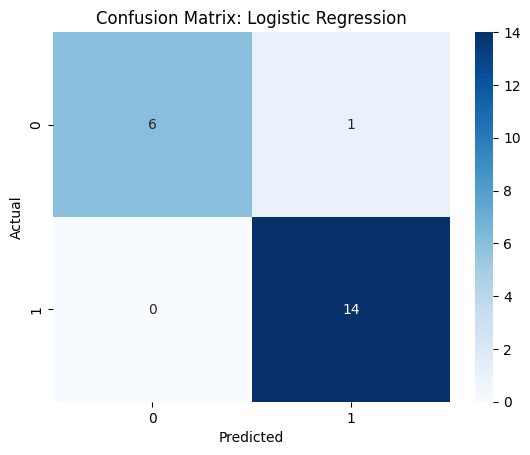

Accuracy for Logistic Regression: 0.9524

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.93      1.00      0.97        14

    accuracy                           0.95        21
   macro avg       0.97      0.93      0.94        21
weighted avg       0.96      0.95      0.95        21



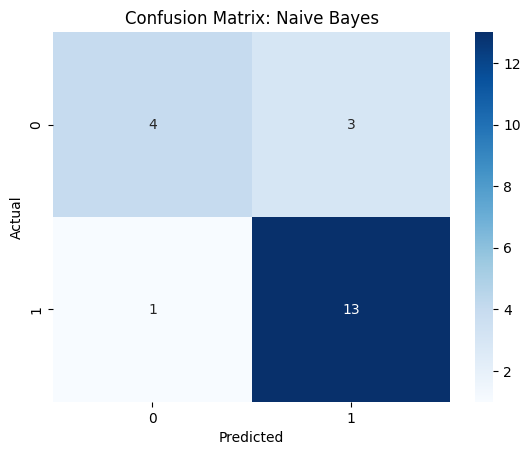

Accuracy for Naive Bayes: 0.8095

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.81      0.93      0.87        14

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21



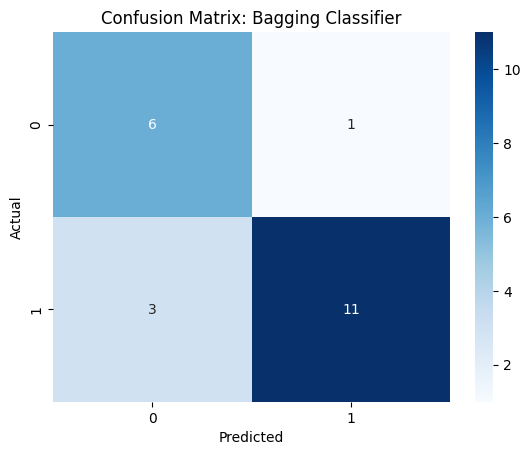

Accuracy for Bagging Classifier: 0.8095

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.67      0.86      0.75         7
           1       0.92      0.79      0.85        14

    accuracy                           0.81        21
   macro avg       0.79      0.82      0.80        21
weighted avg       0.83      0.81      0.81        21



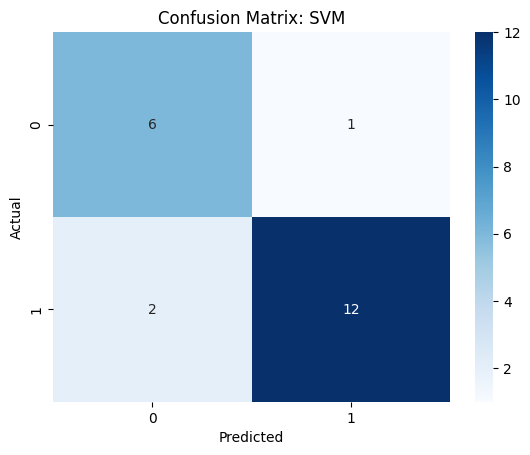

Accuracy for SVM: 0.8571

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21



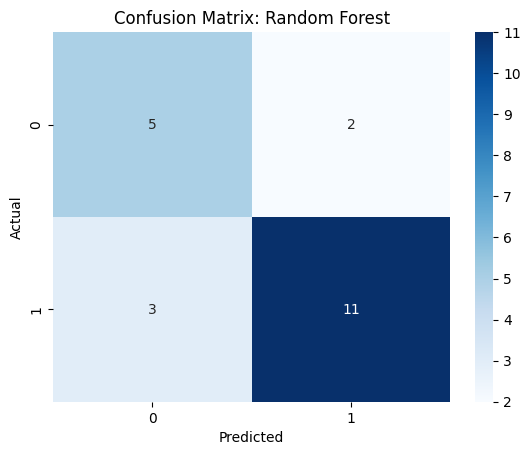

Accuracy for Random Forest: 0.7619

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.85      0.79      0.81        14

    accuracy                           0.76        21
   macro avg       0.74      0.75      0.74        21
weighted avg       0.77      0.76      0.77        21



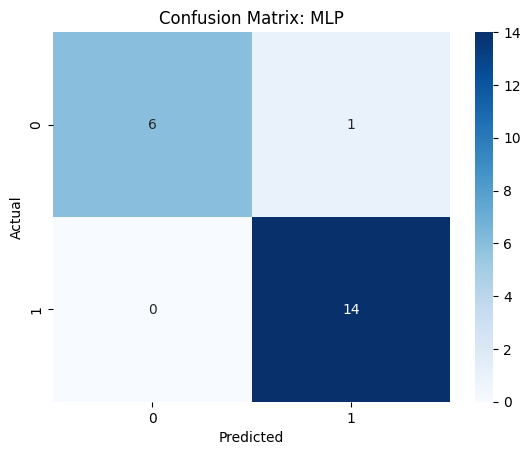

Accuracy for MLP: 0.9524

Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.93      1.00      0.97        14

    accuracy                           0.95        21
   macro avg       0.97      0.93      0.94        21
weighted avg       0.96      0.95      0.95        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:12:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


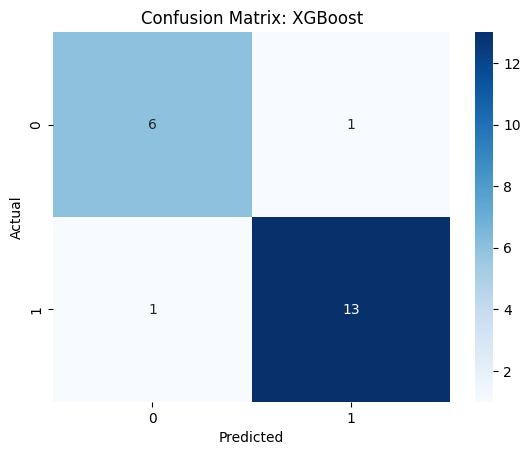

Accuracy for XGBoost: 0.9048

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.93      0.93      0.93        14

    accuracy                           0.90        21
   macro avg       0.89      0.89      0.89        21
weighted avg       0.90      0.90      0.90        21



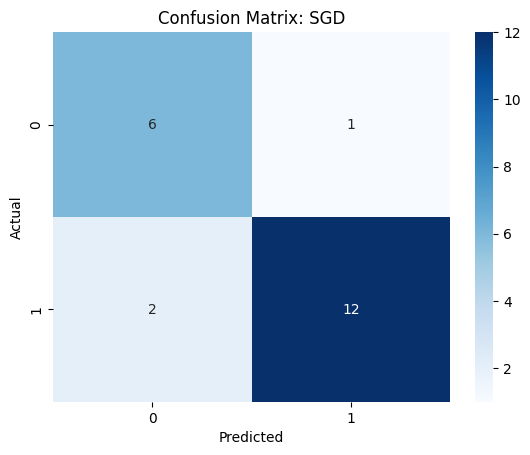

Accuracy for SGD: 0.8571

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21



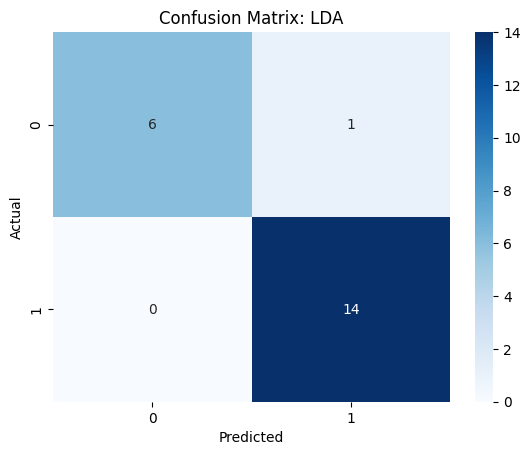

Accuracy for LDA: 0.9524

Classification Report for LDA:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.93      1.00      0.97        14

    accuracy                           0.95        21
   macro avg       0.97      0.93      0.94        21
weighted avg       0.96      0.95      0.95        21

Iteration 3/10


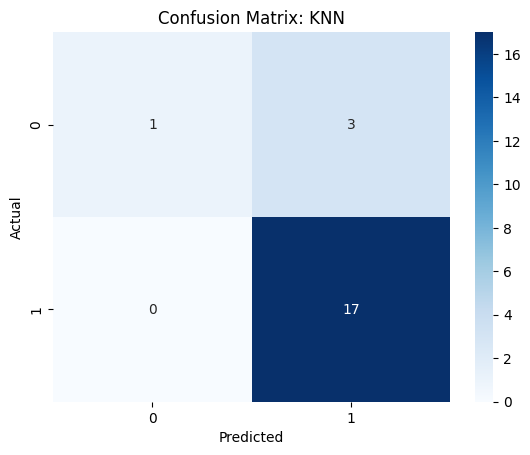

Accuracy for KNN: 0.8571

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.85      1.00      0.92        17

    accuracy                           0.86        21
   macro avg       0.93      0.62      0.66        21
weighted avg       0.88      0.86      0.82        21



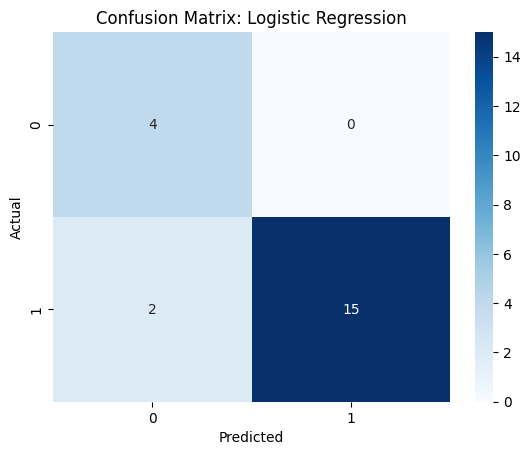

Accuracy for Logistic Regression: 0.9048

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.88      0.94        17

    accuracy                           0.90        21
   macro avg       0.83      0.94      0.87        21
weighted avg       0.94      0.90      0.91        21



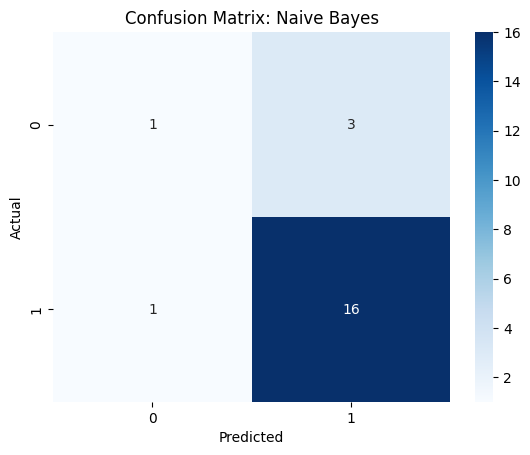

Accuracy for Naive Bayes: 0.8095

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.84      0.94      0.89        17

    accuracy                           0.81        21
   macro avg       0.67      0.60      0.61        21
weighted avg       0.78      0.81      0.78        21



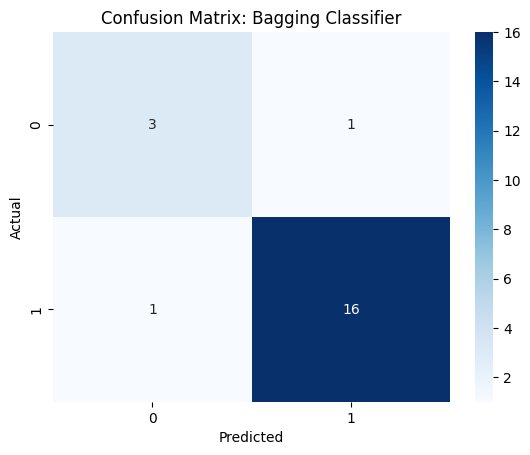

Accuracy for Bagging Classifier: 0.9048

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.94      0.94      0.94        17

    accuracy                           0.90        21
   macro avg       0.85      0.85      0.85        21
weighted avg       0.90      0.90      0.90        21



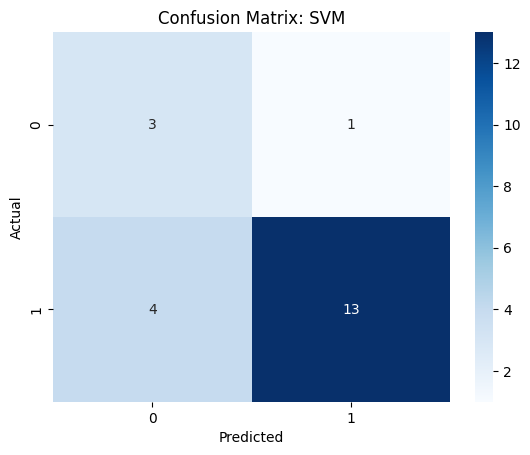

Accuracy for SVM: 0.7619

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.43      0.75      0.55         4
           1       0.93      0.76      0.84        17

    accuracy                           0.76        21
   macro avg       0.68      0.76      0.69        21
weighted avg       0.83      0.76      0.78        21



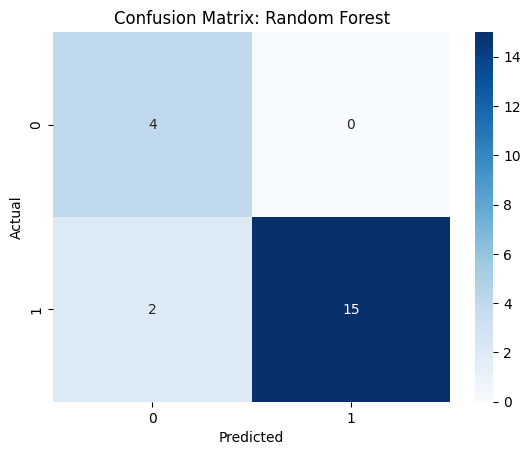

Accuracy for Random Forest: 0.9048

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.88      0.94        17

    accuracy                           0.90        21
   macro avg       0.83      0.94      0.87        21
weighted avg       0.94      0.90      0.91        21



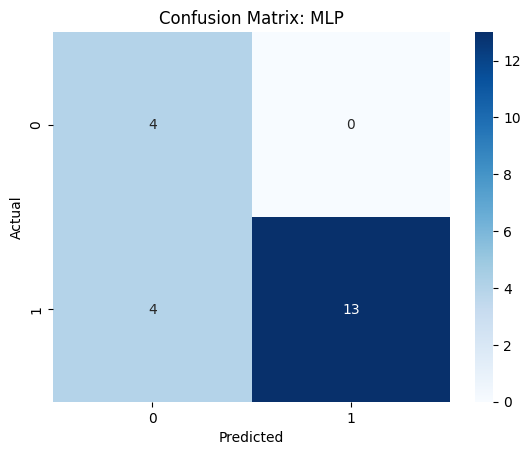

Accuracy for MLP: 0.8095

Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         4
           1       1.00      0.76      0.87        17

    accuracy                           0.81        21
   macro avg       0.75      0.88      0.77        21
weighted avg       0.90      0.81      0.83        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:12:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


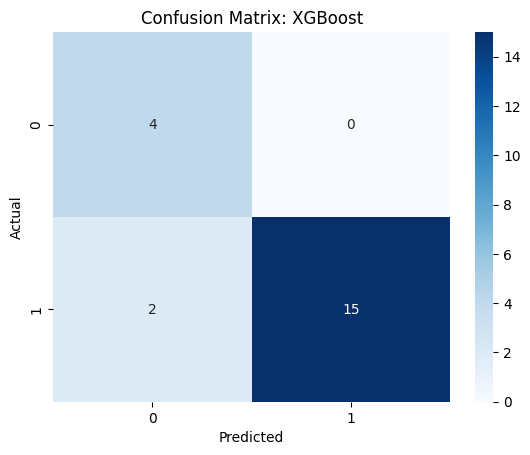

Accuracy for XGBoost: 0.9048

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.88      0.94        17

    accuracy                           0.90        21
   macro avg       0.83      0.94      0.87        21
weighted avg       0.94      0.90      0.91        21



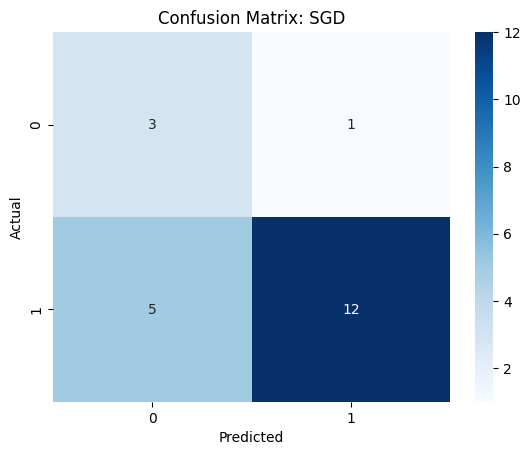

Accuracy for SGD: 0.7143

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.38      0.75      0.50         4
           1       0.92      0.71      0.80        17

    accuracy                           0.71        21
   macro avg       0.65      0.73      0.65        21
weighted avg       0.82      0.71      0.74        21



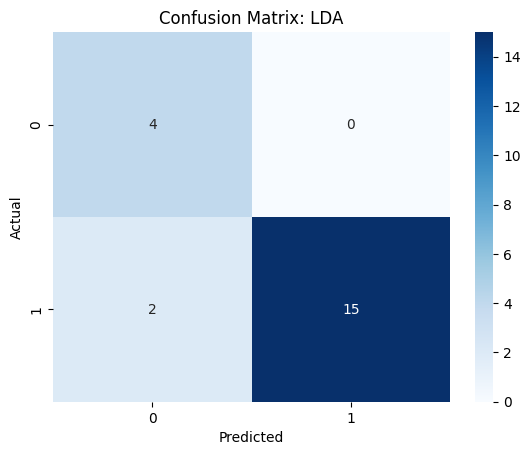

Accuracy for LDA: 0.9048

Classification Report for LDA:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       1.00      0.88      0.94        17

    accuracy                           0.90        21
   macro avg       0.83      0.94      0.87        21
weighted avg       0.94      0.90      0.91        21

Iteration 4/10


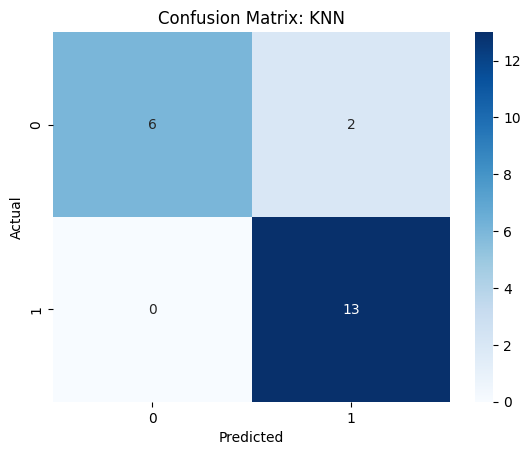

Accuracy for KNN: 0.9048

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.87      1.00      0.93        13

    accuracy                           0.90        21
   macro avg       0.93      0.88      0.89        21
weighted avg       0.92      0.90      0.90        21



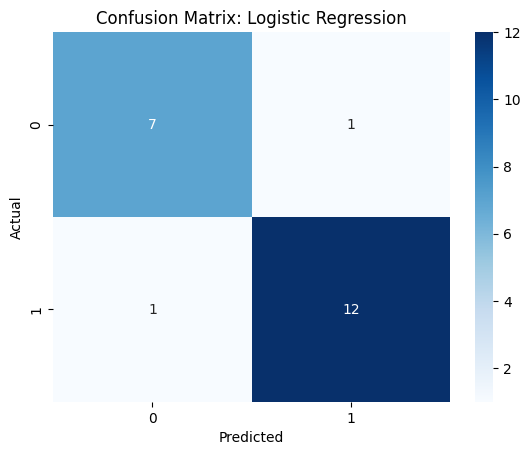

Accuracy for Logistic Regression: 0.9048

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.92      0.92      0.92        13

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



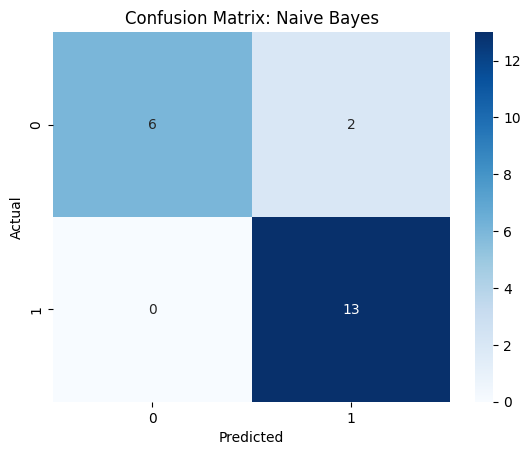

Accuracy for Naive Bayes: 0.9048

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.87      1.00      0.93        13

    accuracy                           0.90        21
   macro avg       0.93      0.88      0.89        21
weighted avg       0.92      0.90      0.90        21



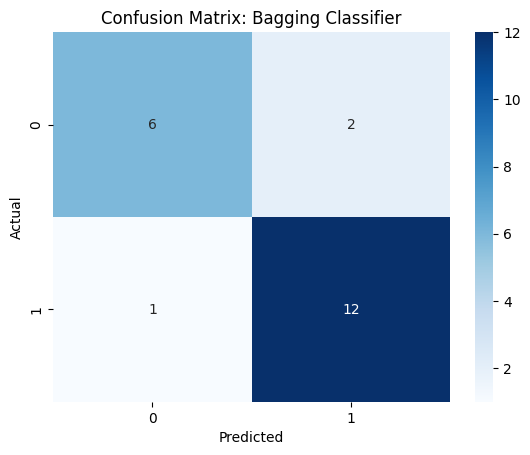

Accuracy for Bagging Classifier: 0.8571

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.86      0.92      0.89        13

    accuracy                           0.86        21
   macro avg       0.86      0.84      0.84        21
weighted avg       0.86      0.86      0.86        21



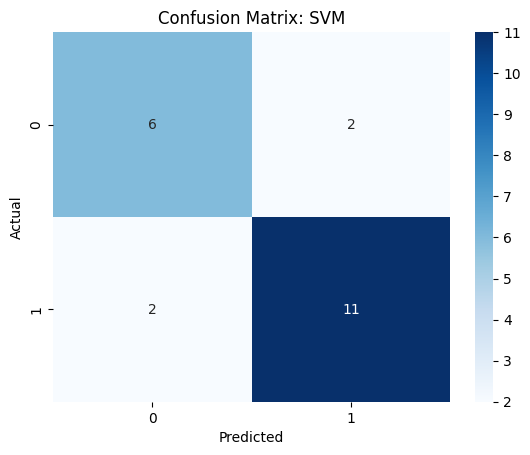

Accuracy for SVM: 0.8095

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.85      0.85      0.85        13

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21



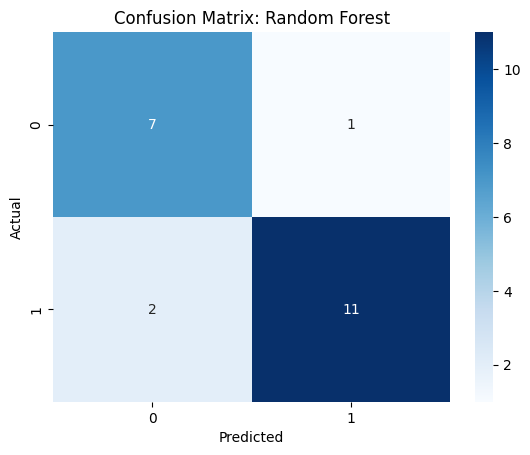

Accuracy for Random Forest: 0.8571

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.92      0.85      0.88        13

    accuracy                           0.86        21
   macro avg       0.85      0.86      0.85        21
weighted avg       0.86      0.86      0.86        21



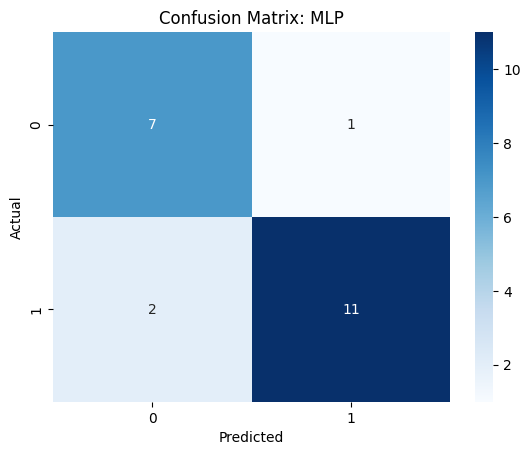

Accuracy for MLP: 0.8571

Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.92      0.85      0.88        13

    accuracy                           0.86        21
   macro avg       0.85      0.86      0.85        21
weighted avg       0.86      0.86      0.86        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:12:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


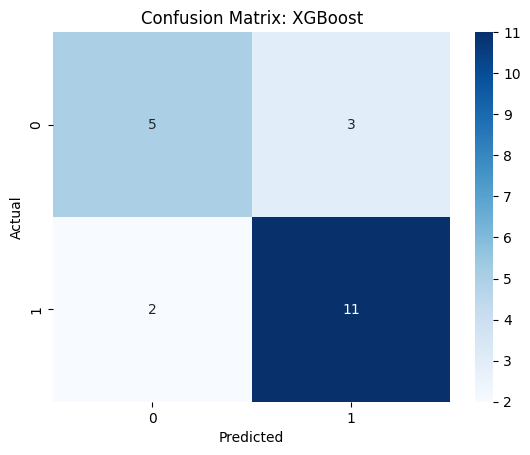

Accuracy for XGBoost: 0.7619

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.79      0.85      0.81        13

    accuracy                           0.76        21
   macro avg       0.75      0.74      0.74        21
weighted avg       0.76      0.76      0.76        21



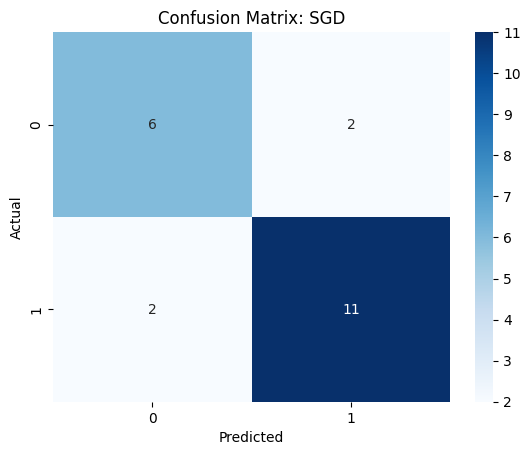

Accuracy for SGD: 0.8095

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.85      0.85      0.85        13

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21



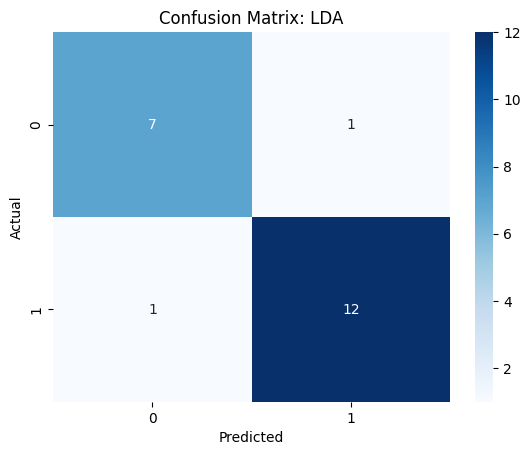

Accuracy for LDA: 0.9048

Classification Report for LDA:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.92      0.92      0.92        13

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21

Iteration 5/10


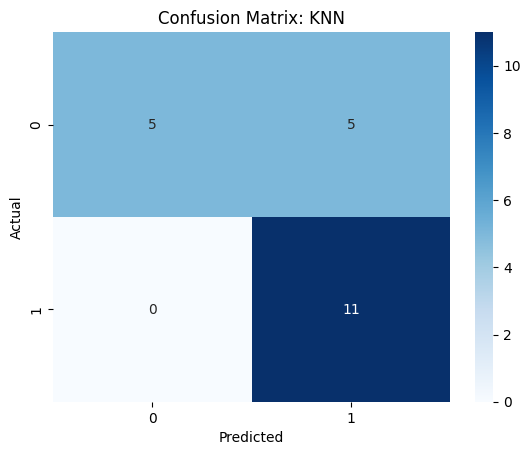

Accuracy for KNN: 0.7619

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.69      1.00      0.81        11

    accuracy                           0.76        21
   macro avg       0.84      0.75      0.74        21
weighted avg       0.84      0.76      0.74        21



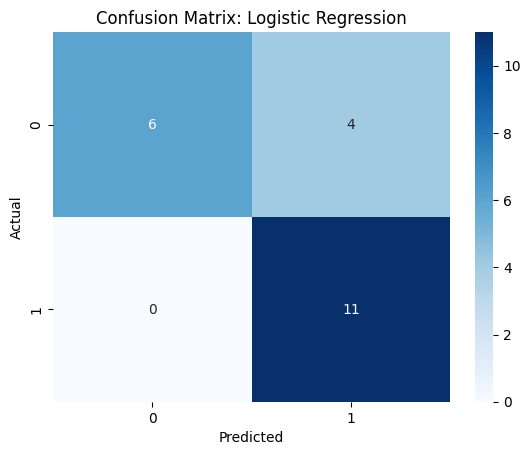

Accuracy for Logistic Regression: 0.8095

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.73      1.00      0.85        11

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21



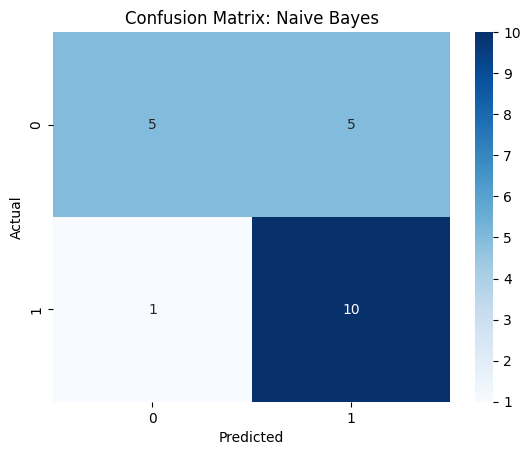

Accuracy for Naive Bayes: 0.7143

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.67      0.91      0.77        11

    accuracy                           0.71        21
   macro avg       0.75      0.70      0.70        21
weighted avg       0.75      0.71      0.70        21



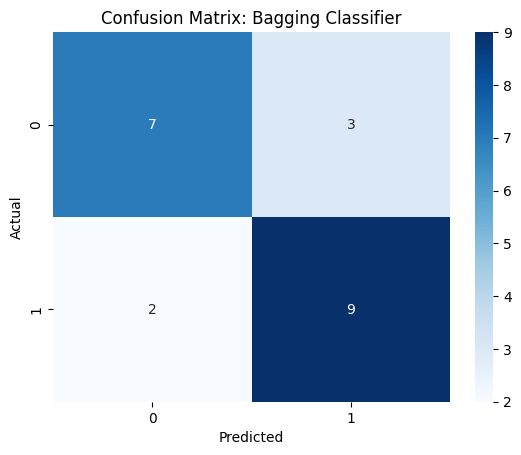

Accuracy for Bagging Classifier: 0.7619

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.75      0.82      0.78        11

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.76      0.76      0.76        21



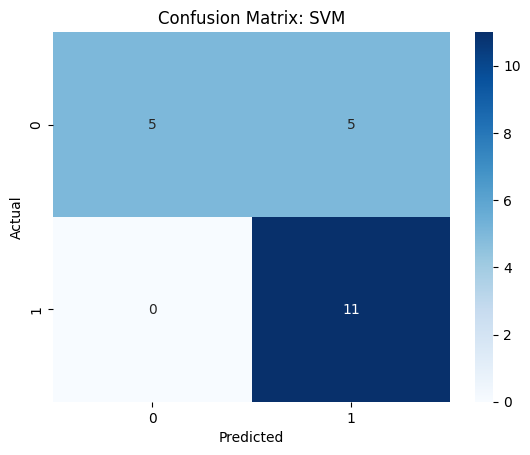

Accuracy for SVM: 0.7619

Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.69      1.00      0.81        11

    accuracy                           0.76        21
   macro avg       0.84      0.75      0.74        21
weighted avg       0.84      0.76      0.74        21



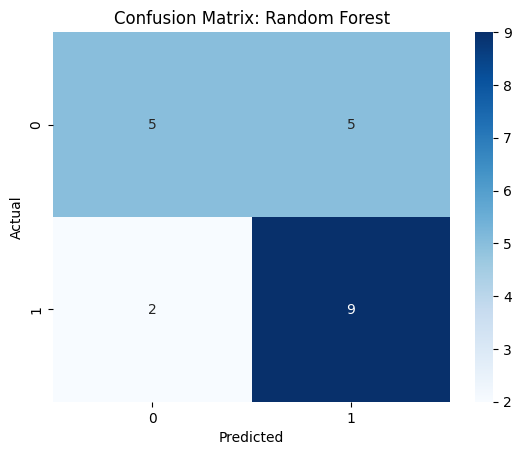

Accuracy for Random Forest: 0.6667

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.50      0.59        10
           1       0.64      0.82      0.72        11

    accuracy                           0.67        21
   macro avg       0.68      0.66      0.65        21
weighted avg       0.68      0.67      0.66        21



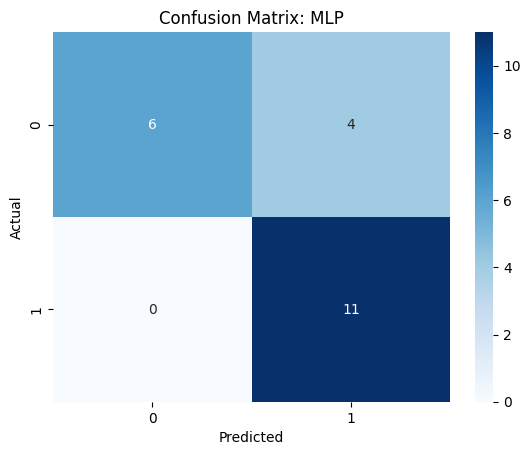

Accuracy for MLP: 0.8095

Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.73      1.00      0.85        11

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:12:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


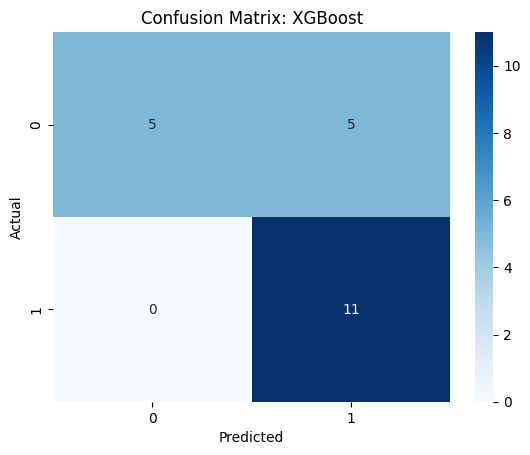

Accuracy for XGBoost: 0.7619

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        10
           1       0.69      1.00      0.81        11

    accuracy                           0.76        21
   macro avg       0.84      0.75      0.74        21
weighted avg       0.84      0.76      0.74        21



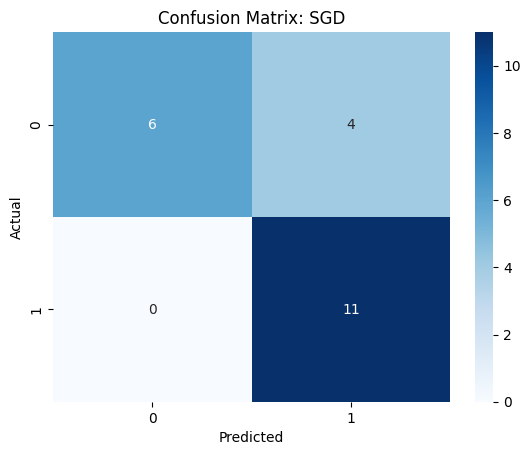

Accuracy for SGD: 0.8095

Classification Report for SGD:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.73      1.00      0.85        11

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21



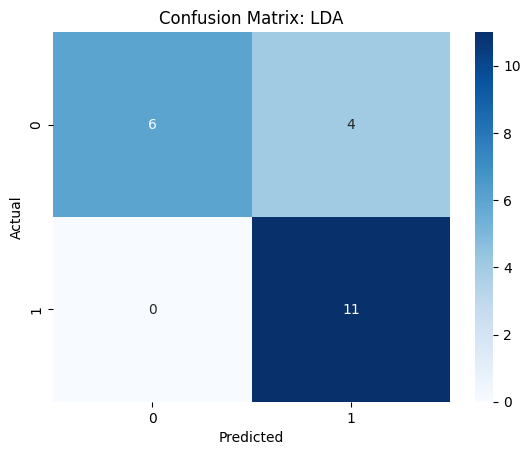

Accuracy for LDA: 0.8095

Classification Report for LDA:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.73      1.00      0.85        11

    accuracy                           0.81        21
   macro avg       0.87      0.80      0.80        21
weighted avg       0.86      0.81      0.80        21

Iteration 6/10


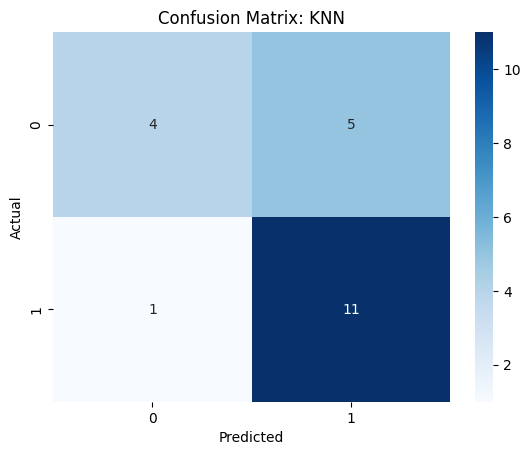

Accuracy for KNN: 0.7143

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.69      0.92      0.79        12

    accuracy                           0.71        21
   macro avg       0.74      0.68      0.68        21
weighted avg       0.74      0.71      0.69        21



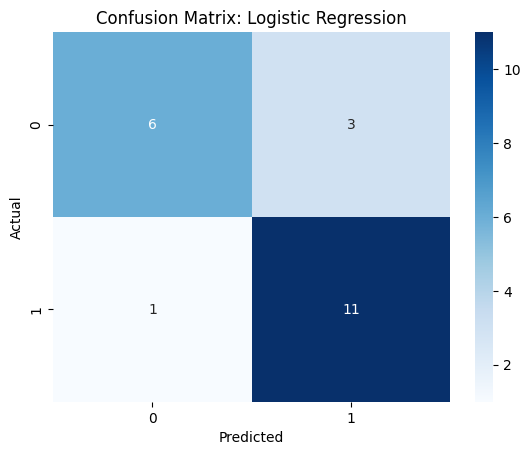

Accuracy for Logistic Regression: 0.8095

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.79      0.92      0.85        12

    accuracy                           0.81        21
   macro avg       0.82      0.79      0.80        21
weighted avg       0.82      0.81      0.80        21



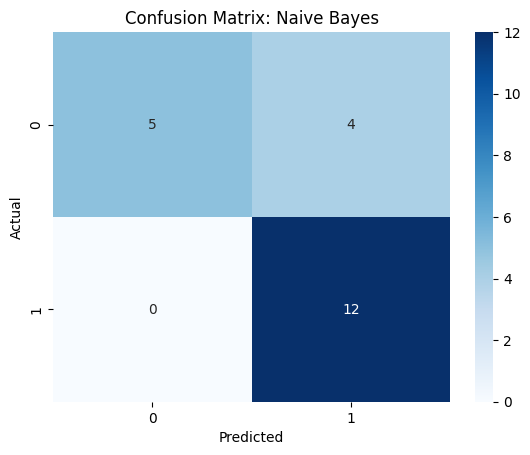

Accuracy for Naive Bayes: 0.8095

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.75      1.00      0.86        12

    accuracy                           0.81        21
   macro avg       0.88      0.78      0.79        21
weighted avg       0.86      0.81      0.80        21



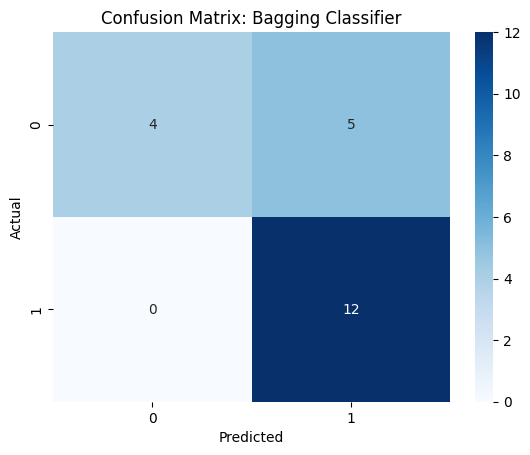

Accuracy for Bagging Classifier: 0.7619

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.71      1.00      0.83        12

    accuracy                           0.76        21
   macro avg       0.85      0.72      0.72        21
weighted avg       0.83      0.76      0.74        21



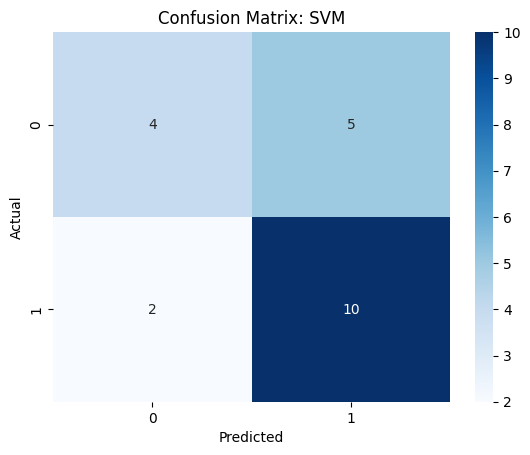

Accuracy for SVM: 0.6667

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.67      0.83      0.74        12

    accuracy                           0.67        21
   macro avg       0.67      0.64      0.64        21
weighted avg       0.67      0.67      0.65        21



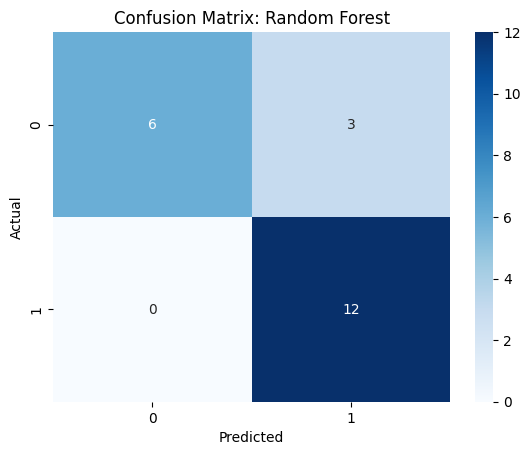

Accuracy for Random Forest: 0.8571

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.80      1.00      0.89        12

    accuracy                           0.86        21
   macro avg       0.90      0.83      0.84        21
weighted avg       0.89      0.86      0.85        21



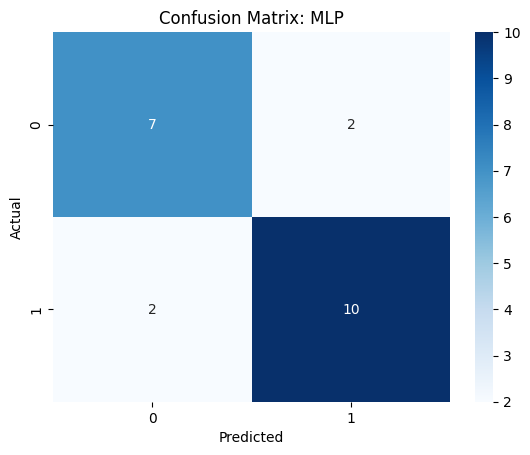

Accuracy for MLP: 0.8095

Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.83      0.83      0.83        12

    accuracy                           0.81        21
   macro avg       0.81      0.81      0.81        21
weighted avg       0.81      0.81      0.81        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:13:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


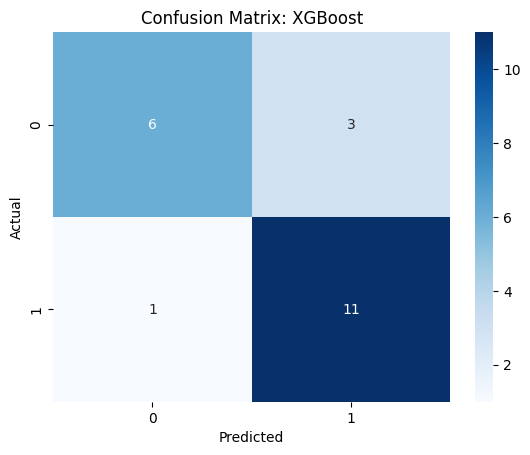

Accuracy for XGBoost: 0.8095

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.79      0.92      0.85        12

    accuracy                           0.81        21
   macro avg       0.82      0.79      0.80        21
weighted avg       0.82      0.81      0.80        21



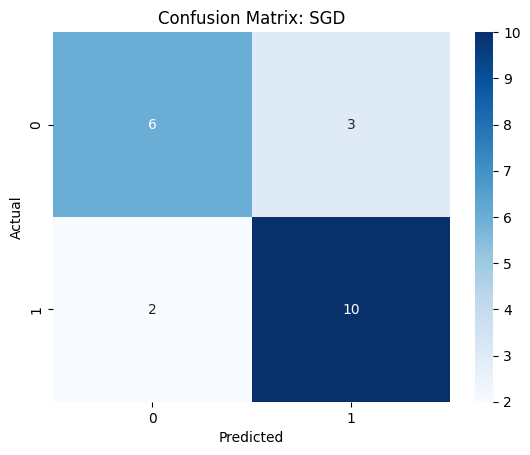

Accuracy for SGD: 0.7619

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.77      0.83      0.80        12

    accuracy                           0.76        21
   macro avg       0.76      0.75      0.75        21
weighted avg       0.76      0.76      0.76        21



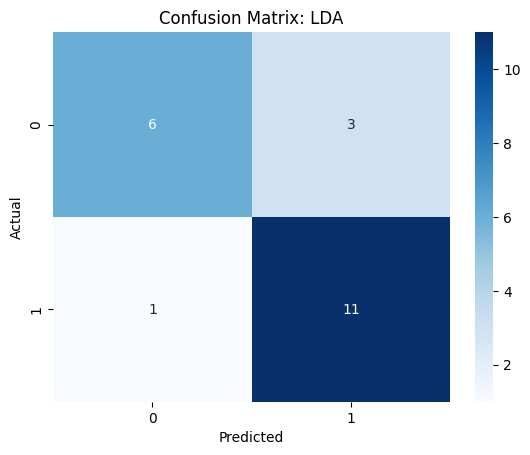

Accuracy for LDA: 0.8095

Classification Report for LDA:
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.79      0.92      0.85        12

    accuracy                           0.81        21
   macro avg       0.82      0.79      0.80        21
weighted avg       0.82      0.81      0.80        21

Iteration 7/10


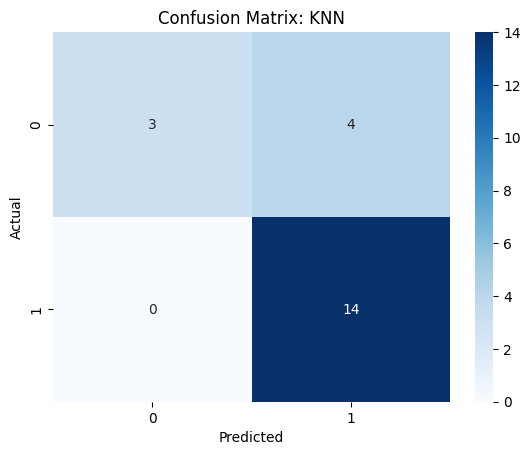

Accuracy for KNN: 0.8095

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.78      1.00      0.88        14

    accuracy                           0.81        21
   macro avg       0.89      0.71      0.74        21
weighted avg       0.85      0.81      0.78        21



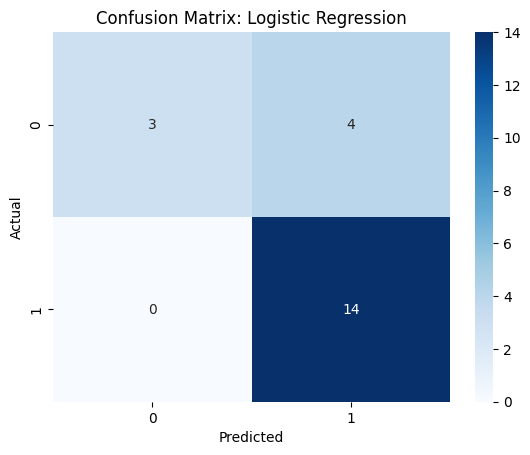

Accuracy for Logistic Regression: 0.8095

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.78      1.00      0.88        14

    accuracy                           0.81        21
   macro avg       0.89      0.71      0.74        21
weighted avg       0.85      0.81      0.78        21



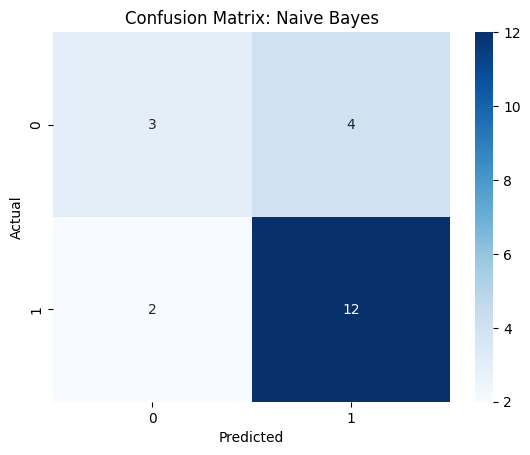

Accuracy for Naive Bayes: 0.7143

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.75      0.86      0.80        14

    accuracy                           0.71        21
   macro avg       0.68      0.64      0.65        21
weighted avg       0.70      0.71      0.70        21



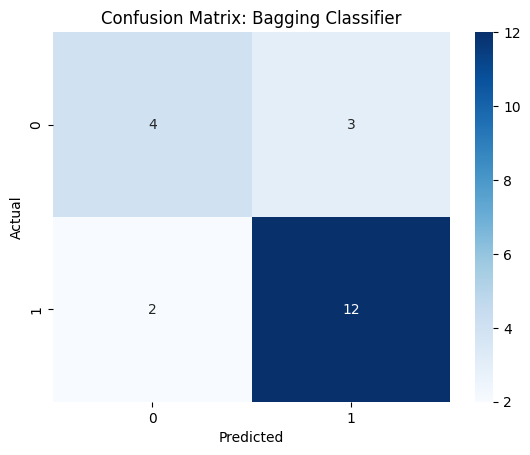

Accuracy for Bagging Classifier: 0.7619

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.67      0.57      0.62         7
           1       0.80      0.86      0.83        14

    accuracy                           0.76        21
   macro avg       0.73      0.71      0.72        21
weighted avg       0.76      0.76      0.76        21



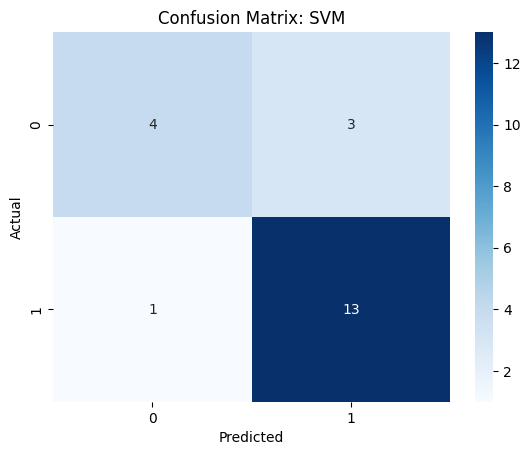

Accuracy for SVM: 0.8095

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.81      0.93      0.87        14

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21



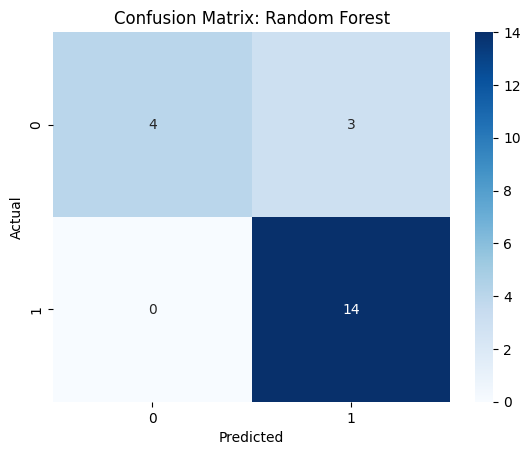

Accuracy for Random Forest: 0.8571

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.82      1.00      0.90        14

    accuracy                           0.86        21
   macro avg       0.91      0.79      0.82        21
weighted avg       0.88      0.86      0.84        21



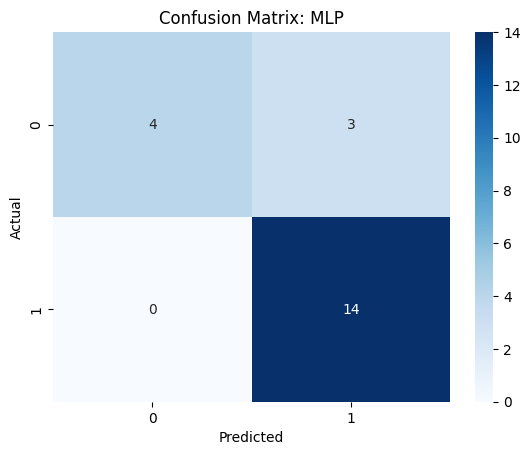

Accuracy for MLP: 0.8571

Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.82      1.00      0.90        14

    accuracy                           0.86        21
   macro avg       0.91      0.79      0.82        21
weighted avg       0.88      0.86      0.84        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:13:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


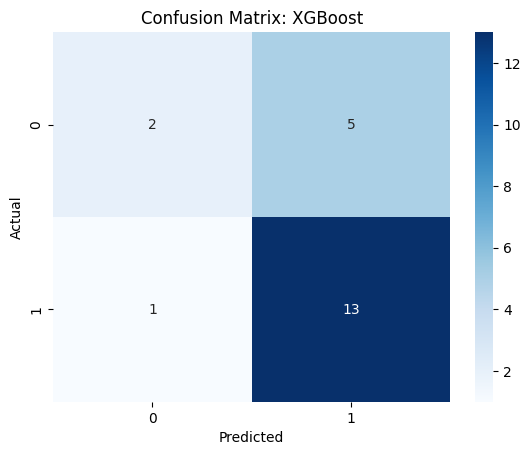

Accuracy for XGBoost: 0.7143

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.72      0.93      0.81        14

    accuracy                           0.71        21
   macro avg       0.69      0.61      0.61        21
weighted avg       0.70      0.71      0.68        21



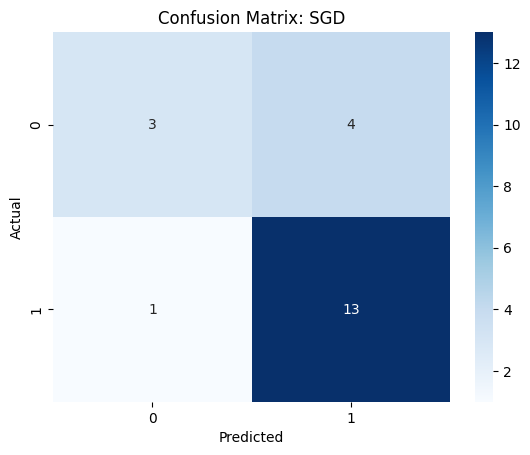

Accuracy for SGD: 0.7619

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.76      0.93      0.84        14

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21



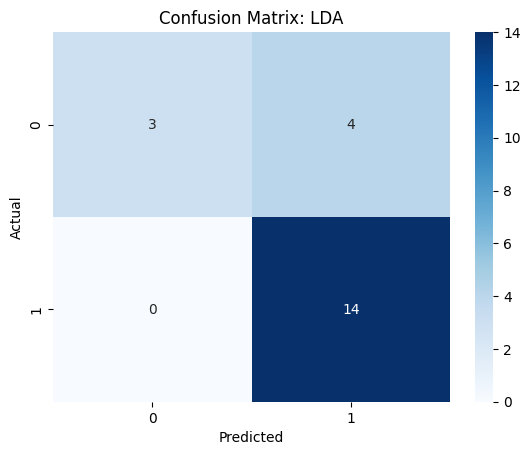

Accuracy for LDA: 0.8095

Classification Report for LDA:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.78      1.00      0.88        14

    accuracy                           0.81        21
   macro avg       0.89      0.71      0.74        21
weighted avg       0.85      0.81      0.78        21

Iteration 8/10


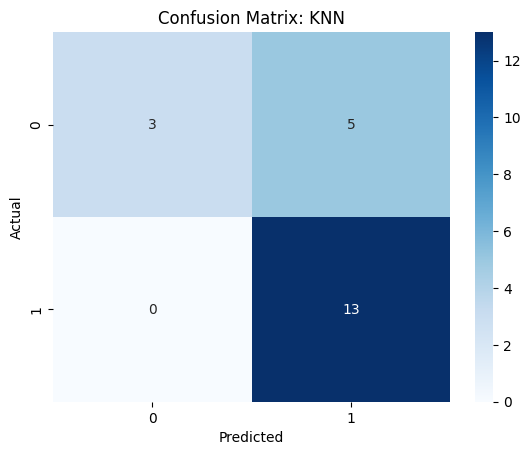

Accuracy for KNN: 0.7619

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.72      1.00      0.84        13

    accuracy                           0.76        21
   macro avg       0.86      0.69      0.69        21
weighted avg       0.83      0.76      0.73        21



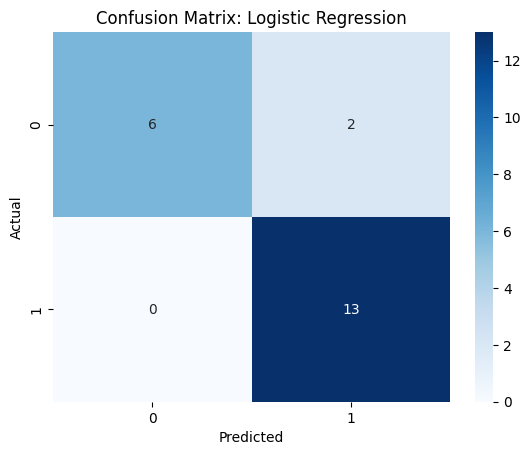

Accuracy for Logistic Regression: 0.9048

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.87      1.00      0.93        13

    accuracy                           0.90        21
   macro avg       0.93      0.88      0.89        21
weighted avg       0.92      0.90      0.90        21



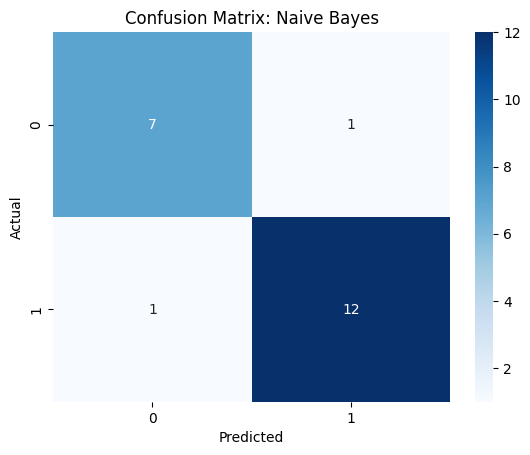

Accuracy for Naive Bayes: 0.9048

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.92      0.92      0.92        13

    accuracy                           0.90        21
   macro avg       0.90      0.90      0.90        21
weighted avg       0.90      0.90      0.90        21



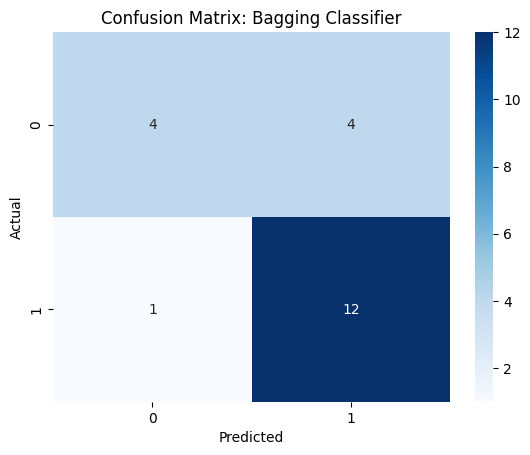

Accuracy for Bagging Classifier: 0.7619

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.75      0.92      0.83        13

    accuracy                           0.76        21
   macro avg       0.78      0.71      0.72        21
weighted avg       0.77      0.76      0.75        21



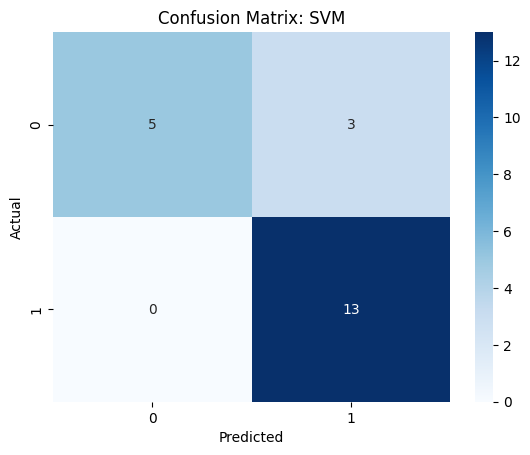

Accuracy for SVM: 0.8571

Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.81      1.00      0.90        13

    accuracy                           0.86        21
   macro avg       0.91      0.81      0.83        21
weighted avg       0.88      0.86      0.85        21



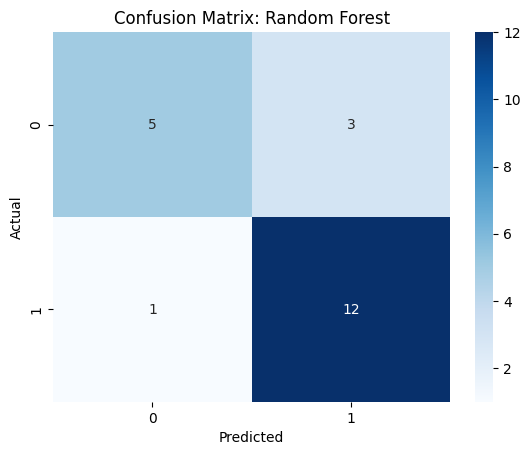

Accuracy for Random Forest: 0.8095

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.80      0.92      0.86        13

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21



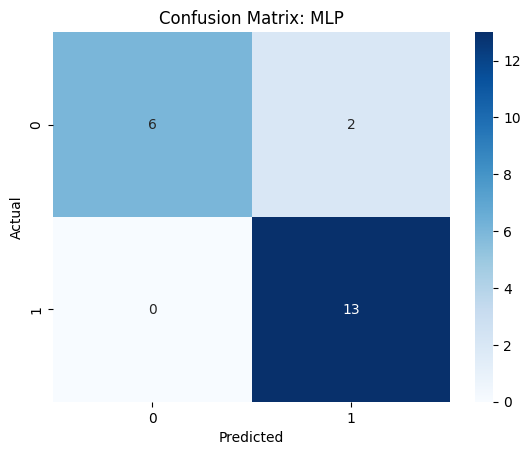

Accuracy for MLP: 0.9048

Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.87      1.00      0.93        13

    accuracy                           0.90        21
   macro avg       0.93      0.88      0.89        21
weighted avg       0.92      0.90      0.90        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:13:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


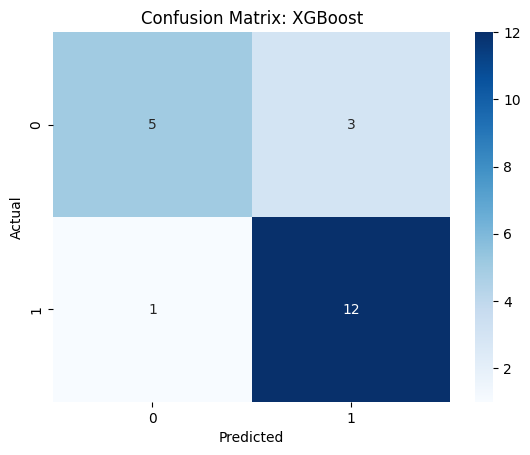

Accuracy for XGBoost: 0.8095

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.80      0.92      0.86        13

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21



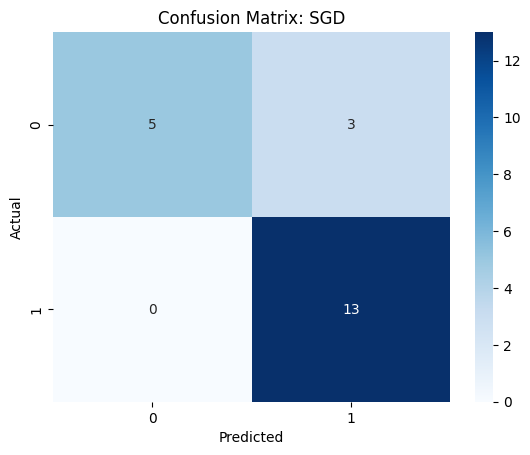

Accuracy for SGD: 0.8571

Classification Report for SGD:
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.81      1.00      0.90        13

    accuracy                           0.86        21
   macro avg       0.91      0.81      0.83        21
weighted avg       0.88      0.86      0.85        21



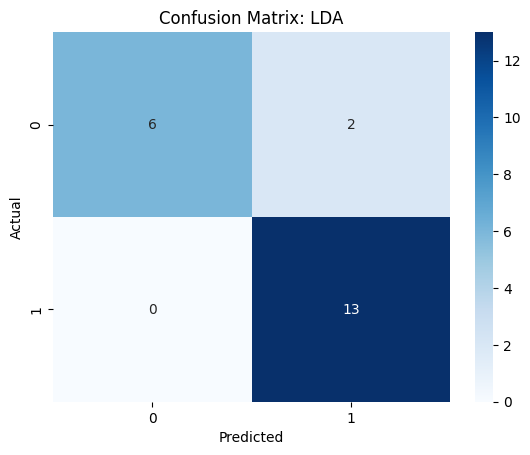

Accuracy for LDA: 0.9048

Classification Report for LDA:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.87      1.00      0.93        13

    accuracy                           0.90        21
   macro avg       0.93      0.88      0.89        21
weighted avg       0.92      0.90      0.90        21

Iteration 9/10


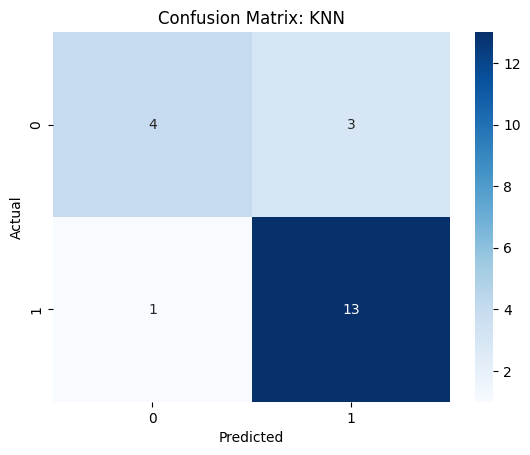

Accuracy for KNN: 0.8095

Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.81      0.93      0.87        14

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21



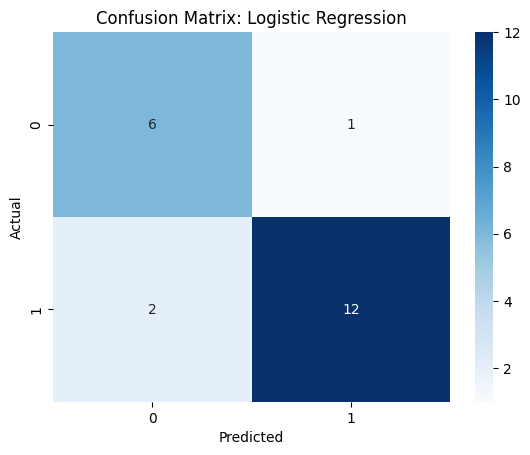

Accuracy for Logistic Regression: 0.8571

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21



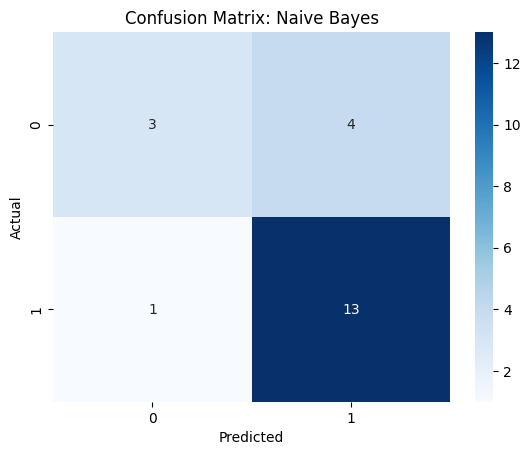

Accuracy for Naive Bayes: 0.7619

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.76      0.93      0.84        14

    accuracy                           0.76        21
   macro avg       0.76      0.68      0.69        21
weighted avg       0.76      0.76      0.74        21



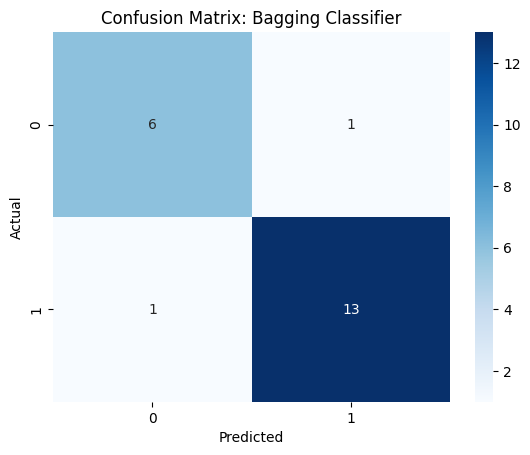

Accuracy for Bagging Classifier: 0.9048

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.93      0.93      0.93        14

    accuracy                           0.90        21
   macro avg       0.89      0.89      0.89        21
weighted avg       0.90      0.90      0.90        21



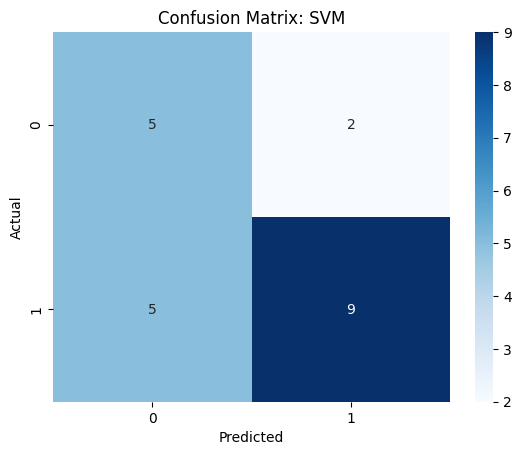

Accuracy for SVM: 0.6667

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.82      0.64      0.72        14

    accuracy                           0.67        21
   macro avg       0.66      0.68      0.65        21
weighted avg       0.71      0.67      0.68        21



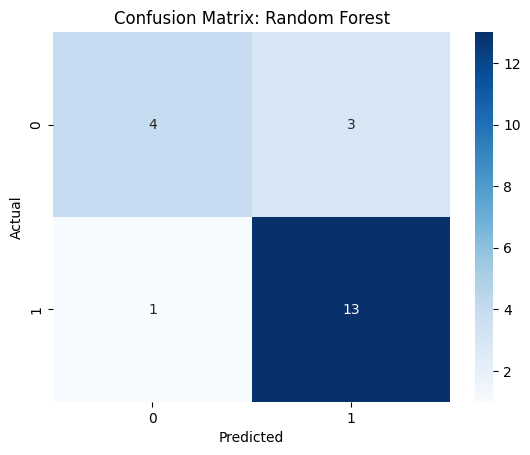

Accuracy for Random Forest: 0.8095

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.81      0.93      0.87        14

    accuracy                           0.81        21
   macro avg       0.81      0.75      0.77        21
weighted avg       0.81      0.81      0.80        21



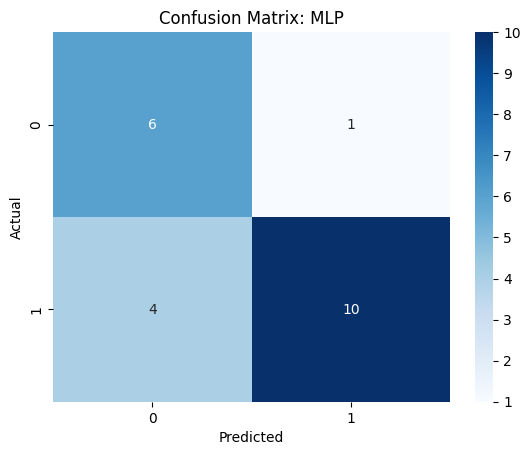

Accuracy for MLP: 0.7619

Classification Report for MLP:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.91      0.71      0.80        14

    accuracy                           0.76        21
   macro avg       0.75      0.79      0.75        21
weighted avg       0.81      0.76      0.77        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:13:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


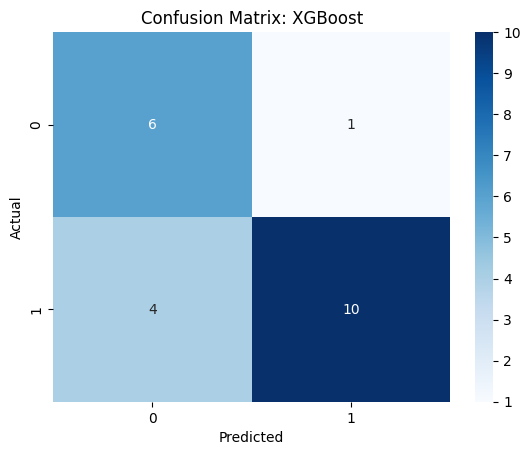

Accuracy for XGBoost: 0.7619

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.60      0.86      0.71         7
           1       0.91      0.71      0.80        14

    accuracy                           0.76        21
   macro avg       0.75      0.79      0.75        21
weighted avg       0.81      0.76      0.77        21



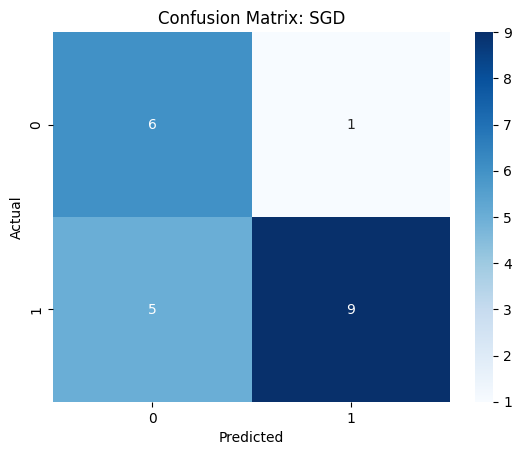

Accuracy for SGD: 0.7143

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.55      0.86      0.67         7
           1       0.90      0.64      0.75        14

    accuracy                           0.71        21
   macro avg       0.72      0.75      0.71        21
weighted avg       0.78      0.71      0.72        21



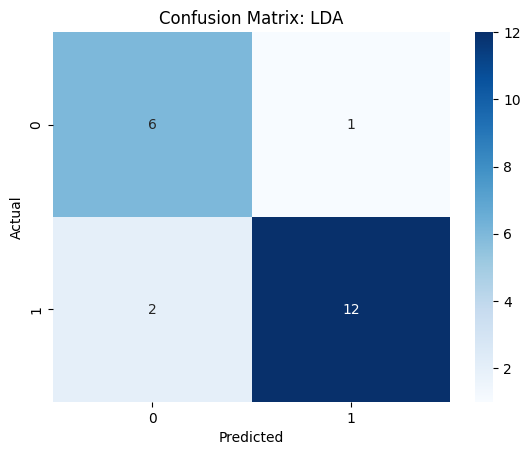

Accuracy for LDA: 0.8571

Classification Report for LDA:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.92      0.86      0.89        14

    accuracy                           0.86        21
   macro avg       0.84      0.86      0.84        21
weighted avg       0.87      0.86      0.86        21

Iteration 10/10


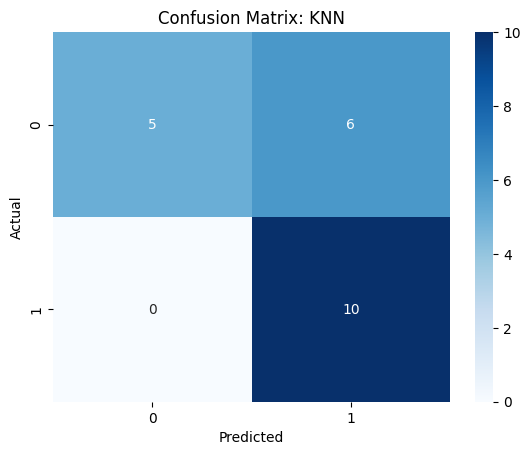

Accuracy for KNN: 0.7143

Classification Report for KNN:
              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.62      1.00      0.77        10

    accuracy                           0.71        21
   macro avg       0.81      0.73      0.70        21
weighted avg       0.82      0.71      0.69        21



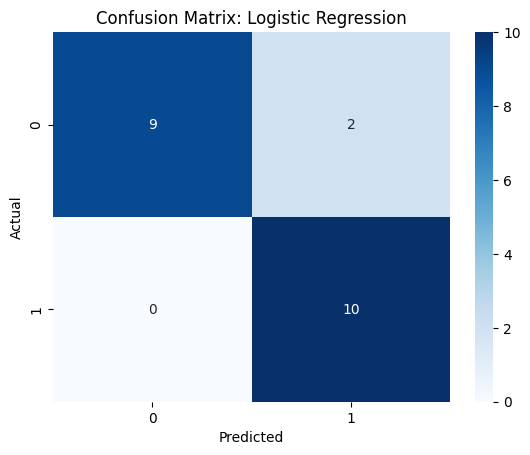

Accuracy for Logistic Regression: 0.9048

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.83      1.00      0.91        10

    accuracy                           0.90        21
   macro avg       0.92      0.91      0.90        21
weighted avg       0.92      0.90      0.90        21



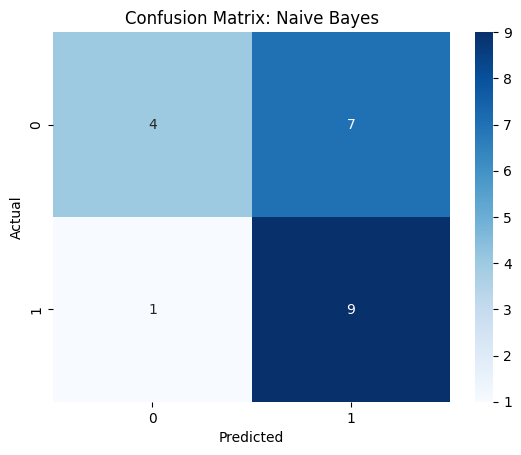

Accuracy for Naive Bayes: 0.6190

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.56      0.90      0.69        10

    accuracy                           0.62        21
   macro avg       0.68      0.63      0.60        21
weighted avg       0.69      0.62      0.59        21



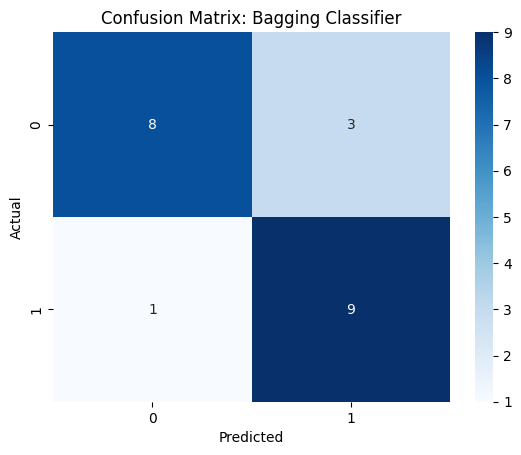

Accuracy for Bagging Classifier: 0.8095

Classification Report for Bagging Classifier:
              precision    recall  f1-score   support

           0       0.89      0.73      0.80        11
           1       0.75      0.90      0.82        10

    accuracy                           0.81        21
   macro avg       0.82      0.81      0.81        21
weighted avg       0.82      0.81      0.81        21



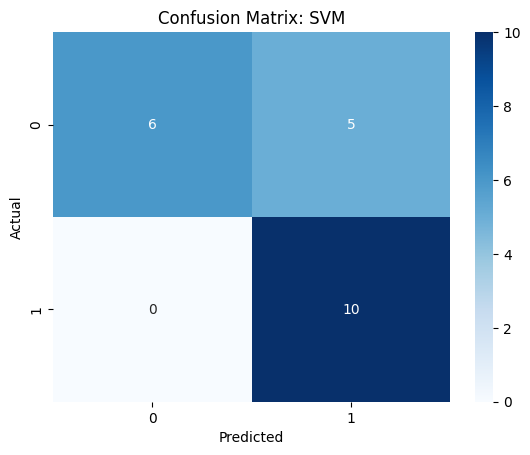

Accuracy for SVM: 0.7619

Classification Report for SVM:
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        11
           1       0.67      1.00      0.80        10

    accuracy                           0.76        21
   macro avg       0.83      0.77      0.75        21
weighted avg       0.84      0.76      0.75        21



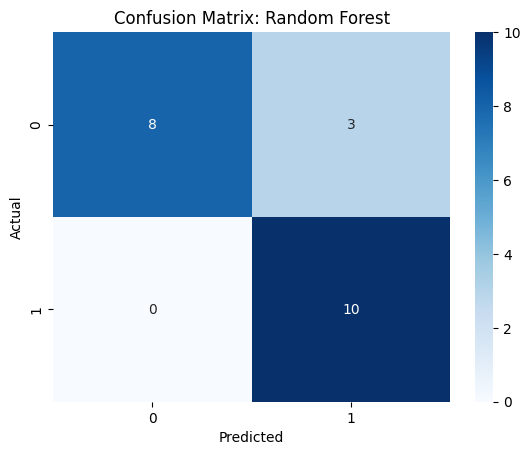

Accuracy for Random Forest: 0.8571

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.77      1.00      0.87        10

    accuracy                           0.86        21
   macro avg       0.88      0.86      0.86        21
weighted avg       0.89      0.86      0.86        21



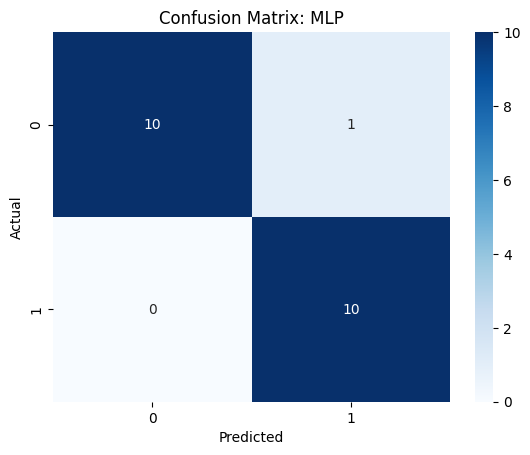

Accuracy for MLP: 0.9524

Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.91      1.00      0.95        10

    accuracy                           0.95        21
   macro avg       0.95      0.95      0.95        21
weighted avg       0.96      0.95      0.95        21



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:13:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


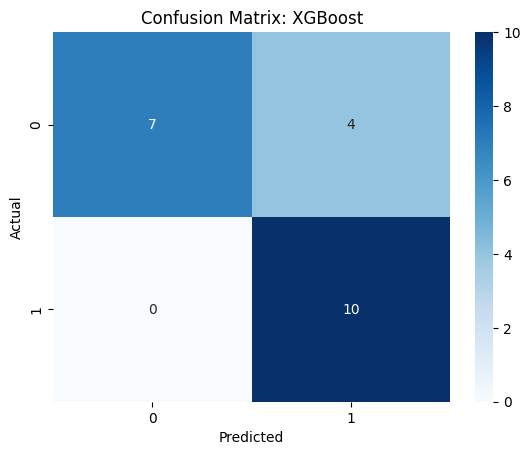

Accuracy for XGBoost: 0.8095

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        11
           1       0.71      1.00      0.83        10

    accuracy                           0.81        21
   macro avg       0.86      0.82      0.81        21
weighted avg       0.86      0.81      0.80        21



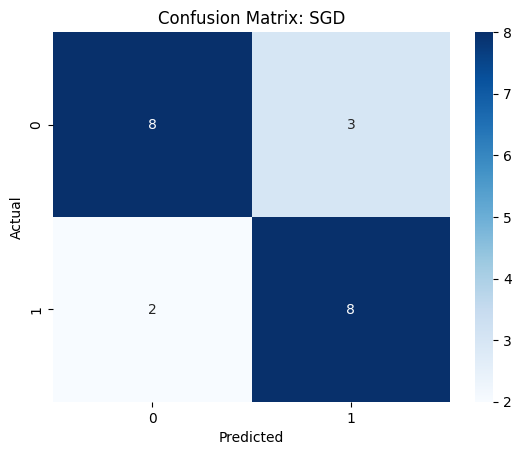

Accuracy for SGD: 0.7619

Classification Report for SGD:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76        11
           1       0.73      0.80      0.76        10

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21



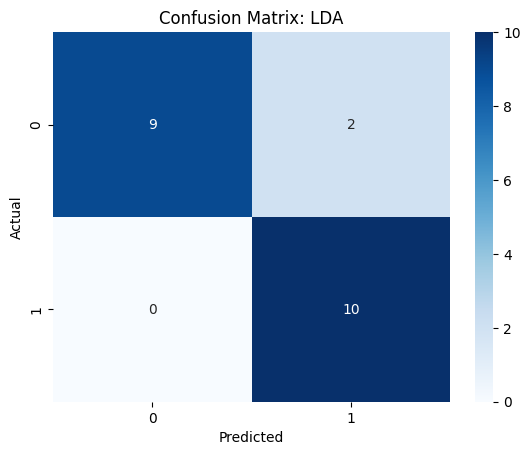

Accuracy for LDA: 0.9048

Classification Report for LDA:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.83      1.00      0.91        10

    accuracy                           0.90        21
   macro avg       0.92      0.91      0.90        21
weighted avg       0.92      0.90      0.90        21

Accuracy results per iteration: {'KNN': [0.9047619047619048, 0.9047619047619048, 0.8571428571428571, 0.9047619047619048, 0.7619047619047619, 0.7142857142857143, 0.8095238095238095, 0.7619047619047619, 0.8095238095238095, 0.7142857142857143], 'Logistic Regression': [0.9523809523809523, 0.9523809523809523, 0.9047619047619048, 0.9047619047619048, 0.8095238095238095, 0.8095238095238095, 0.8095238095238095, 0.9047619047619048, 0.8571428571428571, 0.9047619047619048], 'Naive Bayes': [0.9047619047619048, 0.8095238095238095, 0.8095238095238095, 0.9047619047619048, 0.7142857142857143, 0.8095238095238095, 0.71428571428

In [ ]:
# Number of iterations
n_iterations = 10

# Initialize lists to store evaluation results for each iteration
accuracy_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                    'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
precision_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                     'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
recall_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                  'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
f1_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
              'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}

# Main loop over n iterations
for i in range(n_iterations):
    print(f"Iteration {i + 1}/{n_iterations}")
    seed_value = random.randint(0, 10000)  # Generate a new random_state for each iteration

    # Split data into temp (80%) and test sets (20%)
    X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=seed_value)


    # Initialize and evaluate each model with the best hyperparameters

    # K-Nearest Neighbors
    knn_model = KNeighborsClassifier(n_neighbors=best_model_knn.get_params()['n_neighbors'])
    knn_model.fit(X_train, y_train)
    accuracy_knn, precision_knn, recall_knn, f1_knn = evaluate_model(knn_model, X_test, y_test, "KNN")
    accuracy_results['KNN'].append(accuracy_knn)
    precision_results['KNN'].append(precision_knn)
    recall_results['KNN'].append(recall_knn)
    f1_results['KNN'].append(f1_knn)

    # Logistic Regression
    lr_model = LogisticRegression(**best_model_lr.get_params())
    lr_model.fit(X_train, y_train)
    accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
    accuracy_results['Logistic Regression'].append(accuracy_lr)
    precision_results['Logistic Regression'].append(precision_lr)
    recall_results['Logistic Regression'].append(recall_lr)
    f1_results['Logistic Regression'].append(f1_lr)

    # Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_model(nb_model, X_test, y_test, "Naive Bayes")
    accuracy_results['Naive Bayes'].append(accuracy_nb)
    precision_results['Naive Bayes'].append(precision_nb)
    recall_results['Naive Bayes'].append(recall_nb)
    f1_results['Naive Bayes'].append(f1_nb)

    # Bagging Classifier
    # Get parameters without the 'estimator__' prefix
    bagging_params = {key: value for key, value in best_model_bagging.get_params().items() if not key.startswith('estimator__')}
    bagging_model = BaggingClassifier(**bagging_params)
    bagging_model.fit(X_train, y_train)
    accuracy_bagging, precision_bagging, recall_bagging, f1_bagging = evaluate_model(bagging_model, X_test, y_test, "Bagging Classifier")
    accuracy_results['Bagging Classifier'].append(accuracy_bagging)
    precision_results['Bagging Classifier'].append(precision_bagging)
    recall_results['Bagging Classifier'].append(recall_bagging)
    f1_results['Bagging Classifier'].append(f1_bagging)

    # Support Vector Machine
    svm_model = SVC(**best_model_svm.get_params())
    svm_model.fit(X_train, y_train)
    accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(svm_model, X_test, y_test, "SVM")
    accuracy_results['SVM'].append(accuracy_svm)
    precision_results['SVM'].append(precision_svm)
    recall_results['SVM'].append(recall_svm)
    f1_results['SVM'].append(f1_svm)

    # Random Forest
    rf_model = RandomForestClassifier(**best_model_rf.get_params())
    rf_model.fit(X_train, y_train)
    accuracy_rf, precision_rf, recall_rf, f1_rf = evaluate_model(rf_model, X_test, y_test, "Random Forest")
    accuracy_results['Random Forest'].append(accuracy_rf)
    precision_results['Random Forest'].append(precision_rf)
    recall_results['Random Forest'].append(recall_rf)
    f1_results['Random Forest'].append(f1_rf)

    # MLP Classifier
    mlp_model = MLPClassifier(**best_model_mlp.get_params())
    mlp_model.fit(X_train, y_train)
    accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(mlp_model, X_test, y_test, "MLP")
    accuracy_results['MLP'].append(accuracy_mlp)
    precision_results['MLP'].append(precision_mlp)
    recall_results['MLP'].append(recall_mlp)
    f1_results['MLP'].append(f1_mlp)

    # XGBoost
    xgb_model = XGBClassifier(**best_model_xgb.get_params())
    xgb_model.fit(X_train, y_train)
    accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
    accuracy_results['XGBoost'].append(accuracy_xgb)
    precision_results['XGBoost'].append(precision_xgb)
    recall_results['XGBoost'].append(recall_xgb)
    f1_results['XGBoost'].append(f1_xgb)

    # Stochastic Gradient Descent (SGD)
    # Valid parameters for SGDClassifier
    sgd_param_keys = ['loss', 'penalty', 'alpha', 'l1_ratio', 'fit_intercept', 'max_iter',
                      'tol', 'shuffle', 'random_state', 'learning_rate', 'eta0',
                      'power_t', 'early_stopping', 'validation_fraction', 'n_iter_no_change']

    # Extract only the valid parameters
    sgd_params = {key: value for key, value in best_model_sgd.get_params().items() if key in sgd_param_keys}

    # Create and fit the model
    sgd_model = SGDClassifier(**sgd_params)
    sgd_model.fit(X_train, y_train)
    accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = evaluate_model(sgd_model, X_test, y_test, "SGD")
    accuracy_results['SGD'].append(accuracy_sgd)
    precision_results['SGD'].append(precision_sgd)
    recall_results['SGD'].append(recall_sgd)
    f1_results['SGD'].append(f1_sgd)

    # Linear Discriminant Analysis (LDA)
    lda_model = LinearDiscriminantAnalysis(**best_model_lda.get_params())
    lda_model.fit(X_train, y_train)
    accuracy_lda, precision_lda, recall_lda, f1_lda = evaluate_model(lda_model, X_test, y_test, "LDA")
    accuracy_results['LDA'].append(accuracy_lda)
    precision_results['LDA'].append(precision_lda)
    recall_results['LDA'].append(recall_lda)
    f1_results['LDA'].append(f1_lda)

# Output results
print("Accuracy results per iteration:", accuracy_results)
print("Precision results per iteration:", precision_results)
print("Recall results per iteration:", recall_results)
print("F1 results per iteration:", f1_results)

best_hyperparams = {
    'KNN': best_model_knn.get_params(),
    'Logistic Regression': best_model_lr.get_params(),
    'Naive Bayes': {},  # No specific hyperparameters used here
    'Bagging Classifier': {key: value for key, value in best_model_bagging.get_params().items() if not key.startswith('estimator__')},
    'SVM': best_model_svm.get_params(),
    'Random Forest': best_model_rf.get_params(),
    'MLP': best_model_mlp.get_params(),
    'XGBoost': best_model_xgb.get_params(),
    'SGD': {key: value for key, value in best_model_sgd.get_params().items() if key in sgd_param_keys},
    'LDA': best_model_lda.get_params()
}

# Create a summary table
summary_data = {
    'Classifier': [],
    'Mean Accuracy': [],
    'Variance Accuracy': [],
    'Mean Precision': [],
    'Variance Precision': [],
    'Mean Recall': [],
    'Variance Recall': [],
    'Mean F1 Score': [],
    'Variance F1 Score': [],
    'Best Hyperparameters': []
}

# Populate the summary table with metrics and hyperparameters
for classifier, params in best_hyperparams.items():
    summary_data['Classifier'].append(classifier)
    summary_data['Mean Accuracy'].append(np.mean(accuracy_results[classifier]))
    summary_data['Variance Accuracy'].append(np.var(accuracy_results[classifier], ddof=1))
    summary_data['Mean Precision'].append(np.mean(precision_results[classifier]))
    summary_data['Variance Precision'].append(np.var(precision_results[classifier], ddof=1))
    summary_data['Mean Recall'].append(np.mean(recall_results[classifier]))
    summary_data['Variance Recall'].append(np.var(recall_results[classifier], ddof=1))
    summary_data['Mean F1 Score'].append(np.mean(f1_results[classifier]))
    summary_data['Variance F1 Score'].append(np.var(f1_results[classifier], ddof=1))
    summary_data['Best Hyperparameters'].append(params)  # Add hyperparameters

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Function to highlight the best values
def highlight_best(s):
    is_best = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_best]

# Apply the highlighting
styled_summary_df = summary_df.style.apply(highlight_best, subset=['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score'])

# Display the styled table
styled_summary_df


Cross-Validation with more iterations:

In [ ]:
# Define best hyperparameters from previous grid search
best_params_knn = best_model_knn.get_params()
best_params_lr = best_model_lr.get_params()
best_params_bagging = best_model_bagging.get_params()
best_params_svm = best_model_svm.get_params()
best_params_rf = best_model_rf.get_params()
best_params_mlp = best_model_mlp.get_params()
best_params_xgb = best_model_xgb.get_params()
best_params_sgd = best_model_sgd.get_params()
best_params_lda = best_model_lda.get_params()

# Initialize storage for results across multiple iterations
n_iterations = 10
cv_splits = 5
best_configs = []

# Initialize lists to store evaluation results for each iteration
accuracy_results = {model: [] for model in ['KNN', 'Logistic Regression', 'Naive Bayes', 'Bagging Classifier', 'SVM', 'Random Forest', 'MLP', 'XGBoost', 'SGD', 'LDA']}
precision_results = {model: [] for model in accuracy_results}
recall_results = {model: [] for model in accuracy_results}
f1_results = {model: [] for model in accuracy_results}

# Function to evaluate and return metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    precision = class_report['1']['precision']
    recall = class_report['1']['recall']
    f1 = class_report['1']['f1-score']
    return accuracy, precision, recall, f1

# Main loop for multiple iterations with different random states
for iteration in range(n_iterations):
    print(f"\nIteration {iteration + 1}/{n_iterations}")

    # Generate a random state for each iteration
    seed_value = random.randint(0, 10000)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=seed_value, stratify=y)
    scaler = StandardScaler()

    # K-Nearest Neighbors
    knn_model = KNeighborsClassifier(**best_params_knn)
    knn_model.fit(X_train, y_train)
    accuracy_knn, precision_knn, recall_knn, f1_knn = evaluate_model(knn_model, X_test, y_test)
    accuracy_results['KNN'].append(accuracy_knn)
    precision_results['KNN'].append(precision_knn)
    recall_results['KNN'].append(recall_knn)
    f1_results['KNN'].append(f1_knn)

    # Logistic Regression
    lr_model = LogisticRegression(**best_params_lr)
    lr_model.fit(X_train, y_train)
    accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(lr_model, X_test, y_test)
    accuracy_results['Logistic Regression'].append(accuracy_lr)
    precision_results['Logistic Regression'].append(precision_lr)
    recall_results['Logistic Regression'].append(recall_lr)
    f1_results['Logistic Regression'].append(f1_lr)

    # Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_model(nb_model, X_test, y_test)
    accuracy_results['Naive Bayes'].append(accuracy_nb)
    precision_results['Naive Bayes'].append(precision_nb)
    recall_results['Naive Bayes'].append(recall_nb)
    f1_results['Naive Bayes'].append(f1_nb)

    # Bagging Classifier
    bagging_params = {key: value for key, value in best_model_bagging.get_params().items() if not key.startswith('estimator__')}
    bagging_model = BaggingClassifier(**bagging_params)
    bagging_model.fit(X_train, y_train)
    accuracy_bagging, precision_bagging, recall_bagging, f1_bagging = evaluate_model(bagging_model, X_test, y_test)
    accuracy_results['Bagging Classifier'].append(accuracy_bagging)
    precision_results['Bagging Classifier'].append(precision_bagging)
    recall_results['Bagging Classifier'].append(recall_bagging)
    f1_results['Bagging Classifier'].append(f1_bagging)

    # SVM
    svm_model = SVC(**best_params_svm)
    svm_model.fit(scaler.fit_transform(X_train), y_train)
    accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(svm_model, scaler.transform(X_test), y_test)
    accuracy_results['SVM'].append(accuracy_svm)
    precision_results['SVM'].append(precision_svm)
    recall_results['SVM'].append(recall_svm)
    f1_results['SVM'].append(f1_svm)

    # Random Forest
    rf_model = RandomForestClassifier(**best_params_rf)
    rf_model.fit(X_train, y_train)
    accuracy_rf, precision_rf, recall_rf, f1_rf = evaluate_model(rf_model, X_test, y_test)
    accuracy_results['Random Forest'].append(accuracy_rf)
    precision_results['Random Forest'].append(precision_rf)
    recall_results['Random Forest'].append(recall_rf)
    f1_results['Random Forest'].append(f1_rf)

    # MLP
    mlp_model = MLPClassifier(**best_params_mlp)
    mlp_model.fit(scaler.fit_transform(X_train), y_train)
    accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(mlp_model, scaler.transform(X_test), y_test)
    accuracy_results['MLP'].append(accuracy_mlp)
    precision_results['MLP'].append(precision_mlp)
    recall_results['MLP'].append(recall_mlp)
    f1_results['MLP'].append(f1_mlp)

    # XGBoost
    xgb_model = XGBClassifier(**best_params_xgb)
    xgb_model.fit(X_train, y_train)
    accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = evaluate_model(xgb_model, X_test, y_test)
    accuracy_results['XGBoost'].append(accuracy_xgb)
    precision_results['XGBoost'].append(precision_xgb)
    recall_results['XGBoost'].append(recall_xgb)
    f1_results['XGBoost'].append(f1_xgb)

    # SGD
    sgd_param_keys = ['loss', 'penalty', 'alpha', 'l1_ratio', 'fit_intercept', 'max_iter',
                      'tol', 'shuffle', 'random_state', 'learning_rate', 'eta0',
                      'power_t', 'early_stopping', 'validation_fraction', 'n_iter_no_change']

    # Extract only the valid parameters
    sgd_params = {key: value for key, value in best_model_sgd.get_params().items() if key in sgd_param_keys}

    # Create and fit the model
    sgd_model = SGDClassifier(**sgd_params)

    #sgd_model = CalibratedClassifierCV(SGDClassifier(**best_params_sgd))
    sgd_model.fit(scaler.fit_transform(X_train), y_train)
    accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = evaluate_model(sgd_model, scaler.transform(X_test), y_test)
    accuracy_results['SGD'].append(accuracy_sgd)
    precision_results['SGD'].append(precision_sgd)
    recall_results['SGD'].append(recall_sgd)
    f1_results['SGD'].append(f1_sgd)

    # LDA
    lda_model = LinearDiscriminantAnalysis(**best_params_lda)
    lda_model.fit(X_train, y_train)
    accuracy_lda, precision_lda, recall_lda, f1_lda = evaluate_model(lda_model, X_test, y_test)
    accuracy_results['LDA'].append(accuracy_lda)
    precision_results['LDA'].append(precision_lda)
    recall_results['LDA'].append(recall_lda)
    f1_results['LDA'].append(f1_lda)


# Output results
print("Accuracy results per iteration:", accuracy_results)
print("Precision results per iteration:", precision_results)
print("Recall results per iteration:", recall_results)
print("F1 results per iteration:", f1_results)

best_hyperparams = {
    'KNN': best_model_knn.get_params(),
    'Logistic Regression': best_model_lr.get_params(),
    'Naive Bayes': {},  # No specific hyperparameters used here
    'Bagging Classifier': {key: value for key, value in best_model_bagging.get_params().items() if not key.startswith('estimator__')},
    'SVM': best_model_svm.get_params(),
    'Random Forest': best_model_rf.get_params(),
    'MLP': best_model_mlp.get_params(),
    'XGBoost': best_model_xgb.get_params(),
    'SGD': {key: value for key, value in best_model_sgd.get_params().items() if key in sgd_param_keys},
    'LDA': best_model_lda.get_params()
}

# Create a summary table
summary_data = {
    'Classifier': [],
    'Mean Accuracy': [],
    'Variance Accuracy': [],
    'Mean Precision': [],
    'Variance Precision': [],
    'Mean Recall': [],
    'Variance Recall': [],
    'Mean F1 Score': [],
    'Variance F1 Score': [],
    'Best Hyperparameters': []
}

# Populate the summary table with metrics and hyperparameters
for classifier, params in best_hyperparams.items():
    summary_data['Classifier'].append(classifier)
    summary_data['Mean Accuracy'].append(np.mean(accuracy_results[classifier]))
    summary_data['Variance Accuracy'].append(np.var(accuracy_results[classifier], ddof=1))
    summary_data['Mean Precision'].append(np.mean(precision_results[classifier]))
    summary_data['Variance Precision'].append(np.var(precision_results[classifier], ddof=1))
    summary_data['Mean Recall'].append(np.mean(recall_results[classifier]))
    summary_data['Variance Recall'].append(np.var(recall_results[classifier], ddof=1))
    summary_data['Mean F1 Score'].append(np.mean(f1_results[classifier]))
    summary_data['Variance F1 Score'].append(np.var(f1_results[classifier], ddof=1))
    summary_data['Best Hyperparameters'].append(params)  # Add hyperparameters

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Function to highlight the best values
def highlight_best(s):
    is_best = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_best]

# Apply the highlighting
styled_summary_df = summary_df.style.apply(highlight_best, subset=['Mean Accuracy', 'Mean Precision', 'Mean Recall', 'Mean F1 Score'])

# Display the styled table
styled_summary_df




Iteration 1/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 2/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 3/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 4/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 5/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 6/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 7/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 8/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 9/10


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Iteration 10/10
Accuracy results per iteration: {'KNN': [0.7142857142857143, 0.7619047619047619, 0.7142857142857143, 0.8095238095238095, 0.9047619047619048, 0.8095238095238095, 0.8571428571428571, 0.8571428571428571, 0.7619047619047619, 0.8095238095238095], 'Logistic Regression': [0.8095238095238095, 0.8095238095238095, 0.8095238095238095, 0.8571428571428571, 0.8095238095238095, 0.8571428571428571, 0.9523809523809523, 0.8571428571428571, 0.8571428571428571, 0.8095238095238095], 'Naive Bayes': [0.6666666666666666, 0.8095238095238095, 0.7142857142857143, 0.7619047619047619, 0.8571428571428571, 0.9523809523809523, 0.9047619047619048, 0.8571428571428571, 0.8095238095238095, 0.7619047619047619], 'Bagging Classifier': [0.7619047619047619, 0.8571428571428571, 0.8095238095238095, 0.8571428571428571, 0.9523809523809523, 0.7619047619047619, 0.9523809523809523, 0.6666666666666666, 0.8095238095238095, 0.8095238095238095], 'SVM': [0.8095238095238095, 0.7619047619047619, 0.7142857142857143, 0.85714

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:55:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Cross validation more iterations old

In [ ]:

# Initialize storage for results across multiple iterations
n_iterations = 10  # Number of iterations with different random states
cv_splits = 5  # Number of cross-validation splits
best_configs = []

# Initialize lists to store evaluation results for each iteration
accuracy_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                    'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
precision_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                     'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
recall_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
                  'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}
f1_results = {'KNN': [], 'Logistic Regression': [], 'Naive Bayes': [], 'Bagging Classifier': [],
              'SVM': [], 'Random Forest': [], 'MLP': [], 'XGBoost': [], 'SGD': [], 'LDA': []}


# Prepare cross-validation strategy
def perform_grid_search(model, param_grid, X_train, y_train, cv, scaler=None):
    if scaler:  # Apply scaling if needed
        X_train = scaler.fit_transform(X_train)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    print(f"\nBest Parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
    return grid_search.best_estimator_


# Function to evaluate and return metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    precision = class_report['1']['precision']
    recall = class_report['1']['recall']
    f1 = class_report['1']['f1-score']
    return accuracy, precision, recall, f1


# Main loop for multiple iterations with different random states
for iteration in range(n_iterations):
    print(f"\nIteration {iteration+1}/{n_iterations}")

    # Generate a random state for each iteration
    seed_value = random.randint(0, 10000)

    # Split data (X_rfe and y are assumed to be predefined)
    X_train, X_test, y_train, y_test = train_test_split(X_lasso, y, test_size=0.2, random_state=seed_value, stratify=y)

    # Scaling for models that require it
    scaler = StandardScaler()

    # Define Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=seed_value)

    # Hyperparameter grids
    param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
    param_grid_lr = {'C': [0.1, 1, 10, 100]}
    param_grid_bagging = {'n_estimators': [50, 100, 200]}
    param_grid_rf = {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 5, 10]}
    param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto'],'degree': [3, 4, 5]}
    param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['tanh', 'relu'], 'solver': ['adam', 'sgd'], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate': ['constant', 'adaptive'], 'max_iter': [1000]}
    param_grid_xgb = {'n_estimators': [50, 100, 200], 'max_depth': [3, 6, 10], 'learning_rate': [0.01, 0.1, 0.2], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1]}
    #param_grid_sgd = {'base_estimator__eta0': [0.01, 0.1, 1.0],'base_estimator__alpha': [0.001, 0.01, 0.1]}
    param_grid_lda = {'solver': ['svd', 'lsqr', 'eigen'],'shrinkage': [None, 'auto']}  # Only applicable for 'lsqr' and 'eigen' solvers
    param_grid_sgd = {
      'estimator__penalty': ['elasticnet'],
      'estimator__loss': ['log_loss'],
      'estimator__learning_rate': ['optimal'],
      'estimator__eta0': [1],
      'estimator__alpha': [0.1, 0.01, 0.001]  # example with more values
      }


    # K-Nearest Neighbors
    best_model_knn = perform_grid_search(KNeighborsClassifier(), param_grid_knn, X_train, y_train, cv)
    accuracy_knn, precision_knn, recall_knn, f1_knn = evaluate_model(best_model_knn, X_test, y_test)
    accuracy_results['KNN'].append(accuracy_knn)
    precision_results['KNN'].append(precision_knn)
    recall_results['KNN'].append(recall_knn)
    f1_results['KNN'].append(f1_knn)

    # Logistic Regression
    best_model_lr = perform_grid_search(LogisticRegression(max_iter=10000, random_state=seed_value), param_grid_lr, X_train, y_train, cv)
    accuracy_lr, precision_lr, recall_lr, f1_lr = evaluate_model(best_model_lr, X_test, y_test)
    accuracy_results['Logistic Regression'].append(accuracy_lr)
    precision_results['Logistic Regression'].append(precision_lr)
    recall_results['Logistic Regression'].append(recall_lr)
    f1_results['Logistic Regression'].append(f1_lr)

    # Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    accuracy_nb, precision_nb, recall_nb, f1_nb = evaluate_model(nb_model, X_test, y_test)
    accuracy_results['Naive Bayes'].append(accuracy_nb)
    precision_results['Naive Bayes'].append(precision_nb)
    recall_results['Naive Bayes'].append(recall_nb)
    f1_results['Naive Bayes'].append(f1_nb)

    # Bagging Classifier
    best_model_bagging = perform_grid_search(BaggingClassifier(estimator=DecisionTreeClassifier(random_state=seed_value), random_state=seed_value), param_grid_bagging, X_train, y_train, cv)
    accuracy_bagging, precision_bagging, recall_bagging, f1_bagging = evaluate_model(best_model_bagging, X_test, y_test)
    accuracy_results['Bagging Classifier'].append(accuracy_bagging)
    precision_results['Bagging Classifier'].append(precision_bagging)
    recall_results['Bagging Classifier'].append(recall_bagging)
    f1_results['Bagging Classifier'].append(f1_bagging)

    # SVM
    best_model_svm = perform_grid_search(SVC(), param_grid_svm, X_train, y_train, cv)
    accuracy_svm, precision_svm, recall_svm, f1_svm = evaluate_model(best_model_svm, X_test, y_test)
    accuracy_results['SVM'].append(accuracy_svm)
    precision_results['SVM'].append(precision_svm)
    recall_results['SVM'].append(recall_svm)
    f1_results['SVM'].append(f1_svm)

    # Random Forest
    best_model_rf = perform_grid_search(RandomForestClassifier(random_state=seed_value), param_grid_rf, X_train, y_train, cv)
    accuracy_rf, precision_rf, recall_rf, f1_rf = evaluate_model(best_model_rf, X_test, y_test)
    accuracy_results['Random Forest'].append(accuracy_rf)
    precision_results['Random Forest'].append(precision_rf)
    recall_results['Random Forest'].append(recall_rf)
    f1_results['Random Forest'].append(f1_rf)

    # MLP
    best_model_mlp = perform_grid_search(MLPClassifier(random_state=seed_value), param_grid_mlp, X_train, y_train, cv)
    accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(best_model_mlp, X_test, y_test)
    accuracy_results['MLP'].append(accuracy_mlp)
    precision_results['MLP'].append(precision_mlp)
    recall_results['MLP'].append(recall_mlp)
    f1_results['MLP'].append(f1_mlp)

    # XGBoost
    best_model_xgb = perform_grid_search(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=seed_value), param_grid_xgb, X_train, y_train, cv)
    accuracy_xgb, precision_xgb, recall_xgb, f1_xgb = evaluate_model(best_model_xgb, X_test, y_test)
    accuracy_results['XGBoost'].append(accuracy_xgb)
    precision_results['XGBoost'].append(precision_xgb)
    recall_results['XGBoost'].append(recall_xgb)
    f1_results['XGBoost'].append(f1_xgb)

    # SGD Classifier
    best_model_sgd = perform_grid_search(
        CalibratedClassifierCV(SGDClassifier(random_state=seed_value)),
        param_grid_sgd,
        X_train,
        y_train,
        cv,
        scaler
    )
    #best_model_sgd = perform_grid_search(CalibratedClassifierCV(base_estimator=SGDClassifier(penalty='elasticnet', loss='log', learning_rate='optimal', random_state=seed_value)),param_grid_sgd, X_train, y_train, cv, scaler)
    accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = evaluate_model(best_model_sgd, X_test, y_test)
    accuracy_results['SGD'].append(accuracy_sgd)
    precision_results['SGD'].append(precision_sgd)
    recall_results['SGD'].append(recall_sgd)
    f1_results['SGD'].append(f1_sgd)

    ##################
    # LDA Classifier
    best_model_lda = perform_grid_search(LinearDiscriminantAnalysis(), param_grid_lda, X_train, y_train, cv)
    accuracy_lda, precision_lda, recall_lda, f1_lda = evaluate_model(best_model_lda, X_test, y_test)
    accuracy_results['LDA'].append(accuracy_lda)
    precision_results['LDA'].append(precision_lda)
    recall_results['LDA'].append(recall_lda)
    f1_results['LDA'].append(f1_lda)



    # Store results for this iteration
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'K-Nearest Neighbours',
        'Accuracy': accuracy_knn,
        'Precision': precision_knn,
        'Recall': recall_knn,
        'F1-Score': f1_knn
    })
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'Logistic Regression',
        'Accuracy': accuracy_lr,
        'Precision': precision_lr,
        'Recall': recall_lr,
        'F1-Score': f1_lr
    })
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'Naive Bayes',
        'Accuracy': accuracy_nb,
        'Precision': precision_nb,
        'Recall': recall_nb,
        'F1-Score': f1_nb
    })
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'Bagging Classifier',
        'Accuracy': accuracy_bagging,
        'Precision': precision_bagging,
        'Recall': recall_bagging,
        'F1-Score': f1_bagging
    })
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'SVM',
        'Accuracy': accuracy_svm,
        'Precision': precision_svm,
        'Recall': recall_svm,
        'F1-Score': f1_svm
    })
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'Random Forest',
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1-Score': f1_rf
    })
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'MLP',
        'Accuracy': accuracy_mlp,
        'Precision': precision_mlp,
        'Recall': recall_mlp,
        'F1-Score': f1_mlp
    })
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'XGBoost',
        'Accuracy': accuracy_xgb,
        'Precision': precision_xgb,
        'Recall': recall_xgb,
        'F1-Score': f1_xgb
    })

    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'SGD',
        'Accuracy': accuracy_sgd,
        'Precision': precision_sgd,
        'Recall': recall_sgd,
        'F1-Score': f1_sgd
    })
    best_configs.append({
        'Iteration': iteration + 1,
        'Classifier': 'LDA',
        'Accuracy': accuracy_lda,
        'Precision': precision_lda,
        'Recall': recall_lda,
        'F1-Score': f1_lda
    })




# Function to calculate mean and variance for each classifier
def calculate_mean_variance(results):
    mean_values = {classifier: np.mean(metrics) for classifier, metrics in results.items()}
    var_values = {classifier: np.var(metrics) for classifier, metrics in results.items()}
    return mean_values, var_values

# Calculate mean and variance for accuracy, precision, recall, and F1-score
accuracy_mean, accuracy_variance = calculate_mean_variance(accuracy_results)
precision_mean, precision_variance = calculate_mean_variance(precision_results)
recall_mean, recall_variance = calculate_mean_variance(recall_results)
f1_mean, f1_variance = calculate_mean_variance(f1_results)

#############
# Create DataFrames for each metric's mean and variance
mean_df = pd.DataFrame({
    'Accuracy (Mean)': accuracy_mean,
    'Precision (Mean)': precision_mean,
    'Recall (Mean)': recall_mean,
    'F1-Score (Mean)': f1_mean
})

variance_df = pd.DataFrame({
    'Accuracy (Variance)': accuracy_variance,
    'Precision (Variance)': precision_variance,
    'Recall (Variance)': recall_variance,
    'F1-Score (Variance)': f1_variance
})

# Combine the mean and variance DataFrames for a full summary
summary_df = pd.concat([mean_df, variance_df], axis=1)

# Display the table
print("Evaluation Metrics Comparison Across Classifiers:")
display(summary_df)


# Create a DataFrame to compare results
results_df = pd.DataFrame(best_configs)

# Group results by classifier and calculate mean & variance
summary_df = results_df.groupby('Classifier').agg(
    Accuracy_Mean=('Accuracy', 'mean'),
    Accuracy_Var=('Accuracy', 'var'),
    Precision_Mean=('Precision', 'mean'),
    Precision_Var=('Precision', 'var'),
    Recall_Mean=('Recall', 'mean'),
    Recall_Var=('Recall', 'var'),
    F1_Score_Mean=('F1-Score', 'mean'),
    F1_Score_Var=('F1-Score', 'var')
).reset_index()

# Display the summarized results
display(summary_df)



Iteration 1/10

Best Parameters for KNeighborsClassifier: {'n_neighbors': 7}
Best Cross-Validation Accuracy: 0.7493

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8934

Best Parameters for BaggingClassifier: {'n_estimators': 200}
Best Cross-Validation Accuracy: 0.7985

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8441

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.8346

Best Parameters for MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}
Best Cross-Validation Accuracy: 0.8574


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:50:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.8346

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8456


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.8816

Iteration 2/10

Best Parameters for KNeighborsClassifier: {'n_neighbors': 9}
Best Cross-Validation Accuracy: 0.7985

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8566

Best Parameters for BaggingClassifier: {'n_estimators': 200}
Best Cross-Validation Accuracy: 0.7956

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8456

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.8199

Best Parameters for MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}
Best Cross-Validation Accuracy: 0.8794


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:56:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8551

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8449


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.8684

Iteration 3/10

Best Parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best Cross-Validation Accuracy: 0.8346

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8816

Best Parameters for BaggingClassifier: {'n_estimators': 50}
Best Cross-Validation Accuracy: 0.7632

Best Parameters for SVC: {'C': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.8934

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8456

Best Parameters for MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}
Best Cross-Validation Accuracy: 0.8691


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:03:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8816

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.01, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8581

Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.8816

Iteration 4/10


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best Cross-Validation Accuracy: 0.8574

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.9044

Best Parameters for BaggingClassifier: {'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8441

Best Parameters for SVC: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9044

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9169

Best Parameters for MLPClassifier: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}
Best Cross-Validation Accuracy: 0.9287


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:09:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8934

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8926


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.9169

Iteration 5/10

Best Parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best Cross-Validation Accuracy: 0.8221

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8699

Best Parameters for BaggingClassifier: {'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8221

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8934

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8463

Best Parameters for MLPClassifier: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}
Best Cross-Validation Accuracy: 0.8699


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:15:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8338

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8463

Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.8816

Iteration 6/10


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for KNeighborsClassifier: {'n_neighbors': 3}
Best Cross-Validation Accuracy: 0.7838

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8676

Best Parameters for BaggingClassifier: {'n_estimators': 50}
Best Cross-Validation Accuracy: 0.8331

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8684

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8676

Best Parameters for MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}
Best Cross-Validation Accuracy: 0.8684


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:21:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Best Cross-Validation Accuracy: 0.8449

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8801

Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': None, 'solver': 'svd'}
Best Cross-Validation Accuracy: 0.8676

Iteration 7/10


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for KNeighborsClassifier: {'n_neighbors': 5}
Best Cross-Validation Accuracy: 0.8213

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8824

Best Parameters for BaggingClassifier: {'n_estimators': 50}
Best Cross-Validation Accuracy: 0.7971

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9059

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.8463

Best Parameters for MLPClassifier: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}
Best Cross-Validation Accuracy: 0.8816


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:28:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8699

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8338

Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.8824

Iteration 8/10


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for KNeighborsClassifier: {'n_neighbors': 7}
Best Cross-Validation Accuracy: 0.7728

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8926

Best Parameters for BaggingClassifier: {'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8331

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.8581

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8566

Best Parameters for MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}
Best Cross-Validation Accuracy: 0.8934


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:34:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8934

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8699

Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.9051

Iteration 9/10


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for KNeighborsClassifier: {'n_neighbors': 7}
Best Cross-Validation Accuracy: 0.7985

Best Parameters for LogisticRegression: {'C': 10}
Best Cross-Validation Accuracy: 0.8934

Best Parameters for BaggingClassifier: {'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8221

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.9176

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8809

Best Parameters for MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}
Best Cross-Validation Accuracy: 0.9059


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:40:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8574

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8809

Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': None, 'solver': 'svd'}
Best Cross-Validation Accuracy: 0.8934

Iteration 10/10


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI


Best Parameters for KNeighborsClassifier: {'n_neighbors': 5}
Best Cross-Validation Accuracy: 0.7971

Best Parameters for LogisticRegression: {'C': 0.1}
Best Cross-Validation Accuracy: 0.8801

Best Parameters for BaggingClassifier: {'n_estimators': 100}
Best Cross-Validation Accuracy: 0.8088

Best Parameters for SVC: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.8441

Best Parameters for RandomForestClassifier: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.8691

Best Parameters for MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}
Best Cross-Validation Accuracy: 0.8816


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:47:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Parameters for XGBClassifier: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.8941

Best Parameters for CalibratedClassifierCV: {'estimator__alpha': 0.1, 'estimator__eta0': 1, 'estimator__learning_rate': 'optimal', 'estimator__loss': 'log_loss', 'estimator__penalty': 'elasticnet'}
Best Cross-Validation Accuracy: 0.8919

Best Parameters for LinearDiscriminantAnalysis: {'shrinkage': 'auto', 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.8926
Evaluation Metrics Comparison Across Classifiers:


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py", line 629, in fit
    raise NotImplementedError("shrinkage not supported with 'svd' solver.")
NotI

Accuracy (Mean)  Precision (Mean)  Recall (Mean)  \
KNN                         0.776190          0.752173       0.969231   
Logistic Regression         0.876190          0.886685       0.923077   
Naive Bayes                 0.823810          0.826751       0.915385   
Bagging Classifier          0.819048          0.837540       0.892308   
SVM                         0.852381          0.904437       0.861538   
Random Forest               0.847619          0.845573       0.938462   
MLP                         0.857143          0.914603       0.853846   
XGBoost                     0.809524          0.804429       0.923077   
SGD                         0.857143          0.885568       0.892308   
LDA                         0.871429          0.900183       0.900000   

                     F1-Score (Mean)  Accuracy (Variance)  \
KNN                         0.844922             0.006372   
Logistic Regression         0.901435             0.004626   
Naive Bayes                 0.865794             0.002744   
Bagging Classifier          0.858385             0.004444   
SVM                         0.877427             0.005646   
Random Forest               0.885325             0.004898   
MLP                         0.877954             0.006349   
XGBoost                     0.857246             0.001814   
SGD                         0.884123             0.003628   
LDA                         0.895361             0.002290   

                     Precision (Variance)  Recall (Variance)  \
KNN                              0.005049           0.001420   
Logistic Regression              0.003822           0.007101   
Naive Bayes                      0.004692           0.004083   
Bagging Classifier               0.005598           0.009704   
SVM                              0.007278           0.009231   
Random Forest                    0.007119           0.004497   
MLP                              0.005094           0.013550   
XGBoost                          0.002800           0.003550   
SGD                              0.004181           0.008521   
LDA                              0.003957           0.007160   

                     F1-Score (Variance)  
KNN                             0.002325  
Logistic Regression             0.003248  
Naive Bayes                     0.001547  
Bagging Classifier              0.002964  
SVM                             0.004201  
Random Forest                   0.002455  
MLP                             0.005513  
XGBoost                         0.000960  
SGD                             0.002591  
LDA                             0.001759

Classifier  Accuracy_Mean  Accuracy_Var  Precision_Mean  \
0    Bagging Classifier       0.819048      0.004938        0.837540   
1  K-Nearest Neighbours       0.776190      0.007080        0.752173   
2                   LDA       0.871429      0.002545        0.900183   
3   Logistic Regression       0.876190      0.005140        0.886685   
4                   MLP       0.857143      0.007055        0.914603   
5           Naive Bayes       0.823810      0.003049        0.826751   
6         Random Forest       0.847619      0.005442        0.845573   
7                   SGD       0.857143      0.004031        0.885568   
8                   SVM       0.852381      0.006274        0.904437   
9               XGBoost       0.809524      0.002016        0.804429   

   Precision_Var  Recall_Mean  Recall_Var  F1_Score_Mean  F1_Score_Var  
0       0.006220     0.892308    0.010782       0.858385      0.003293  
1       0.005610     0.969231    0.001578       0.844922      0.002584  
2       0.004396     0.900000    0.007955       0.895361      0.001954  
3       0.004247     0.923077    0.007890       0.901435      0.003609  
4       0.005660     0.853846    0.015056       0.877954      0.006126  
5       0.005214     0.915385    0.004536       0.865794      0.001719  
6       0.007910     0.938462    0.004997       0.885325      0.002727  
7       0.004645     0.892308    0.009467       0.884123      0.002879  
8       0.008087     0.861538    0.010256       0.877427      0.004668  
9       0.003111     0.923077    0.003945       0.857246      0.001067

Best Parameters for SVC: {'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8816

Accuracy for Best SVM: 0.9524






In the next part, bagging was added:



